# **Redes Neuronales y Deep Learning: Proyecto de programación "*Deep Vision in classification tasks*"**

## **ID Group**: 07MIAR06 
## **Dataset**: Plant Seedlings Classification

### **Integrantes**: 
### Álvaro Sánchez Rocamora
### Daniel Abellán Sánchez
### Carlos Melgosa Durá


#### El código de la práctica se encuentra en el siguiente repositorio de GitHub: https://github.com/daniabellan/Plant-Seedlings-Classification

# Disclaimer:

Dado que el dataset de Kaggle no presentan etiquetas correspondientes a las imágenes, hemos tomado la decisión de evaluar los modelos en el dataset de validación. Somos conscientes de que no debería ser así en un entorno real, pero no tenemos otra manera de aplicar el performance de los algoritmos y modelos.

## Imports Librerías

In [49]:
import tensorflow as tf
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from typing import Tuple, Dict
import numpy as np
import math

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import tensorflow.keras.applications.efficientnet_v2 as effnV2
from tensorflow.keras.layers import Dense, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout

## Descarga de datos desde la plataforma Kaggle

### Para este proyecto se va a hacer uso del dataset de kaggle https://www.kaggle.com/c/plant-seedlings-classification/data

##### En esta ocasión, por dificultades en la descarga directa del dataset desde kaggle, hemos obtado por descargarlo y hacer uso de éste en local.

##### Dentro del repositorio de Github con el código, en la carpeta de *dataset/* disponemo de dos subcarpetas llamadas *test/* y *train/* con las muestras pertinentes a cada partición. Todo esto es respetando la jerarquía original del dataset.

# **1. Carga del conjunto de datos**

### Definimos las funciones necesarias para la carga de los datasets 

In [2]:
# Definimos un diccionario para mapear los nombres de las clases con sus índices
dict_map_class = {
    'Loose Silky-bent': 0,
    'Common Chickweed': 1,
    'Scentless Mayweed': 2,
    'Small-flowered Cranesbill': 3,
    'Fat Hen': 4,
    'Charlock': 5,
    'Sugar beet': 6,
    'Cleavers': 7,
    'Black-grass': 8,
    'Shepherds Purse': 9,
    'Common wheat': 10,
    'Maize': 11,   
}

# Invertimos el diccioanrio del mapeo de clases
dict_map_class_inverted = {v: k for k, v in dict_map_class.items()}


def get_dict_dataset(
    dataset_path: str = 'dataset'
):
    """
    Crea un diccionario que asigna las rutas de las imágenes a tuplas que contienen la clase y la partición.

    Args:
        dataset_path (str): Ruta al directorio del conjunto de datos. Por defecto, es 'dataset'.

    Returns:
        dict: Un diccionario donde las claves son las rutas de las imágenes y los valores son tuplas (clase, partición).
    """

    dict_dataset = {}

    train_classes = os.listdir(os.path.join(dataset_path, 'train'))

    for train_class in train_classes:
        class_path = os.path.join(dataset_path, 'train', train_class)
        train_imgs = os.listdir(class_path)
        
        # Split Train images to a 80% for a Train Split for each class
        for train_img in train_imgs[:int(len(train_imgs)*0.8)]:
            train_img_path = os.path.join(class_path, train_img)
            dict_dataset[train_img_path] = (dict_map_class[train_class], 'Train')

        # Assign the rest 20% to Valid Split for each class
        for valid_img in train_imgs[int(len(train_imgs)*0.8):]:
            valid_img_path = os.path.join(class_path, valid_img)
            dict_dataset[valid_img_path] = (dict_map_class[train_class], 'Valid')

    # Geting Test Images
    test_path = os.path.join(dataset_path, 'test')
    test_imgs = os.listdir(test_path)

    for test_img in test_imgs:
        test_img_path = os.path.join(test_path, test_img)
        dict_dataset[test_img_path] = ("Unkown", 'Test')

    return dict_dataset


def dict2dataframe(
    input_dict: Dict[str, Tuple]
):
    """
    Convierte un diccionario a un DataFrame de pandas con columnas para 'path', 'label', y 'split'.

    Args:
        input_dict (dict): Un diccionario donde las claves son las rutas de las imágenes y los valores son tuplas (etiqueta, división).

    Returns:
        pd.DataFrame: Un DataFrame con columnas 'path', 'label' y 'split'.
    """
    df = pd.DataFrame([(key, values[0], values[1]) for key, values in input_dict.items()], columns=['path', 'label', 'split'])

    # Returns shuffled datasets
    return df.sample(frac=1, random_state=42).reset_index(drop=True)

### Definimos las funciones para la creación del Datset de TensorFlow

In [3]:
def tf_augmenter():
    """
    Devuelve una función de TensorFlow para la aumentación de datos.

    La función devuelta aplica transformaciones aleatorias a las imágenes de entrada,
    incluyendo volteos aleatorios (arriba-abajo y izquierda-derecha), ajustes de brillo aleatorios,
    y ajustes de contraste aleatorios.

    Returns:
        callable: Una función de TensorFlow que toma un número variable de argumentos (tensores)
                  representando el conjunto de datos y aplica aumentación de datos a las imágenes.
    """
    @tf.function
    def f(*dataset):
        output= list(dataset)
        image = output[0]
        
        # De manera probabilística, con 50% de que ocurra, se aplicará
        # una de estas transformaciones
        if tf.random.uniform([1], minval=0, maxval=1) > 0.5:
            image = tf.image.random_flip_up_down(image)
        if tf.random.uniform([1], minval=0, maxval=1) > 0.5:
            image = tf.image.random_flip_left_right(image)
        if tf.random.uniform([1], minval=0, maxval=1) > 0.5:
            image = tf.image.random_brightness(image, 0.15)
        if tf.random.uniform([1], minval=0, maxval=1) > 0.7:
            image = tf.image.random_contrast(image, 0.6, 1.4)

        output[0] = image
        return output
    return f


@tf.function
def load_image(*inputs):
    """
    Función de TensorFlow para cargar una imagen utilizando una función de NumPy.

    Args:
        *inputs: Número variable de tensores de entrada.

    Returns:
        list: Una lista de tensores de salida con la imagen cargada como primer elemento.
    """
    outputs = list(inputs)
    image = tf.numpy_function(load_image_np, [inputs[0]], tf.float32)
    image.set_shape([None, None, 3])
    outputs[0] = image
    
    return outputs


def load_image_np(path):
    """
    Carga una imagen con PIL desde la ruta especificada y la convierte en un array de NumPy.

    Args:
        path (str): La ruta al archivo de la imagen.

    Returns:
        np.ndarray: Un array de NumPy que representa la imagen cargada en formato RGB.
    """
    return np.array(Image.open(path).convert('RGB')).astype(np.float32)


def resize(index=0, resize_to=None):
    """
    Devuelve una función de TensorFlow para cambiar el tamaño de una imagen en un conjunto de datos.

    Args:
        index (int): Índice del tensor de la imagen en el conjunto de datos. Por defecto, es 0.
        resize_to (tuple, list o None): Tamaño objetivo para cambiar el tamaño. Si es None, no se realiza ningún cambio de tamaño. Por defecto, es None.

    Returns:
        callable: Una función de TensorFlow que cambia el tamaño de la imagen en el conjunto de datos.
    """
    def f(*dataset):
        output = list(dataset)
        # Hacemos resize al input size deseado
        resized_image = tf.image.resize(dataset[index], resize_to)
        # Casteamos de nuevo a uint8 para dejar la imagen entre 0 y 255
        resized_image = tf.cast(resized_image, tf.uint8)
        output[index] = resized_image
        
        return output
    return f


def preprocess_input(index):
    """
    Devuelve una función de TensorFlow para preprocesar una imagen en un conjunto de datos.

    Args:
        index (int): Índice del tensor de la imagen en el conjunto de datos.

    Returns:
        callable: Una función de TensorFlow que preprocesa la imagen en el conjunto de datos.
    """
    @tf.function
    def f(*dataset):
        output = list(dataset)
        image = dataset[index]
        # Convertimos a tf.float32 la imagen
        image = tf.cast(image, tf.float32)
        # Normalizamos la imagen entre 0 y 1
        image = image / 255.
        output[index] = image
        
        return output
    return f


def get_dataset(
    df: pd.DataFrame,
    input_size: Tuple[int, int],
    shuffle: bool = False,
    batch_size: int = None,
    gray_scale: bool = False,
    augmenter: bool = False,
    num_aug: int = None,
    test_set: bool = False
)->tf.data.Dataset:
    """
    Crea un dataset de TensorFlow a partir de un DataFrame.

    Args:
        df (pd.DataFrame): DataFrame que contiene información sobre el conjunto de datos.
        input_size (Tuple[int, int]): Tupla que representa el tamaño objetivo para cambiar el tamaño de las imágenes.
        shuffle (bool): Si se debe barajar el conjunto de datos. Por defecto, es False.
        batch_size (int): Tamaño del lote para el conjunto de datos. Si es None, no se realiza agrupamiento. Por defecto, es None.
        gray_scale (bool): Si se deben convertir las imágenes a escala de grises. Por defecto, es False.
        augmenter (bool): Si se debe aplicar aumentación de datos. Por defecto, es False.
        num_aug (int): Número de aumentaciones a aplicar si augmenter es True. Por defecto, es None.
        test_set (bool): Si el conjunto de datos es un conjunto de prueba. Por defecto, es False.

    Returns:
        tf.data.Dataset: Un conjunto de datos de TensorFlow preparado según las opciones proporcionadas.
    """
    # Imprimir información sobre la distribución de las etiquetas
    print('Number of instances per label: ',
          pd.Series(df['label']).value_counts(), sep='\n')
    print('\nPercentaje of instances per label: ',
          pd.Series(df['label']).value_counts().div(pd.Series(df['label']).shape[0]),
          sep='\n')

    names = np.array(df['path'], dtype=str)

    if not test_set:
        labels = np.array(tf.keras.utils.to_categorical(df['label'], num_classes=12))
    else:
        labels = np.ones(len(names))

    data = names, labels

    # Creamos un dataet de TensorFlow a partir de las rutas y etiquetas
    dataset = tf.data.Dataset.from_tensor_slices(data)

    # Barajamos el dataset
    if shuffle:
        print(' > Shuffle')
        dataset = dataset.shuffle(len(names))

    # Cargamos las imagenes
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Aplicamos el resize
    dataset = dataset.map(resize(resize_to=input_size), num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Aumentamos los datos
    if augmenter:
        print(f' > Augmentamos datos numero {num_aug}')
        if num_aug == 1:
            dataset = dataset.map(tf_augmenter(), num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Preprocesamos las entradas
    dataset = dataset.map(preprocess_input(0), num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Convertimos a escala de grises
    if gray_scale:
        print(' > Escala de grises')
        dataset = dataset.map(lambda *args: (tf.image.rgb_to_grayscale(args[0]), *args[1:]))

    # Definimos el batch size
    if batch_size is not None:
        print(' > Establecemos el batchsize')
        dataset = dataset.batch(batch_size)
    
    # Prefetch para paralelizar los siguientes batches mientras se evalua un batch
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return dataset

### Cargamos el dataset en un pd.DataFrame y visualizamos los datos

In [4]:
dict_dataset = get_dict_dataset(dataset_path="dataset/")

# Creamos el DataFrame 
df_dataset = dict2dataframe(dict_dataset)
df_dataset

path   label  split
0     dataset/train/Scentless Mayweed/8c496e84a.png       2  Train
1          dataset/train/Common wheat/4a56f32c6.png      10  Train
2                        dataset/test/99569b224.png  Unkown   Test
3           dataset/train/Black-grass/e0380dff9.png       8  Valid
4               dataset/train/Fat Hen/9708f9c0e.png       4  Train
...                                             ...     ...    ...
5539    dataset/train/Shepherds Purse/953ced7c6.png       9  Train
5540                     dataset/test/8cf909eb3.png  Unkown   Test
5541                     dataset/test/98062cd87.png  Unkown   Test
5542                     dataset/test/cc3d2a59a.png  Unkown   Test
5543           dataset/train/Cleavers/b6220c08e.png       7  Train

[5544 rows x 3 columns]

#### En el DataFrame anterior podemos visualizar por cada índice, el path de la imagen junto a su etiqueta asociada y al split que perteneces (Train, Valid o Test).

#### Aquellas imagenes pertenecientes a Test presentan la etiqueta de Unkown. Esto se debe a que el dataset de kaggle no tiene el dataset de test etiquetado, por ello para diferenciarlo aún más le ponemos esta etiqueta.

# **2. Inspección del conjunto de datos**

#### Dado que ya disponemos del DataFrame con todas las muestras, vamos a crear cada partición y a su vez, visualizar las distribuciones de las etiquetas por cada uno de los splits.

In [5]:
# Creamos dataset de Train
df_dataset_train = df_dataset[df_dataset['split'] == 'Train'].drop(columns=['split'])
df_dataset_train

path label
0         dataset/train/Scentless Mayweed/8c496e84a.png     2
1              dataset/train/Common wheat/4a56f32c6.png    10
4                   dataset/train/Fat Hen/9708f9c0e.png     4
5                dataset/train/Sugar beet/6d623072a.png     6
8     dataset/train/Small-flowered Cranesbill/869252...     3
...                                                 ...   ...
5534      dataset/train/Scentless Mayweed/948251df3.png     2
5535             dataset/train/Sugar beet/29a0e6bf9.png     6
5537               dataset/train/Charlock/8b35222d0.png     5
5539        dataset/train/Shepherds Purse/953ced7c6.png     9
5543               dataset/train/Cleavers/b6220c08e.png     7

[3794 rows x 2 columns]

In [6]:
# Visualizamos distribuciones por clase
df_dataset_train['label'].value_counts()

label
0     523
1     488
2     412
3     396
4     380
5     312
6     308
7     229
8     210
9     184
10    176
11    176
Name: count, dtype: int64

##### Si nos fijamos en la distribución de muestras por clases del splir de train podemos ver como se presenta un desbalanceo de clases notable. Podemos ver como de la clase 0 disponemos de 523 muestras, mientras que de la clase 11 disponemos nomás de 176 muestras.

##### Dado este desbalanceo, se va a obtar por entrenar los modelos pasándoles los pesos de cada una de las clases mediante el netodo *compute_class_weight()* de la librería de *sklearn*.

##### Otra opción era duplicar las muestras de las clases minoritarias e igualar las muestras de la mayoritaria, pero esto supondría la repetición de muchas imágenes iguales y se ha descartado

In [7]:
# Calculamos los pesos de cada clase debido al desbalanceo de las clases
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(df_dataset_train['label'].values),
                                     y=df_dataset_train['label'].values
)

class_weight_dict = dict(enumerate(class_weights))

class_weight_dict

{0: 0.6045251752708731,
 1: 0.6478825136612022,
 2: 0.7673948220064725,
 3: 0.7984006734006734,
 4: 0.8320175438596491,
 5: 1.0133547008547008,
 6: 1.0265151515151516,
 7: 1.3806404657933042,
 8: 1.5055555555555555,
 9: 1.7182971014492754,
 10: 1.7964015151515151,
 11: 1.7964015151515151}

##### Por lo que para calcular los pesos de las clases, que posteriormente se les pasarán en el fit del modelo, se hace uso del siguiente código. 

##### Del resultado podemos ver como las clases minoritarias presentan mayor peso que las que tienen mas presencia en nuestro dataset. Por ello, de las clases con mayor peso, la red ponderará más.

##### Este cálculo de los pesos sólo lo haremos para el set de Train, para los otros no es necesario

In [8]:
# Creamos dataset de Validación
df_dataset_valid = df_dataset[df_dataset['split'] == 'Valid'].drop(columns=['split'])
df_dataset_valid

path label
3               dataset/train/Black-grass/e0380dff9.png     8
10        dataset/train/Scentless Mayweed/d748c7307.png     2
15                  dataset/train/Fat Hen/e6b756e98.png     4
22    dataset/train/Small-flowered Cranesbill/ecf58a...     3
24                 dataset/train/Charlock/d1b362c43.png     5
...                                                 ...   ...
5500       dataset/train/Loose Silky-bent/fc2b27fff.png     0
5501               dataset/train/Charlock/fc3e15a2e.png     5
5503      dataset/train/Scentless Mayweed/d1e775b97.png     2
5505       dataset/train/Common Chickweed/f50c8181a.png     1
5538                  dataset/train/Maize/e30accd2f.png    11

[956 rows x 2 columns]

In [9]:
# Visualizamos distribuciones por clase
df_dataset_valid['label'].value_counts()

label
0     131
1     123
2     104
3     100
4      95
5      78
6      77
7      58
8      53
9      47
11     45
10     45
Name: count, dtype: int64

In [10]:
# Creamos dataset de Test
df_dataset_test = df_dataset[df_dataset['split'] == 'Test'].drop(columns=['split'])
df_dataset_test

path   label
2     dataset/test/99569b224.png  Unkown
6     dataset/test/d14aa43f3.png  Unkown
7     dataset/test/b47691c08.png  Unkown
12    dataset/test/19fdf19fb.png  Unkown
14    dataset/test/7d4cd07ad.png  Unkown
...                          ...     ...
5526  dataset/test/b30ab4659.png  Unkown
5536  dataset/test/bb1c84bbc.png  Unkown
5540  dataset/test/8cf909eb3.png  Unkown
5541  dataset/test/98062cd87.png  Unkown
5542  dataset/test/cc3d2a59a.png  Unkown

[794 rows x 2 columns]

In [11]:
# Visualizamos distribuciones por clase
df_dataset_test['label'].value_counts()

label
Unkown    794
Name: count, dtype: int64

#### Vistas las distribuciones de muestras por Split, vamos a visualizar unas muestras del Entrenamiento.

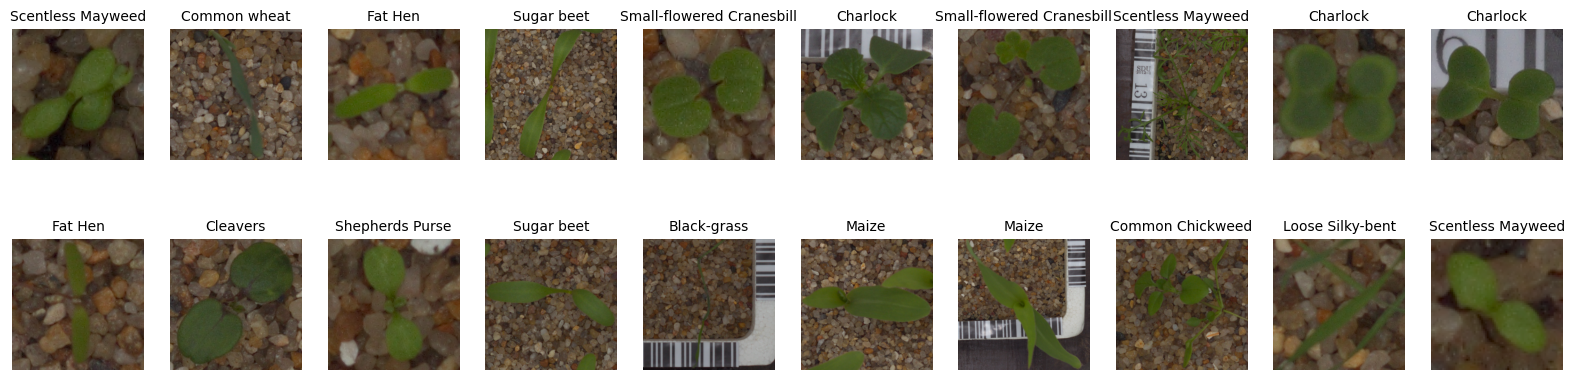

In [12]:
fig = plt.figure(figsize = (20, 5))

for i in range(20):
    img = Image.open(df_dataset_train.iloc[i]['path'])
    ax = fig.add_subplot(2, 10, i + 1)
    ax.imshow(img.convert('RGB'))
    title = dict_map_class_inverted[df_dataset_train.iloc[i]['label']]
    ax.set_title(title, fontsize=10)
    ax.axis('off')

# **3. Acondicionamiento del conjunto de datos**

#### Creados los Splits para el Dataset original, podemos pasar a preparar un ejemplo de los TensorFlow Datasets pertinentes para cada uno de los Splits (Train, Val y Test) que se van a usar para las siguientes pruebas. A su vez, también los visualizaremos para ver qué imagenes entrarían a la red

In [13]:
# Creamos un ejemplo de datastet de train
train_tfdataset = get_dataset(
    df=df_dataset_train,
    input_size=(224,224),
    batch_size=16,
    shuffle=True,
    gray_scale=False,
    augmenter=True,
    num_aug=1,
)

train_tfdataset

Number of instances per label: 
label
0     523
1     488
2     412
3     396
4     380
5     312
6     308
7     229
8     210
9     184
10    176
11    176
Name: count, dtype: int64

Percentaje of instances per label: 
label
0     0.137849
1     0.128624
2     0.108593
3     0.104375
4     0.100158
5     0.082235
6     0.081181
7     0.060358
8     0.055351
9     0.048498
10    0.046389
11    0.046389
Name: count, dtype: float64


2023-11-26 18:42:44.832637: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-26 18:42:44.837225: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-26 18:42:44.837457: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-26 18:42:44.840091: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-26 18:42:44.840385: I tensorflow/compile

 > Shuffle
 > Augmentamos datos numero 1
 > Establecemos el batchsize


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 12), dtype=tf.float32, name=None))>

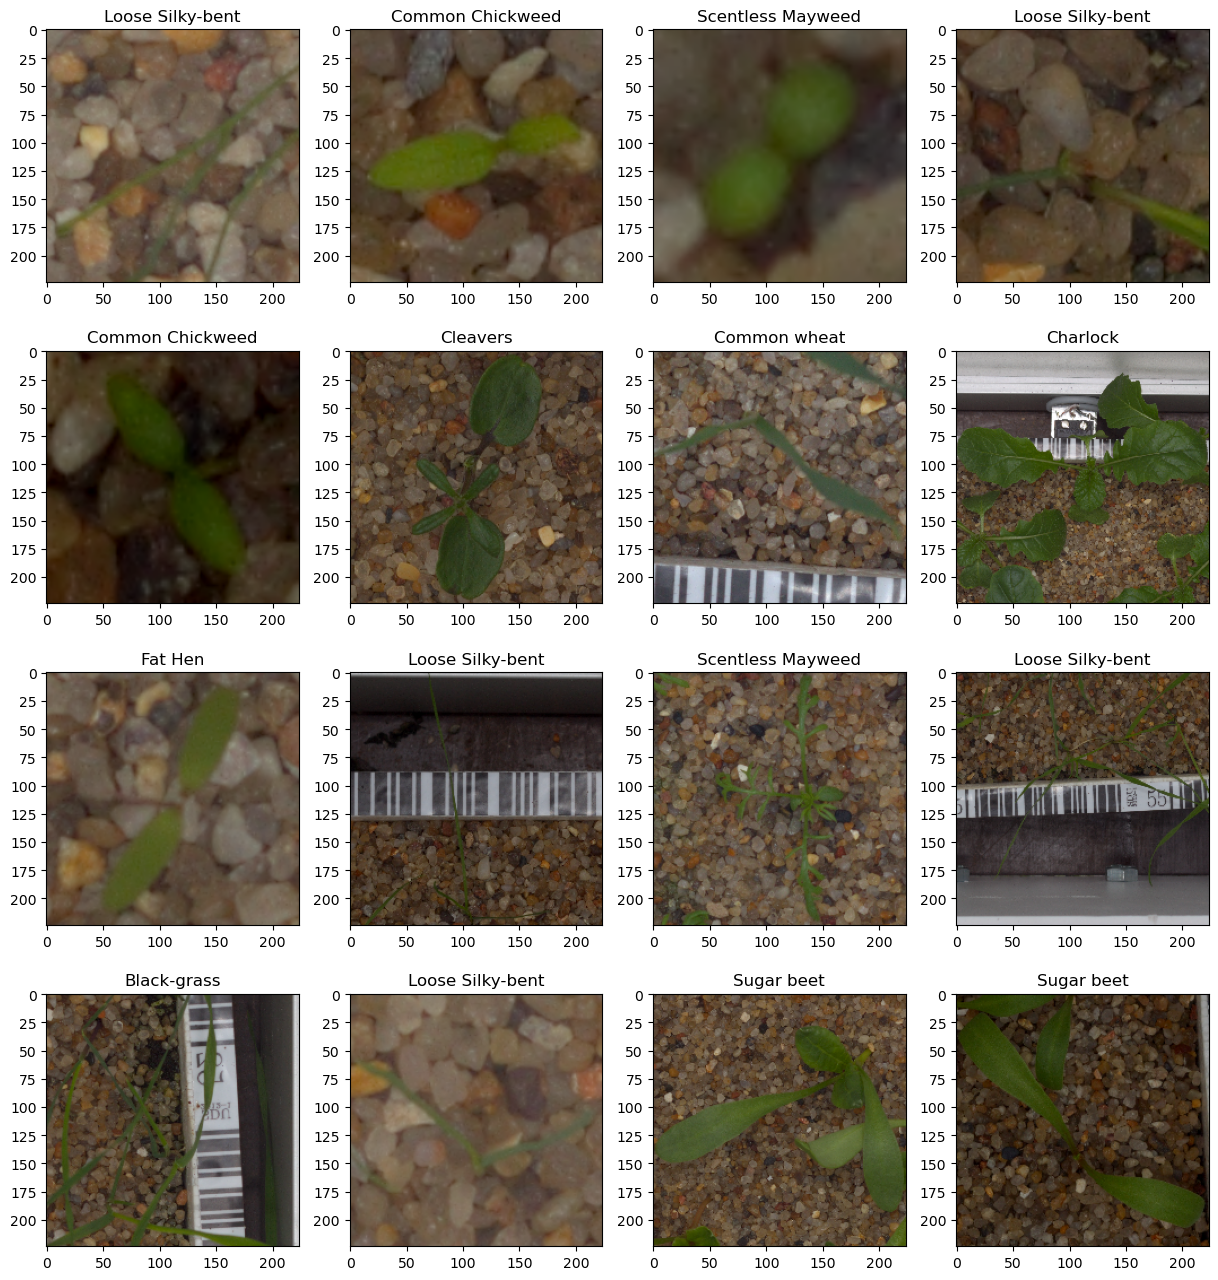

In [14]:
# Visualizamos dataset de Train
batch = next(iter(train_tfdataset))

batches_card_np = batch[0].numpy()
y = batch[1].numpy()
images = list(iter(batches_card_np))

fig, axs = plt.subplots(math.ceil(len(images)/4), 4, figsize=(15, math.ceil(len(images)/4)*4))
axs = axs.ravel()

for i, image in enumerate(images):
    axs[i].imshow(image, cmap='gray')
    title = f"{dict_map_class_inverted[np.argmax(y[i])]}"
    axs[i].set_title(title)

In [15]:
# Creamos un ejemplo de datastet de Validacion
valid_tfdataset = get_dataset(
    df=df_dataset_valid,
    input_size=(224,224),
    batch_size=16,
    shuffle=True,
    gray_scale=False,
    augmenter=False,
)

valid_tfdataset

Number of instances per label: 
label
0     131
1     123
2     104
3     100
4      95
5      78
6      77
7      58
8      53
9      47
11     45
10     45
Name: count, dtype: int64

Percentaje of instances per label: 
label
0     0.137029
1     0.128661
2     0.108787
3     0.104603
4     0.099372
5     0.081590
6     0.080544
7     0.060669
8     0.055439
9     0.049163
11    0.047071
10    0.047071
Name: count, dtype: float64
 > Shuffle
 > Establecemos el batchsize


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 12), dtype=tf.float32, name=None))>

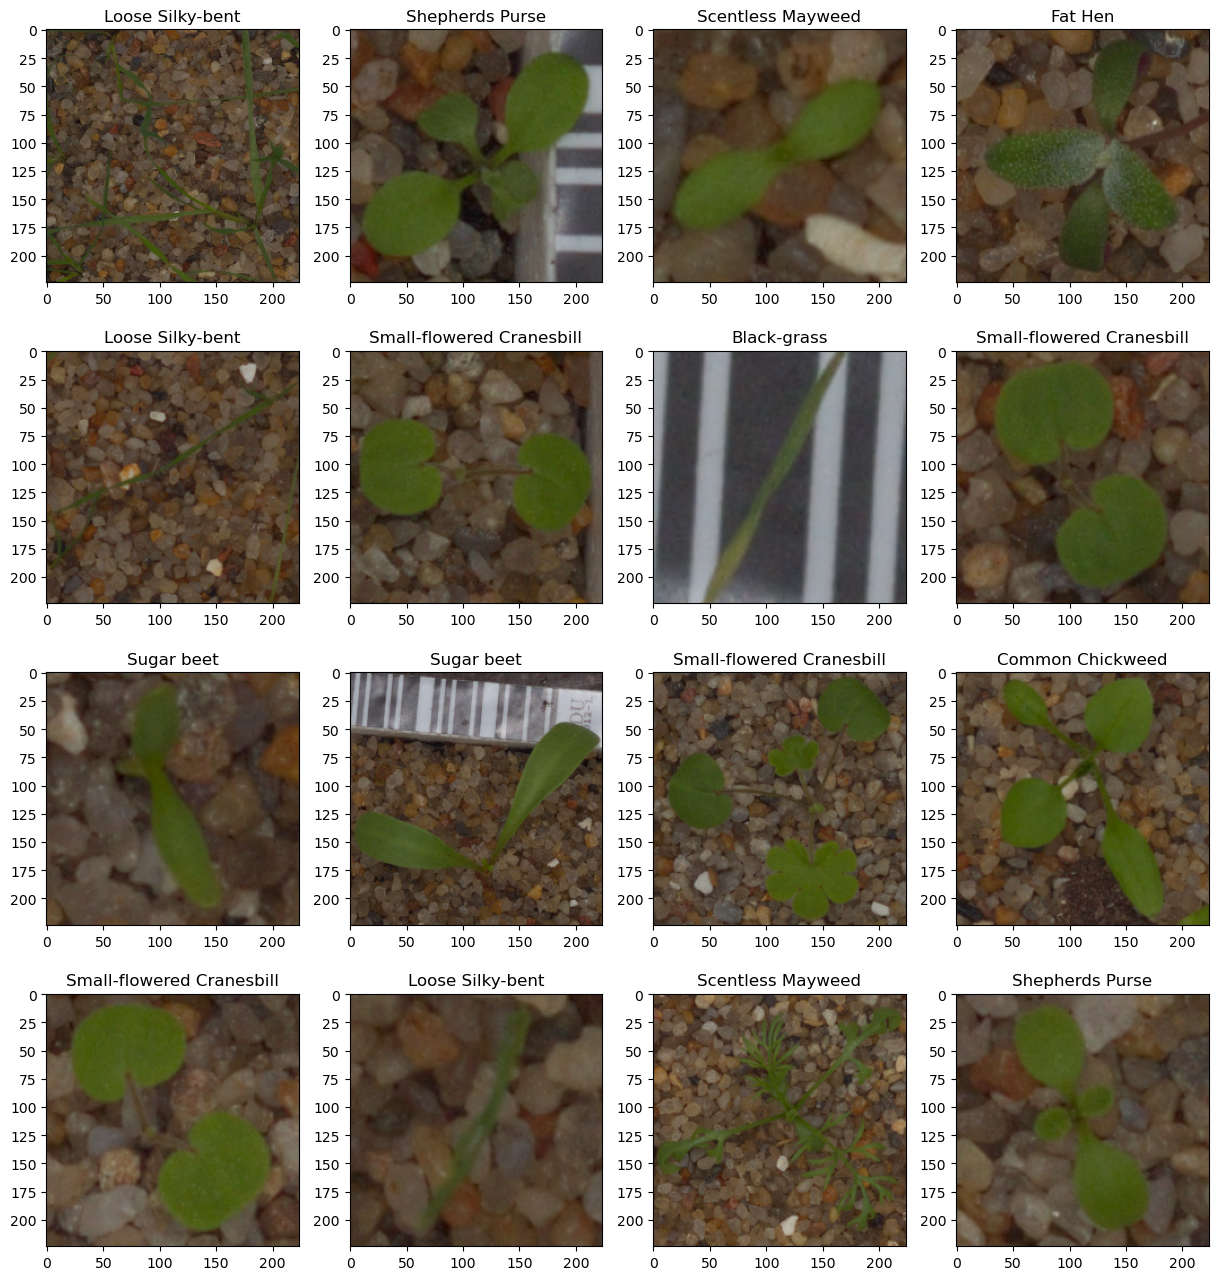

In [16]:
# Visualizamos dataset de Train
batch = next(iter(valid_tfdataset))

batches_card_np = batch[0].numpy()
y = batch[1].numpy()
images = list(iter(batches_card_np))

fig, axs = plt.subplots(math.ceil(len(images)/4), 4, figsize=(15, math.ceil(len(images)/4)*4))
axs = axs.ravel()

for i, image in enumerate(images):
    axs[i].imshow(image, cmap='gray')
    title = f"{dict_map_class_inverted[np.argmax(y[i])]}"
    axs[i].set_title(title)

In [17]:
# Creamos un ejemplo de datastet de test
test_tfdataset = get_dataset(
    df=df_dataset_test,
    input_size=(224,224),
    batch_size=16,
    gray_scale=False,
    augmenter=False,
    test_set=True,
)

test_tfdataset

Number of instances per label: 
label
Unkown    794
Name: count, dtype: int64

Percentaje of instances per label: 
label
Unkown    1.0
Name: count, dtype: float64
 > Establecemos el batchsize


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

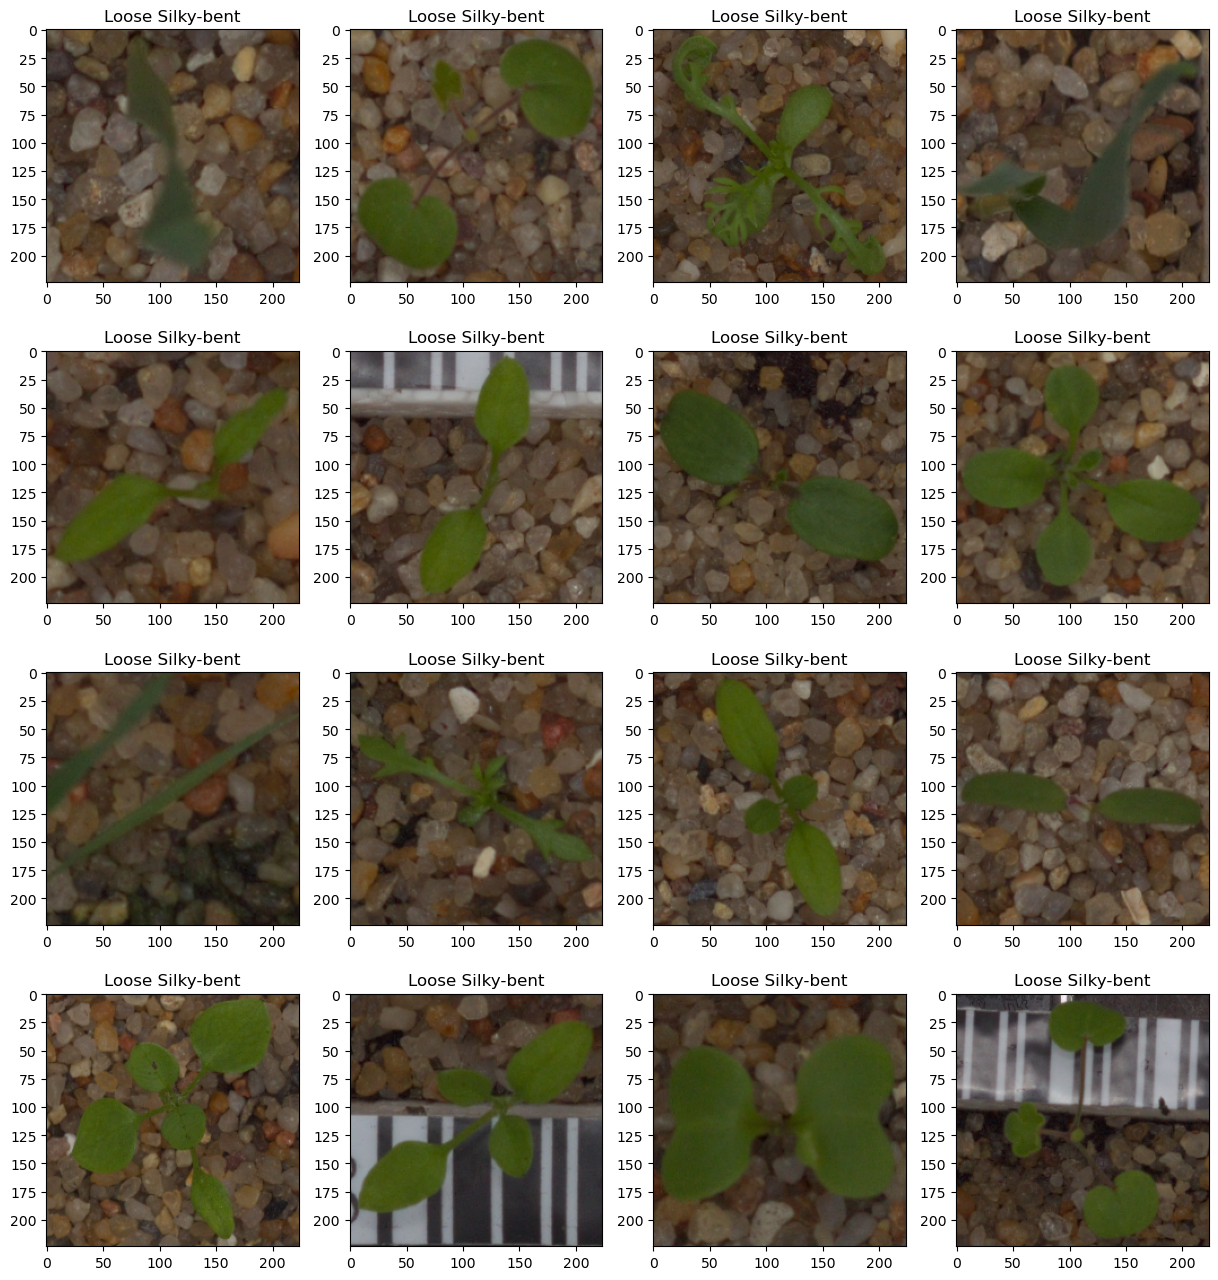

In [18]:
# Visualizamos dataset de Test
batch = next(iter(test_tfdataset))

batches_card_np = batch[0].numpy()
y = batch[1].numpy()
images = list(iter(batches_card_np))

fig, axs = plt.subplots(math.ceil(len(images)/4), 4, figsize=(15, math.ceil(len(images)/4)*4))
axs = axs.ravel()

for i, image in enumerate(images):
    axs[i].imshow(image, cmap='gray')
    title = f"{dict_map_class_inverted[np.argmax(y[i])]}"
    axs[i].set_title(title)

# **4.1 Desarrollo de la arquitectura de red neuronal y entrenamiento de la solución (from scratch)**

### Creamos los callbacks

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

class HistoryAndPlotCallback(Callback):
    def __init__(self, model_name):
        super(HistoryAndPlotCallback, self).__init__()
        self.model_name = model_name

    def on_train_end(self, logs=None):
        # Guardar el historial del modelo
        history = self.model.history.history

        # Calcular límite eje Y
        loss_av = np.average(history["loss"][-1])
        val_loss_av = np.average(history["val_loss"][-1])
        acc_av = np.average(history["acc"][-1])
        val_acc_av = np.average(history["val_acc"][-1])
        y_upper_limit = np.max([loss_av, val_loss_av, acc_av, val_acc_av])
        y_upper_limit *= 2

        np.save(f'models/{self.model_name}/training_history.npy', history)

        # Guardar métricas y pérdidas en una sola gráfica
        epochs = len(history["loss"])
        
        plt.style.use("ggplot")
        plt.figure(figsize=(12, 8))
        plt.plot(np.arange(0, epochs), history["loss"], label="train_loss")
        plt.plot(np.arange(0, epochs), history["val_loss"], label="val_loss")
        plt.plot(np.arange(0, epochs), history["acc"], label="train_acc")
        plt.plot(np.arange(0, epochs), history["val_acc"], label="val_acc")
        
        plt.title(f"Training Loss and Accuracy - {self.model_name}")
        plt.xlabel("Epoch #")
        plt.ylabel("Loss/Accuracy")
        plt.legend(loc='upper left')
        plt.ylim(0, int(y_upper_limit))
        plt.grid(True)
        
        # Guardar la gráfica
        plt.savefig(f'models/{self.model_name}/training_plot.png')
        plt.close()

        # Guardar history para revisar en el futuro por si se activa un earlystopping o cualquier problema
        pd.DataFrame.from_dict(history).to_csv(f'models/{self.model_name}/history.csv', index=False)


def get_callbacks(model_name):
    callbacks = [
        EarlyStopping(
            monitor = 'val_loss', 
            mode = 'min', 
            patience = 20, 
            verbose=1,
            restore_best_weights=False),
        ModelCheckpoint(
            filepath = f'models/{model_name}',
            monitor = 'val_loss',
            mode = 'min',
            save_best_only = True,
            verbose = 1),
        HistoryAndPlotCallback(model_name),

    ]
        
    return callbacks

Hemos creado Callbacks para almacenar los mejores checkpoints de los modelos a medida que se iban entrenando las redes. 

Hemos decidido incluir el EarlyStopping para evitar un sobreentrenamiento y gastar recursos computacionales.

Las métricas a monitorear es el val_loss. Se intenta minimizar en cada época.

También hemos almacenado el historial de entrenamiento para, posteriormente, poder obtener las gráficas. También está añadido el callback para guardar las gráficas después de cada época.

### Creamos los datasets para train, val y test

In [20]:
print("Dataset Train (TensorFlow):")

train_tfdataset = get_dataset(
    df=df_dataset_train,
    input_size=(224,224),
    batch_size=32,
    shuffle=True,
    gray_scale=False,
    augmenter=True,
    num_aug=1,
)
train_tfdataset

Dataset Train (TensorFlow):
Number of instances per label: 
label
0     523
1     488
2     412
3     396
4     380
5     312
6     308
7     229
8     210
9     184
10    176
11    176
Name: count, dtype: int64

Percentaje of instances per label: 
label
0     0.137849
1     0.128624
2     0.108593
3     0.104375
4     0.100158
5     0.082235
6     0.081181
7     0.060358
8     0.055351
9     0.048498
10    0.046389
11    0.046389
Name: count, dtype: float64
 > Shuffle
 > Augmentamos datos numero 1
 > Establecemos el batchsize


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 12), dtype=tf.float32, name=None))>

In [21]:
print("Dataset Valid (TensorFlow):")

valid_tfdataset = get_dataset(
    df=df_dataset_valid,
    input_size=(224,224),
    batch_size=32,
    shuffle=False,
    gray_scale=False,
    augmenter=False,
)

valid_tfdataset

Dataset Valid (TensorFlow):
Number of instances per label: 
label
0     131
1     123
2     104
3     100
4      95
5      78
6      77
7      58
8      53
9      47
11     45
10     45
Name: count, dtype: int64

Percentaje of instances per label: 
label
0     0.137029
1     0.128661
2     0.108787
3     0.104603
4     0.099372
5     0.081590
6     0.080544
7     0.060669
8     0.055439
9     0.049163
11    0.047071
10    0.047071
Name: count, dtype: float64
 > Establecemos el batchsize


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 12), dtype=tf.float32, name=None))>

In [22]:
print("Dataset Test (TensorFlow):")

test_tfdataset = get_dataset(
    df=df_dataset_test,
    input_size=(224,224),
    batch_size=32,
    gray_scale=False,
    augmenter=False,
    test_set=True,
)

test_tfdataset

Dataset Test (TensorFlow):
Number of instances per label: 
label
Unkown    794
Name: count, dtype: int64

Percentaje of instances per label: 
label
Unkown    1.0
Name: count, dtype: float64
 > Establecemos el batchsize


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

### Función para lanzar factoría de modelos from scratch
En este bucle se carga la factoría de modelos from scratch para ir probando cada uno y guardando sus resultados con los callbacks personalizados. Las configuraciones de los modelos vienen desde el archivo "scratch_configs/scratch_experiments.json". Estas configuraciones se pasan a la factoría y se crean los modelos.

In [23]:
# model_factory
from tensorflow.keras import models, layers

class ConvBlockConfig:
    def __init__(self, filters, kernel_size, use_maxpooling=True, use_batchnorm=True, dropout_value=0, name=None):
        """Configuracion de cada bloque con los parametros que vienen del json

        Args:
            filters (_type_): Numero de filtros del bloque (una capa convolucional por bloque)
            kernel_size (_type_): Tamaño del kernel de la capa convolucional
            use_maxpooling (bool, optional): Usar regularizacion MaxPooling. Defaults to True.
            use_batchnorm (bool, optional): Usar regularizacion BatchNorm. Defaults to True.
            dropout_value (int, optional): Usar regularizacion Dropout. Defaults to 0.
            name (_type_, optional): Nombre del bloque. Defaults to None.
        """
        self.filters = filters
        self.kernel_size = kernel_size
        self.use_maxpooling = use_maxpooling
        self.use_batchnorm = use_batchnorm
        self.dropout_value = dropout_value
        self.name = name

def create_conv_block(config, input_shape):
    """Crea los bloques convolucionales con sus regularizaciones (MaxPooling, BatchNorm y Dropout)

    Args:
        config (_type_): Configuracion de cada bloque (viene del json de experimentos)
        input_shape (_type_): Tamaño de entrada del bloque

    Returns:
        _type_: Bloque convolucional
    """
    # Creacion del modelo
    block = models.Sequential(name=config.name)
    
    # CNN input 
    block.add(layers.Conv2D(config.filters, config.kernel_size, activation='relu', padding='same', input_shape=input_shape))
    
    # Regularizacion
    if config.use_batchnorm:
        block.add(layers.BatchNormalization(name=f'{config.name}_batchnorm'))
    
    if config.use_maxpooling:
        block.add(layers.MaxPooling2D((2, 2), name=f'{config.name}_maxpooling'))
    
    if config.dropout_value > 0:
        block.add(layers.Dropout(config.dropout_value))
    
    return block

def create_model_with_configurations(conv_block_configs, input_shape, num_classes):
    """Crea el modelo en base a los bloques que le hemos pasado con la configuracion de los experimentos

    Args:
        conv_block_configs (_type_): Configuracion de los bloques
        input_shape (_type_): Dimensiones de entrada
        num_classes (_type_): Numeros de clases para la capa de salida

    Returns:
        _type_: Modelo
    """
    model = models.Sequential()
    
    # Incluimos la capa de entrada directamente en el modelo principal
    model.add(layers.InputLayer(input_shape=input_shape, name='input'))
    
    # Creacion de los bloques para la extraccion de caracteristicas
    for i, config in enumerate(conv_block_configs, start=1):
        block = create_conv_block(config, input_shape)
        model.add(block)
        input_shape = (input_shape[0]//2, input_shape[1]//2, config.filters)  # Ajustamos input_shape después de MaxPooling
    
    # Creacion del top model para obtener la clase
    model.add(layers.Flatten(name='top_model_flatten'))
    model.add(layers.Dense(128, activation='relu', name='top_model_dense_1'))
    #model.add(layers.Dropout(0.5, name='top_model_dropout')) # Opcional
    model.add(layers.Dense(num_classes, activation='softmax', name='top_model_output'))
    
    return model

In [24]:
def scratch_train(input_shape, experiment_config:dict):
    # Crear modelo, compilarlo y entrenarlo
    for experiment_name, config in experiment_config.items():
        print(f"Running Experiment: {experiment_name}")

        # Configurar el modelo utilizando las configuraciones
        block_configs = []
        for block_conf in config["model"]["conv_block_configs"]:
            block = ConvBlockConfig(block_conf["filters"], 
                                    block_conf["kernel_size"], 
                                    block_conf["use_maxpooling"],
                                    block_conf["use_batchnorm"],
                                    block_conf["dropout_value"],
                                    block_conf["name"])
            block_configs.append(block)
        
        # Crear modelo
        model = create_model_with_configurations(block_configs, input_shape, num_classes)
        
        # Compilar modelo
        model.compile(
            loss = tf.keras.losses.categorical_crossentropy,
            optimizer = tf.keras.optimizers.Adam(0.0001),
            metrics = ['acc']) 
        
        # Crear callbacks
        callbacks = get_callbacks(experiment_name)

        # Mostrar arquitectura
        print(model.summary())

        # Entrenar modelo
        history = model.fit(train_tfdataset.repeat(),
                            validation_data=valid_tfdataset,
                            class_weight = class_weight_dict,
                            epochs = config["training"]["epochs"],
                            steps_per_epoch=config["training"]["steps_per_epoch"],
                            callbacks = callbacks,
                            verbose=1)

# **5.1 Monitorización del proceso de entrenamiento para la toma de decisiones (from scratch)**


### Lanzar entrenamiento from scratch
Usando la configuración de los modelos de la factoría, se lanzan todos los experimentos. De esta manera se ejecutan uno detrás de otro sin necesidad de estar pendiente de lanzarlos manualmente.
La configuración de todos los experimentos se detalla a continuación:

In [25]:
# Configuración experimentos
scratch_experiments = {
    "model1": {
        "model": {
            "conv_block_configs": [
                {
                    "filters": 64, 
                    "kernel_size": [3, 3], 
                    "use_maxpooling": True, 
                    "use_batchnorm": True, 
                    "dropout_value": 0.1,
                    "name": "block1"
                },
                
                {
                    "filters": 128, 
                    "kernel_size": [3, 3], 
                    "use_maxpooling": True, 
                    "use_batchnorm": True, 
                    "dropout_value": 0.1,
                    "name": "block2"
                },
                
                {
                    "filters": 256, 
                    "kernel_size": [3, 3], 
                    "use_maxpooling": True, 
                    "use_batchnorm": True, 
                    "dropout_value": 0.1,
                    "name": "block3"
                }
            ]
        },
        "training": {
            "steps_per_epoch": 32,
            "epochs": 50
        }
    },
    
    "model1_nobatchnorm": {
        "model": {
            "conv_block_configs": [
                {
                    "filters": 64, 
                    "kernel_size": [3, 3], 
                    "use_maxpooling": True, 
                    "use_batchnorm": False, 
                    "dropout_value": 0.1,
                    "name": "block1"
                },
                {
                    "filters": 128, 
                    "kernel_size": [3, 3], 
                    "use_maxpooling": True, 
                    "use_batchnorm": False, 
                    "dropout_value": 0.1,
                    "name": "block2"},
                {
                    "filters": 256, 
                    "kernel_size": [3, 3], 
                    "use_maxpooling": True, 
                    "use_batchnorm": False, 
                    "dropout_value": 0.1,
                    "name": "block3"
                }
            ]
        },
        "training": {
            "steps_per_epoch": 32,
            "epochs": 50
        }
    },
    
    "model2": {
        "model": {
            "conv_block_configs": [
                {
                    "filters": 64, 
                    "kernel_size": [5, 5], 
                    "use_maxpooling": True, 
                    "use_batchnorm": True, 
                    "dropout_value": 0.1,
                    "name": "block1"},
                {
                    "filters": 128, 
                    "kernel_size": [5, 5], 
                    "use_maxpooling": True, 
                    "use_batchnorm": True, 
                    "dropout_value": 0.1,
                    "name": "block2"
                }
            ]
        },
        "training": {
            "steps_per_epoch": 32,
            "epochs": 50
        }
    },

    "model2_nobatchnorm": {
        "model": {
            "conv_block_configs": [
                {
                    "filters": 64, 
                    "kernel_size": [5, 5], 
                    "use_maxpooling": True, 
                    "use_batchnorm": False, 
                    "dropout_value": 0.1,
                    "name": "block1"},
                {
                    "filters": 128, 
                    "kernel_size": [5, 5], 
                    "use_maxpooling": True, 
                    "use_batchnorm": False, 
                    "dropout_value": 0.1,
                    "name": "block2"
                }
            ]
        },
        "training": {
            "steps_per_epoch": 32,
            "epochs": 50
        }
    },

    "model3": {
        "model": {
            "conv_block_configs": [
                {
                    "filters": 64, 
                    "kernel_size": [3, 3], 
                    "use_maxpooling": True, 
                    "use_batchnorm": True, 
                    "dropout_value": 0.1,
                    "name": "block1"
                },
                {
                    "filters": 128, 
                    "kernel_size": [3, 3], 
                    "use_maxpooling": True, 
                    "use_batchnorm": True, 
                    "dropout_value": 0.1,
                    "name": "block2"
                },
                {
                    "filters": 256, 
                    "kernel_size": [3, 3], 
                    "use_maxpooling": True, 
                    "use_batchnorm": True, 
                    "dropout_value": 0.1,
                    "name": "block3"
                },
                {
                    "filters": 512, 
                    "kernel_size": [3, 3], 
                    "use_maxpooling": True, 
                    "use_batchnorm": True, 
                    "dropout_value": 0.1,
                    "name": "block4"
                }
            ]
        },
        "training": {
            "steps_per_epoch": 32,
            "epochs": 50
        }
    },

    "model3_nobatchnorm": {
        "model": {
            "conv_block_configs": [
                {
                    "filters": 64, 
                    "kernel_size": [3, 3], 
                    "use_maxpooling": True, 
                    "use_batchnorm": False, 
                    "dropout_value": 0.1,
                    "name": "block1"
                },
                {
                    "filters": 128, 
                    "kernel_size": [3, 3], 
                    "use_maxpooling": True, 
                    "use_batchnorm": False, 
                    "dropout_value": 0.1,
                    "name": "block2"
                },
                {
                    "filters": 256, 
                    "kernel_size": [3, 3], 
                    "use_maxpooling": True, 
                    "use_batchnorm": False, 
                    "dropout_value": 0.1,
                    "name": "block3"
                },
                {
                    "filters": 512, 
                    "kernel_size": [3, 3], 
                    "use_maxpooling": True, 
                    "use_batchnorm": False, 
                    "dropout_value": 0.1,
                    "name": "block4"
                }
            ]
        },
        "training": {
            "steps_per_epoch": 32,
            "epochs": 50
        }
    }
  }
  

In [26]:
# Dimensiones de entrada
input_shape = (224, 224, 3)

# Número de clases
num_classes = df_dataset_train["label"].max() + 1

# Lanzar entrenamiento
scratch_train(input_shape, scratch_experiments)

Running Experiment: model1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1 (Sequential)         (None, 112, 112, 64)      2048      
                                                                 
 block2 (Sequential)         (None, 56, 56, 128)       74368     
                                                                 
 block3 (Sequential)         (None, 28, 28, 256)       296192    
                                                                 
 top_model_flatten (Flatten  (None, 200704)            0         
 )                                                               
                                                                 
 top_model_dense_1 (Dense)   (None, 128)               25690240  
                                                                 
 top_model_output (Dense)    (None, 12)                1548      
                             

2023-11-26 18:42:56.542931: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/block1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-11-26 18:42:57.095623: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-26 18:42:57.397182: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-26 18:42:57.927327: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-26 18:42:58.734794: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f8ca803a590 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-26 18:42:58.734834: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Co

32/32 [==============================] - ETA: 0s - loss: 4.8960 - acc: 0.1680
Epoch 1: val_loss improved from inf to 23.67860, saving model to models/model1
INFO:tensorflow:Assets written to: models/model1/assets


INFO:tensorflow:Assets written to: models/model1/assets


32/32 [==============================] - 18s 380ms/step - loss: 4.8960 - acc: 0.1680 - val_loss: 23.6786 - val_acc: 0.1287
Epoch 2/50
32/32 [==============================] - ETA: 0s - loss: 2.2053 - acc: 0.2080
Epoch 2: val_loss did not improve from 23.67860
32/32 [==============================] - 9s 291ms/step - loss: 2.2053 - acc: 0.2080 - val_loss: 40.6756 - val_acc: 0.1287
Epoch 3/50
32/32 [==============================] - ETA: 0s - loss: 2.1161 - acc: 0.2500
Epoch 3: val_loss did not improve from 23.67860
32/32 [==============================] - 10s 321ms/step - loss: 2.1161 - acc: 0.2500 - val_loss: 50.5102 - val_acc: 0.1287
Epoch 4/50
32/32 [==============================] - ETA: 0s - loss: 1.9974 - acc: 0.2960
Epoch 4: val_loss did not improve from 23.67860
32/32 [==============================] - 10s 315ms/step - loss: 1.9974 - acc: 0.2960 - val_loss: 54.4386 - val_acc: 0.1287
Epoch 5/50
32/32 [==============================] - ETA: 0s - loss: 1.9432 - acc: 0.3125
Epoch 5: 

INFO:tensorflow:Assets written to: models/model1/assets


32/32 [==============================] - 12s 388ms/step - loss: 1.6856 - acc: 0.4561 - val_loss: 20.5751 - val_acc: 0.1308
Epoch 11/50
32/32 [==============================] - ETA: 0s - loss: 1.7020 - acc: 0.4141
Epoch 11: val_loss improved from 20.57506 to 11.84752, saving model to models/model1
INFO:tensorflow:Assets written to: models/model1/assets


INFO:tensorflow:Assets written to: models/model1/assets


32/32 [==============================] - 12s 371ms/step - loss: 1.7020 - acc: 0.4141 - val_loss: 11.8475 - val_acc: 0.1444
Epoch 12/50
32/32 [==============================] - ETA: 0s - loss: 1.4994 - acc: 0.4762
Epoch 12: val_loss improved from 11.84752 to 3.79100, saving model to models/model1
INFO:tensorflow:Assets written to: models/model1/assets


INFO:tensorflow:Assets written to: models/model1/assets


32/32 [==============================] - 13s 397ms/step - loss: 1.4994 - acc: 0.4762 - val_loss: 3.7910 - val_acc: 0.3159
Epoch 13/50
32/32 [==============================] - ETA: 0s - loss: 1.5487 - acc: 0.4258
Epoch 13: val_loss improved from 3.79100 to 3.02257, saving model to models/model1
INFO:tensorflow:Assets written to: models/model1/assets


INFO:tensorflow:Assets written to: models/model1/assets


32/32 [==============================] - 13s 408ms/step - loss: 1.5487 - acc: 0.4258 - val_loss: 3.0226 - val_acc: 0.3096
Epoch 14/50
32/32 [==============================] - ETA: 0s - loss: 1.5119 - acc: 0.4873
Epoch 14: val_loss improved from 3.02257 to 2.89093, saving model to models/model1
INFO:tensorflow:Assets written to: models/model1/assets


INFO:tensorflow:Assets written to: models/model1/assets


32/32 [==============================] - 13s 404ms/step - loss: 1.5119 - acc: 0.4873 - val_loss: 2.8909 - val_acc: 0.2542
Epoch 15/50
32/32 [==============================] - ETA: 0s - loss: 1.4071 - acc: 0.5089
Epoch 15: val_loss did not improve from 2.89093
32/32 [==============================] - 10s 303ms/step - loss: 1.4071 - acc: 0.5089 - val_loss: 3.4234 - val_acc: 0.2113
Epoch 16/50
32/32 [==============================] - ETA: 0s - loss: 1.4183 - acc: 0.5322
Epoch 16: val_loss improved from 2.89093 to 2.12441, saving model to models/model1
INFO:tensorflow:Assets written to: models/model1/assets


INFO:tensorflow:Assets written to: models/model1/assets


32/32 [==============================] - 12s 394ms/step - loss: 1.4183 - acc: 0.5322 - val_loss: 2.1244 - val_acc: 0.3023
Epoch 17/50
32/32 [==============================] - ETA: 0s - loss: 1.4387 - acc: 0.5059
Epoch 17: val_loss improved from 2.12441 to 1.81835, saving model to models/model1
INFO:tensorflow:Assets written to: models/model1/assets


INFO:tensorflow:Assets written to: models/model1/assets


32/32 [==============================] - 12s 382ms/step - loss: 1.4387 - acc: 0.5059 - val_loss: 1.8183 - val_acc: 0.3421
Epoch 18/50
32/32 [==============================] - ETA: 0s - loss: 1.4313 - acc: 0.5225
Epoch 18: val_loss improved from 1.81835 to 1.68183, saving model to models/model1
INFO:tensorflow:Assets written to: models/model1/assets


INFO:tensorflow:Assets written to: models/model1/assets


32/32 [==============================] - 11s 359ms/step - loss: 1.4313 - acc: 0.5225 - val_loss: 1.6818 - val_acc: 0.3860
Epoch 19/50
32/32 [==============================] - ETA: 0s - loss: 1.4047 - acc: 0.5099
Epoch 19: val_loss did not improve from 1.68183
32/32 [==============================] - 10s 327ms/step - loss: 1.4047 - acc: 0.5099 - val_loss: 1.7434 - val_acc: 0.4205
Epoch 20/50
32/32 [==============================] - ETA: 0s - loss: 1.2930 - acc: 0.5566
Epoch 20: val_loss improved from 1.68183 to 1.62373, saving model to models/model1
INFO:tensorflow:Assets written to: models/model1/assets


INFO:tensorflow:Assets written to: models/model1/assets


32/32 [==============================] - 11s 358ms/step - loss: 1.2930 - acc: 0.5566 - val_loss: 1.6237 - val_acc: 0.4623
Epoch 21/50
32/32 [==============================] - ETA: 0s - loss: 1.3711 - acc: 0.5273
Epoch 21: val_loss improved from 1.62373 to 1.46950, saving model to models/model1
INFO:tensorflow:Assets written to: models/model1/assets


INFO:tensorflow:Assets written to: models/model1/assets


32/32 [==============================] - 12s 375ms/step - loss: 1.3711 - acc: 0.5273 - val_loss: 1.4695 - val_acc: 0.5126
Epoch 22/50
32/32 [==============================] - ETA: 0s - loss: 1.3458 - acc: 0.5342
Epoch 22: val_loss did not improve from 1.46950
32/32 [==============================] - 9s 275ms/step - loss: 1.3458 - acc: 0.5342 - val_loss: 1.9755 - val_acc: 0.4027
Epoch 23/50
32/32 [==============================] - ETA: 0s - loss: 1.2419 - acc: 0.5624
Epoch 23: val_loss did not improve from 1.46950
32/32 [==============================] - 10s 312ms/step - loss: 1.2419 - acc: 0.5624 - val_loss: 1.5645 - val_acc: 0.4833
Epoch 24/50
32/32 [==============================] - ETA: 0s - loss: 1.2066 - acc: 0.5908
Epoch 24: val_loss improved from 1.46950 to 1.44475, saving model to models/model1
INFO:tensorflow:Assets written to: models/model1/assets


INFO:tensorflow:Assets written to: models/model1/assets


32/32 [==============================] - 12s 381ms/step - loss: 1.2066 - acc: 0.5908 - val_loss: 1.4447 - val_acc: 0.5356
Epoch 25/50
32/32 [==============================] - ETA: 0s - loss: 1.1184 - acc: 0.6162
Epoch 25: val_loss improved from 1.44475 to 1.30158, saving model to models/model1
INFO:tensorflow:Assets written to: models/model1/assets


INFO:tensorflow:Assets written to: models/model1/assets


32/32 [==============================] - 13s 411ms/step - loss: 1.1184 - acc: 0.6162 - val_loss: 1.3016 - val_acc: 0.5628
Epoch 26/50
32/32 [==============================] - ETA: 0s - loss: 1.1335 - acc: 0.6104
Epoch 26: val_loss did not improve from 1.30158
32/32 [==============================] - 8s 266ms/step - loss: 1.1335 - acc: 0.6104 - val_loss: 1.3503 - val_acc: 0.5764
Epoch 27/50
32/32 [==============================] - ETA: 0s - loss: 1.1687 - acc: 0.5921
Epoch 27: val_loss did not improve from 1.30158
32/32 [==============================] - 10s 330ms/step - loss: 1.1687 - acc: 0.5921 - val_loss: 1.3236 - val_acc: 0.5523
Epoch 28/50
32/32 [==============================] - ETA: 0s - loss: 1.0763 - acc: 0.6299
Epoch 28: val_loss improved from 1.30158 to 1.16862, saving model to models/model1
INFO:tensorflow:Assets written to: models/model1/assets


INFO:tensorflow:Assets written to: models/model1/assets


32/32 [==============================] - 12s 378ms/step - loss: 1.0763 - acc: 0.6299 - val_loss: 1.1686 - val_acc: 0.6077
Epoch 29/50
32/32 [==============================] - ETA: 0s - loss: 0.9967 - acc: 0.6396
Epoch 29: val_loss did not improve from 1.16862
32/32 [==============================] - 10s 323ms/step - loss: 0.9967 - acc: 0.6396 - val_loss: 1.3106 - val_acc: 0.5994
Epoch 30/50
32/32 [==============================] - ETA: 0s - loss: 0.9920 - acc: 0.6604
Epoch 30: val_loss did not improve from 1.16862
32/32 [==============================] - 9s 294ms/step - loss: 0.9920 - acc: 0.6604 - val_loss: 1.1948 - val_acc: 0.6297
Epoch 31/50
32/32 [==============================] - ETA: 0s - loss: 0.9455 - acc: 0.6621
Epoch 31: val_loss did not improve from 1.16862
32/32 [==============================] - 10s 309ms/step - loss: 0.9455 - acc: 0.6621 - val_loss: 1.1806 - val_acc: 0.6077
Epoch 32/50
32/32 [==============================] - ETA: 0s - loss: 0.8997 - acc: 0.6885
Epoch 32:

INFO:tensorflow:Assets written to: models/model1/assets


32/32 [==============================] - 12s 369ms/step - loss: 0.8997 - acc: 0.6885 - val_loss: 1.1077 - val_acc: 0.6391
Epoch 33/50
32/32 [==============================] - ETA: 0s - loss: 0.9859 - acc: 0.6797
Epoch 33: val_loss did not improve from 1.10771
32/32 [==============================] - 9s 286ms/step - loss: 0.9859 - acc: 0.6797 - val_loss: 1.2130 - val_acc: 0.6130
Epoch 34/50
32/32 [==============================] - ETA: 0s - loss: 0.8005 - acc: 0.7228
Epoch 34: val_loss improved from 1.10771 to 1.06737, saving model to models/model1
INFO:tensorflow:Assets written to: models/model1/assets


INFO:tensorflow:Assets written to: models/model1/assets


32/32 [==============================] - 12s 394ms/step - loss: 0.8005 - acc: 0.7228 - val_loss: 1.0674 - val_acc: 0.6642
Epoch 35/50
32/32 [==============================] - ETA: 0s - loss: 0.8011 - acc: 0.7168
Epoch 35: val_loss improved from 1.06737 to 0.98820, saving model to models/model1
INFO:tensorflow:Assets written to: models/model1/assets


INFO:tensorflow:Assets written to: models/model1/assets


32/32 [==============================] - 12s 384ms/step - loss: 0.8011 - acc: 0.7168 - val_loss: 0.9882 - val_acc: 0.6987
Epoch 36/50
32/32 [==============================] - ETA: 0s - loss: 0.9371 - acc: 0.7031
Epoch 36: val_loss did not improve from 0.98820
32/32 [==============================] - 10s 305ms/step - loss: 0.9371 - acc: 0.7031 - val_loss: 1.5705 - val_acc: 0.5523
Epoch 37/50
32/32 [==============================] - ETA: 0s - loss: 0.9203 - acc: 0.6826
Epoch 37: val_loss did not improve from 0.98820
32/32 [==============================] - 8s 261ms/step - loss: 0.9203 - acc: 0.6826 - val_loss: 1.1190 - val_acc: 0.6569
Epoch 38/50
32/32 [==============================] - ETA: 0s - loss: 0.7771 - acc: 0.7168
Epoch 38: val_loss did not improve from 0.98820
32/32 [==============================] - 10s 322ms/step - loss: 0.7771 - acc: 0.7168 - val_loss: 1.2343 - val_acc: 0.6506
Epoch 39/50
32/32 [==============================] - ETA: 0s - loss: 0.7867 - acc: 0.7510
Epoch 39:

INFO:tensorflow:Assets written to: models/model1/assets


32/32 [==============================] - 10s 317ms/step - loss: 0.7979 - acc: 0.7396 - val_loss: 0.9799 - val_acc: 0.6946
Epoch 42/50
32/32 [==============================] - ETA: 0s - loss: 0.6619 - acc: 0.7773
Epoch 42: val_loss did not improve from 0.97991
32/32 [==============================] - 10s 301ms/step - loss: 0.6619 - acc: 0.7773 - val_loss: 1.0448 - val_acc: 0.6789
Epoch 43/50
32/32 [==============================] - ETA: 0s - loss: 0.5659 - acc: 0.8037
Epoch 43: val_loss did not improve from 0.97991
32/32 [==============================] - 10s 318ms/step - loss: 0.5659 - acc: 0.8037 - val_loss: 1.1211 - val_acc: 0.6778
Epoch 44/50
32/32 [==============================] - ETA: 0s - loss: 0.5691 - acc: 0.8018
Epoch 44: val_loss did not improve from 0.97991
32/32 [==============================] - 9s 291ms/step - loss: 0.5691 - acc: 0.8018 - val_loss: 1.0486 - val_acc: 0.6778
Epoch 45/50
32/32 [==============================] - ETA: 0s - loss: 0.6078 - acc: 0.8020
Epoch 45:

INFO:tensorflow:Assets written to: models/model1/assets


32/32 [==============================] - 10s 324ms/step - loss: 0.6078 - acc: 0.8020 - val_loss: 0.9250 - val_acc: 0.7312
Epoch 46/50
32/32 [==============================] - ETA: 0s - loss: 0.5549 - acc: 0.8096
Epoch 46: val_loss did not improve from 0.92499
32/32 [==============================] - 10s 313ms/step - loss: 0.5549 - acc: 0.8096 - val_loss: 1.2294 - val_acc: 0.6433
Epoch 47/50
32/32 [==============================] - ETA: 0s - loss: 0.6333 - acc: 0.8027
Epoch 47: val_loss did not improve from 0.92499
32/32 [==============================] - 10s 302ms/step - loss: 0.6333 - acc: 0.8027 - val_loss: 0.9724 - val_acc: 0.7123
Epoch 48/50
32/32 [==============================] - ETA: 0s - loss: 0.5638 - acc: 0.8047
Epoch 48: val_loss did not improve from 0.92499
32/32 [==============================] - 8s 260ms/step - loss: 0.5638 - acc: 0.8047 - val_loss: 0.9955 - val_acc: 0.7134
Epoch 49/50
32/32 [==============================] - ETA: 0s - loss: 0.5466 - acc: 0.8218
Epoch 49:

INFO:tensorflow:Assets written to: models/model1/assets


32/32 [==============================] - 11s 355ms/step - loss: 0.5466 - acc: 0.8218 - val_loss: 0.8916 - val_acc: 0.7103
Epoch 50/50
32/32 [==============================] - ETA: 0s - loss: 0.4633 - acc: 0.8438
Epoch 50: val_loss did not improve from 0.89157
32/32 [==============================] - 9s 293ms/step - loss: 0.4633 - acc: 0.8438 - val_loss: 0.9208 - val_acc: 0.7186
Running Experiment: model1_nobatchnorm
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1 (Sequential)         (None, 112, 112, 64)      1792      
                                                                 
 block2 (Sequential)         (None, 56, 56, 128)       73856     
                                                                 
 block3 (Sequential)         (None, 28, 28, 256)       295168    
                                                                 
 top_model_flatten (Flatten  (

2023-11-26 18:51:47.334375: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/block1/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


 6/32 [====>.........................] - ETA: 2s - loss: 2.6361 - acc: 0.0521WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0357s vs `on_train_batch_end` time: 0.0514s). Check your callbacks.


32/32 [==============================] - ETA: 0s - loss: 2.5038 - acc: 0.0703
Epoch 1: val_loss improved from inf to 2.47914, saving model to models/model1_nobatchnorm
INFO:tensorflow:Assets written to: models/model1_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model1_nobatchnorm/assets


32/32 [==============================] - 12s 344ms/step - loss: 2.5038 - acc: 0.0703 - val_loss: 2.4791 - val_acc: 0.1255
Epoch 2/50
32/32 [==============================] - ETA: 0s - loss: 2.5091 - acc: 0.1143
Epoch 2: val_loss improved from 2.47914 to 2.46177, saving model to models/model1_nobatchnorm
INFO:tensorflow:Assets written to: models/model1_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model1_nobatchnorm/assets


32/32 [==============================] - 11s 348ms/step - loss: 2.5091 - acc: 0.1143 - val_loss: 2.4618 - val_acc: 0.0910
Epoch 3/50
32/32 [==============================] - ETA: 0s - loss: 2.3208 - acc: 0.1533
Epoch 3: val_loss improved from 2.46177 to 2.26747, saving model to models/model1_nobatchnorm
INFO:tensorflow:Assets written to: models/model1_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model1_nobatchnorm/assets


32/32 [==============================] - 11s 360ms/step - loss: 2.3208 - acc: 0.1533 - val_loss: 2.2675 - val_acc: 0.2427
Epoch 4/50
32/32 [==============================] - ETA: 0s - loss: 2.1349 - acc: 0.2703
Epoch 4: val_loss improved from 2.26747 to 2.04743, saving model to models/model1_nobatchnorm
INFO:tensorflow:Assets written to: models/model1_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model1_nobatchnorm/assets


32/32 [==============================] - 10s 301ms/step - loss: 2.1349 - acc: 0.2703 - val_loss: 2.0474 - val_acc: 0.3410
Epoch 5/50
32/32 [==============================] - ETA: 0s - loss: 1.8888 - acc: 0.3135
Epoch 5: val_loss improved from 2.04743 to 1.83637, saving model to models/model1_nobatchnorm
INFO:tensorflow:Assets written to: models/model1_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model1_nobatchnorm/assets


32/32 [==============================] - 11s 338ms/step - loss: 1.8888 - acc: 0.3135 - val_loss: 1.8364 - val_acc: 0.3902
Epoch 6/50
32/32 [==============================] - ETA: 0s - loss: 1.8411 - acc: 0.3652
Epoch 6: val_loss improved from 1.83637 to 1.75534, saving model to models/model1_nobatchnorm
INFO:tensorflow:Assets written to: models/model1_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model1_nobatchnorm/assets


32/32 [==============================] - 11s 363ms/step - loss: 1.8411 - acc: 0.3652 - val_loss: 1.7553 - val_acc: 0.4006
Epoch 7/50
32/32 [==============================] - ETA: 0s - loss: 1.6808 - acc: 0.3809
Epoch 7: val_loss improved from 1.75534 to 1.56954, saving model to models/model1_nobatchnorm
INFO:tensorflow:Assets written to: models/model1_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model1_nobatchnorm/assets


32/32 [==============================] - 10s 326ms/step - loss: 1.6808 - acc: 0.3809 - val_loss: 1.5695 - val_acc: 0.4728
Epoch 8/50
32/32 [==============================] - ETA: 0s - loss: 1.5765 - acc: 0.4653
Epoch 8: val_loss improved from 1.56954 to 1.49639, saving model to models/model1_nobatchnorm
INFO:tensorflow:Assets written to: models/model1_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model1_nobatchnorm/assets


32/32 [==============================] - 12s 373ms/step - loss: 1.5765 - acc: 0.4653 - val_loss: 1.4964 - val_acc: 0.5031
Epoch 9/50
32/32 [==============================] - ETA: 0s - loss: 1.4623 - acc: 0.4902
Epoch 9: val_loss improved from 1.49639 to 1.43752, saving model to models/model1_nobatchnorm
INFO:tensorflow:Assets written to: models/model1_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model1_nobatchnorm/assets


32/32 [==============================] - 12s 366ms/step - loss: 1.4623 - acc: 0.4902 - val_loss: 1.4375 - val_acc: 0.5209
Epoch 10/50
32/32 [==============================] - ETA: 0s - loss: 1.4658 - acc: 0.5078
Epoch 10: val_loss did not improve from 1.43752
32/32 [==============================] - 9s 293ms/step - loss: 1.4658 - acc: 0.5078 - val_loss: 1.4458 - val_acc: 0.4833
Epoch 11/50
32/32 [==============================] - ETA: 0s - loss: 1.3917 - acc: 0.5186
Epoch 11: val_loss did not improve from 1.43752
32/32 [==============================] - 8s 258ms/step - loss: 1.3917 - acc: 0.5186 - val_loss: 1.5015 - val_acc: 0.4906
Epoch 12/50
32/32 [==============================] - ETA: 0s - loss: 1.3857 - acc: 0.5139
Epoch 12: val_loss improved from 1.43752 to 1.25642, saving model to models/model1_nobatchnorm
INFO:tensorflow:Assets written to: models/model1_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model1_nobatchnorm/assets


32/32 [==============================] - 11s 364ms/step - loss: 1.3857 - acc: 0.5139 - val_loss: 1.2564 - val_acc: 0.5764
Epoch 13/50
32/32 [==============================] - ETA: 0s - loss: 1.2812 - acc: 0.5625
Epoch 13: val_loss did not improve from 1.25642
32/32 [==============================] - 9s 276ms/step - loss: 1.2812 - acc: 0.5625 - val_loss: 1.3371 - val_acc: 0.5377
Epoch 14/50
32/32 [==============================] - ETA: 0s - loss: 1.2388 - acc: 0.5732
Epoch 14: val_loss did not improve from 1.25642
32/32 [==============================] - 11s 338ms/step - loss: 1.2388 - acc: 0.5732 - val_loss: 1.3425 - val_acc: 0.5481
Epoch 15/50
32/32 [==============================] - ETA: 0s - loss: 1.2128 - acc: 0.5663
Epoch 15: val_loss improved from 1.25642 to 1.18652, saving model to models/model1_nobatchnorm
INFO:tensorflow:Assets written to: models/model1_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model1_nobatchnorm/assets


32/32 [==============================] - 12s 387ms/step - loss: 1.2128 - acc: 0.5663 - val_loss: 1.1865 - val_acc: 0.6151
Epoch 16/50
32/32 [==============================] - ETA: 0s - loss: 1.1516 - acc: 0.6035
Epoch 16: val_loss improved from 1.18652 to 1.16294, saving model to models/model1_nobatchnorm
INFO:tensorflow:Assets written to: models/model1_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model1_nobatchnorm/assets


32/32 [==============================] - 11s 360ms/step - loss: 1.1516 - acc: 0.6035 - val_loss: 1.1629 - val_acc: 0.6098
Epoch 17/50
32/32 [==============================] - ETA: 0s - loss: 1.1295 - acc: 0.6201
Epoch 17: val_loss did not improve from 1.16294
32/32 [==============================] - 10s 300ms/step - loss: 1.1295 - acc: 0.6201 - val_loss: 1.1732 - val_acc: 0.6088
Epoch 18/50
32/32 [==============================] - ETA: 0s - loss: 1.1216 - acc: 0.6123
Epoch 18: val_loss did not improve from 1.16294
32/32 [==============================] - 10s 308ms/step - loss: 1.1216 - acc: 0.6123 - val_loss: 1.2293 - val_acc: 0.5889
Epoch 19/50
32/32 [==============================] - ETA: 0s - loss: 1.0590 - acc: 0.6248
Epoch 19: val_loss improved from 1.16294 to 1.03423, saving model to models/model1_nobatchnorm
INFO:tensorflow:Assets written to: models/model1_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model1_nobatchnorm/assets


32/32 [==============================] - 11s 357ms/step - loss: 1.0590 - acc: 0.6248 - val_loss: 1.0342 - val_acc: 0.6517
Epoch 20/50
32/32 [==============================] - ETA: 0s - loss: 1.0669 - acc: 0.6338
Epoch 20: val_loss did not improve from 1.03423
32/32 [==============================] - 11s 348ms/step - loss: 1.0669 - acc: 0.6338 - val_loss: 1.0654 - val_acc: 0.6308
Epoch 21/50
32/32 [==============================] - ETA: 0s - loss: 1.0440 - acc: 0.6279
Epoch 21: val_loss did not improve from 1.03423
32/32 [==============================] - 10s 316ms/step - loss: 1.0440 - acc: 0.6279 - val_loss: 1.0716 - val_acc: 0.6423
Epoch 22/50
32/32 [==============================] - ETA: 0s - loss: 1.0193 - acc: 0.6436
Epoch 22: val_loss improved from 1.03423 to 0.98048, saving model to models/model1_nobatchnorm
INFO:tensorflow:Assets written to: models/model1_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model1_nobatchnorm/assets


32/32 [==============================] - 11s 360ms/step - loss: 1.0193 - acc: 0.6436 - val_loss: 0.9805 - val_acc: 0.6778
Epoch 23/50
32/32 [==============================] - ETA: 0s - loss: 0.9751 - acc: 0.6584
Epoch 23: val_loss improved from 0.98048 to 0.96465, saving model to models/model1_nobatchnorm
INFO:tensorflow:Assets written to: models/model1_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model1_nobatchnorm/assets


32/32 [==============================] - 13s 405ms/step - loss: 0.9751 - acc: 0.6584 - val_loss: 0.9646 - val_acc: 0.6820
Epoch 24/50
32/32 [==============================] - ETA: 0s - loss: 0.9801 - acc: 0.6543
Epoch 24: val_loss did not improve from 0.96465
32/32 [==============================] - 11s 347ms/step - loss: 0.9801 - acc: 0.6543 - val_loss: 0.9801 - val_acc: 0.6799
Epoch 25/50
32/32 [==============================] - ETA: 0s - loss: 0.9979 - acc: 0.6484
Epoch 25: val_loss did not improve from 0.96465
32/32 [==============================] - 10s 311ms/step - loss: 0.9979 - acc: 0.6484 - val_loss: 1.0371 - val_acc: 0.6684
Epoch 26/50
32/32 [==============================] - ETA: 0s - loss: 0.9423 - acc: 0.6680
Epoch 26: val_loss did not improve from 0.96465
32/32 [==============================] - 10s 317ms/step - loss: 0.9423 - acc: 0.6680 - val_loss: 1.0283 - val_acc: 0.6391
Epoch 27/50
32/32 [==============================] - ETA: 0s - loss: 0.9230 - acc: 0.6772
Epoch 27

INFO:tensorflow:Assets written to: models/model1_nobatchnorm/assets


32/32 [==============================] - 13s 408ms/step - loss: 0.8002 - acc: 0.7197 - val_loss: 0.9327 - val_acc: 0.6893
Epoch 29/50
32/32 [==============================] - ETA: 0s - loss: 0.9254 - acc: 0.6855
Epoch 29: val_loss improved from 0.93269 to 0.91702, saving model to models/model1_nobatchnorm
INFO:tensorflow:Assets written to: models/model1_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model1_nobatchnorm/assets


32/32 [==============================] - 11s 337ms/step - loss: 0.9254 - acc: 0.6855 - val_loss: 0.9170 - val_acc: 0.6841
Epoch 30/50
32/32 [==============================] - ETA: 0s - loss: 0.8305 - acc: 0.7228
Epoch 30: val_loss did not improve from 0.91702
32/32 [==============================] - 9s 282ms/step - loss: 0.8305 - acc: 0.7228 - val_loss: 0.9328 - val_acc: 0.6935
Epoch 31/50
32/32 [==============================] - ETA: 0s - loss: 0.8090 - acc: 0.7158
Epoch 31: val_loss improved from 0.91702 to 0.89510, saving model to models/model1_nobatchnorm
INFO:tensorflow:Assets written to: models/model1_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model1_nobatchnorm/assets


32/32 [==============================] - 12s 371ms/step - loss: 0.8090 - acc: 0.7158 - val_loss: 0.8951 - val_acc: 0.6893
Epoch 32/50
32/32 [==============================] - ETA: 0s - loss: 0.8965 - acc: 0.6699
Epoch 32: val_loss did not improve from 0.89510
32/32 [==============================] - 9s 291ms/step - loss: 0.8965 - acc: 0.6699 - val_loss: 0.9176 - val_acc: 0.6946
Epoch 33/50
32/32 [==============================] - ETA: 0s - loss: 0.8217 - acc: 0.7461
Epoch 33: val_loss did not improve from 0.89510
32/32 [==============================] - 9s 288ms/step - loss: 0.8217 - acc: 0.7461 - val_loss: 0.9667 - val_acc: 0.6559
Epoch 34/50
32/32 [==============================] - ETA: 0s - loss: 0.7842 - acc: 0.7406
Epoch 34: val_loss did not improve from 0.89510
32/32 [==============================] - 9s 274ms/step - loss: 0.7842 - acc: 0.7406 - val_loss: 0.9398 - val_acc: 0.6757
Epoch 35/50
32/32 [==============================] - ETA: 0s - loss: 0.7849 - acc: 0.7090
Epoch 35: v

INFO:tensorflow:Assets written to: models/model1_nobatchnorm/assets


32/32 [==============================] - 12s 375ms/step - loss: 0.7849 - acc: 0.7090 - val_loss: 0.8920 - val_acc: 0.6977
Epoch 36/50
32/32 [==============================] - ETA: 0s - loss: 0.7142 - acc: 0.7617
Epoch 36: val_loss improved from 0.89199 to 0.86073, saving model to models/model1_nobatchnorm
INFO:tensorflow:Assets written to: models/model1_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model1_nobatchnorm/assets


32/32 [==============================] - 12s 375ms/step - loss: 0.7142 - acc: 0.7617 - val_loss: 0.8607 - val_acc: 0.6726
Epoch 37/50
32/32 [==============================] - ETA: 0s - loss: 0.7893 - acc: 0.7275
Epoch 37: val_loss improved from 0.86073 to 0.83864, saving model to models/model1_nobatchnorm
INFO:tensorflow:Assets written to: models/model1_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model1_nobatchnorm/assets


32/32 [==============================] - 11s 342ms/step - loss: 0.7893 - acc: 0.7275 - val_loss: 0.8386 - val_acc: 0.6977
Epoch 38/50
32/32 [==============================] - ETA: 0s - loss: 0.8005 - acc: 0.7297
Epoch 38: val_loss did not improve from 0.83864
32/32 [==============================] - 10s 316ms/step - loss: 0.8005 - acc: 0.7297 - val_loss: 0.8842 - val_acc: 0.6956
Epoch 39/50
32/32 [==============================] - ETA: 0s - loss: 0.7393 - acc: 0.7295
Epoch 39: val_loss did not improve from 0.83864
32/32 [==============================] - 10s 310ms/step - loss: 0.7393 - acc: 0.7295 - val_loss: 0.8405 - val_acc: 0.7165
Epoch 40/50
32/32 [==============================] - ETA: 0s - loss: 0.7113 - acc: 0.7490
Epoch 40: val_loss improved from 0.83864 to 0.79920, saving model to models/model1_nobatchnorm
INFO:tensorflow:Assets written to: models/model1_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model1_nobatchnorm/assets


32/32 [==============================] - 11s 359ms/step - loss: 0.7113 - acc: 0.7490 - val_loss: 0.7992 - val_acc: 0.7280
Epoch 41/50
32/32 [==============================] - ETA: 0s - loss: 0.6878 - acc: 0.7703
Epoch 41: val_loss did not improve from 0.79920
32/32 [==============================] - 8s 263ms/step - loss: 0.6878 - acc: 0.7703 - val_loss: 0.8453 - val_acc: 0.7144
Epoch 42/50
32/32 [==============================] - ETA: 0s - loss: 0.6176 - acc: 0.7861
Epoch 42: val_loss did not improve from 0.79920
32/32 [==============================] - 9s 293ms/step - loss: 0.6176 - acc: 0.7861 - val_loss: 0.8115 - val_acc: 0.7301
Epoch 43/50
32/32 [==============================] - ETA: 0s - loss: 0.6849 - acc: 0.7832
Epoch 43: val_loss improved from 0.79920 to 0.75420, saving model to models/model1_nobatchnorm
INFO:tensorflow:Assets written to: models/model1_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model1_nobatchnorm/assets


32/32 [==============================] - 12s 389ms/step - loss: 0.6849 - acc: 0.7832 - val_loss: 0.7542 - val_acc: 0.7395
Epoch 44/50
32/32 [==============================] - ETA: 0s - loss: 0.6177 - acc: 0.7783
Epoch 44: val_loss did not improve from 0.75420
32/32 [==============================] - 10s 324ms/step - loss: 0.6177 - acc: 0.7783 - val_loss: 0.8026 - val_acc: 0.7301
Epoch 45/50
32/32 [==============================] - ETA: 0s - loss: 0.6692 - acc: 0.7752
Epoch 45: val_loss did not improve from 0.75420
32/32 [==============================] - 9s 275ms/step - loss: 0.6692 - acc: 0.7752 - val_loss: 0.7734 - val_acc: 0.7249
Epoch 46/50
32/32 [==============================] - ETA: 0s - loss: 0.6156 - acc: 0.7783
Epoch 46: val_loss did not improve from 0.75420
32/32 [==============================] - 9s 302ms/step - loss: 0.6156 - acc: 0.7783 - val_loss: 0.7638 - val_acc: 0.7479
Epoch 47/50
32/32 [==============================] - ETA: 0s - loss: 0.6681 - acc: 0.7715
Epoch 47: 

2023-11-26 19:00:28.375089: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/block1/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


 6/32 [====>.........................] - ETA: 2s - loss: 12.5007 - acc: 0.1198WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0383s vs `on_train_batch_end` time: 0.0636s). Check your callbacks.


32/32 [==============================] - ETA: 0s - loss: 7.1232 - acc: 0.1562
Epoch 1: val_loss improved from inf to 5.57673, saving model to models/model2
INFO:tensorflow:Assets written to: models/model2/assets


INFO:tensorflow:Assets written to: models/model2/assets


32/32 [==============================] - 17s 372ms/step - loss: 7.1232 - acc: 0.1562 - val_loss: 5.5767 - val_acc: 0.0533
Epoch 2/50
32/32 [==============================] - ETA: 0s - loss: 2.4228 - acc: 0.1611
Epoch 2: val_loss did not improve from 5.57673
32/32 [==============================] - 10s 324ms/step - loss: 2.4228 - acc: 0.1611 - val_loss: 20.5882 - val_acc: 0.0492
Epoch 3/50
32/32 [==============================] - ETA: 0s - loss: 2.2599 - acc: 0.2256
Epoch 3: val_loss did not improve from 5.57673
32/32 [==============================] - 9s 275ms/step - loss: 2.2599 - acc: 0.2256 - val_loss: 33.1339 - val_acc: 0.0492
Epoch 4/50
32/32 [==============================] - ETA: 0s - loss: 2.0791 - acc: 0.2970
Epoch 4: val_loss did not improve from 5.57673
32/32 [==============================] - 10s 320ms/step - loss: 2.0791 - acc: 0.2970 - val_loss: 45.5136 - val_acc: 0.0492
Epoch 5/50
32/32 [==============================] - ETA: 0s - loss: 2.1298 - acc: 0.2959
Epoch 5: val_

INFO:tensorflow:Assets written to: models/model2/assets


32/32 [==============================] - 11s 356ms/step - loss: 1.7201 - acc: 0.4178 - val_loss: 4.4092 - val_acc: 0.3619
Epoch 20/50
32/32 [==============================] - ETA: 0s - loss: 1.6566 - acc: 0.4639
Epoch 20: val_loss improved from 4.40921 to 3.08332, saving model to models/model2
INFO:tensorflow:Assets written to: models/model2/assets


INFO:tensorflow:Assets written to: models/model2/assets


32/32 [==============================] - 12s 390ms/step - loss: 1.6566 - acc: 0.4639 - val_loss: 3.0833 - val_acc: 0.3180
Epoch 21/50
32/32 [==============================] - ETA: 0s - loss: 1.7541 - acc: 0.4219
Epoch 21: val_loss improved from 3.08332 to 2.98711, saving model to models/model2
INFO:tensorflow:Assets written to: models/model2/assets


INFO:tensorflow:Assets written to: models/model2/assets


32/32 [==============================] - 13s 402ms/step - loss: 1.7541 - acc: 0.4219 - val_loss: 2.9871 - val_acc: 0.4048
Epoch 22/50
32/32 [==============================] - ETA: 0s - loss: 1.5635 - acc: 0.4844
Epoch 22: val_loss improved from 2.98711 to 2.98685, saving model to models/model2
INFO:tensorflow:Assets written to: models/model2/assets


INFO:tensorflow:Assets written to: models/model2/assets


32/32 [==============================] - 11s 352ms/step - loss: 1.5635 - acc: 0.4844 - val_loss: 2.9868 - val_acc: 0.3985
Epoch 23/50
32/32 [==============================] - ETA: 0s - loss: 1.5543 - acc: 0.4842
Epoch 23: val_loss improved from 2.98685 to 1.91801, saving model to models/model2
INFO:tensorflow:Assets written to: models/model2/assets


INFO:tensorflow:Assets written to: models/model2/assets


32/32 [==============================] - 13s 404ms/step - loss: 1.5543 - acc: 0.4842 - val_loss: 1.9180 - val_acc: 0.4477
Epoch 24/50
32/32 [==============================] - ETA: 0s - loss: 1.7237 - acc: 0.4316
Epoch 24: val_loss improved from 1.91801 to 1.71955, saving model to models/model2
INFO:tensorflow:Assets written to: models/model2/assets


INFO:tensorflow:Assets written to: models/model2/assets


32/32 [==============================] - 12s 374ms/step - loss: 1.7237 - acc: 0.4316 - val_loss: 1.7196 - val_acc: 0.4372
Epoch 25/50
32/32 [==============================] - ETA: 0s - loss: 1.6197 - acc: 0.4512
Epoch 25: val_loss did not improve from 1.71955
32/32 [==============================] - 10s 310ms/step - loss: 1.6197 - acc: 0.4512 - val_loss: 1.8349 - val_acc: 0.4508
Epoch 26/50
32/32 [==============================] - ETA: 0s - loss: 1.5853 - acc: 0.4756
Epoch 26: val_loss did not improve from 1.71955
32/32 [==============================] - 8s 267ms/step - loss: 1.5853 - acc: 0.4756 - val_loss: 1.7392 - val_acc: 0.4644
Epoch 27/50
32/32 [==============================] - ETA: 0s - loss: 1.4248 - acc: 0.5228
Epoch 27: val_loss did not improve from 1.71955
32/32 [==============================] - 10s 327ms/step - loss: 1.4248 - acc: 0.5228 - val_loss: 2.2236 - val_acc: 0.4435
Epoch 28/50
32/32 [==============================] - ETA: 0s - loss: 1.5871 - acc: 0.5000
Epoch 28:

INFO:tensorflow:Assets written to: models/model2/assets


32/32 [==============================] - 11s 349ms/step - loss: 1.5871 - acc: 0.5000 - val_loss: 1.6198 - val_acc: 0.4843
Epoch 29/50
32/32 [==============================] - ETA: 0s - loss: 1.5534 - acc: 0.4746
Epoch 29: val_loss did not improve from 1.61978
32/32 [==============================] - 11s 331ms/step - loss: 1.5534 - acc: 0.4746 - val_loss: 2.1577 - val_acc: 0.4446
Epoch 30/50
32/32 [==============================] - ETA: 0s - loss: 1.6341 - acc: 0.4752
Epoch 30: val_loss did not improve from 1.61978
32/32 [==============================] - 8s 261ms/step - loss: 1.6341 - acc: 0.4752 - val_loss: 2.3297 - val_acc: 0.3400
Epoch 31/50
32/32 [==============================] - ETA: 0s - loss: 1.4866 - acc: 0.5205
Epoch 31: val_loss did not improve from 1.61978
32/32 [==============================] - 11s 335ms/step - loss: 1.4866 - acc: 0.5205 - val_loss: 2.3023 - val_acc: 0.4435
Epoch 32/50
32/32 [==============================] - ETA: 0s - loss: 1.3802 - acc: 0.5645
Epoch 32:

INFO:tensorflow:Assets written to: models/model2/assets


32/32 [==============================] - 12s 391ms/step - loss: 1.2668 - acc: 0.5977 - val_loss: 1.5350 - val_acc: 0.5826
Epoch 48/50
32/32 [==============================] - ETA: 0s - loss: 1.2746 - acc: 0.5928
Epoch 48: val_loss improved from 1.53502 to 1.41117, saving model to models/model2
INFO:tensorflow:Assets written to: models/model2/assets


INFO:tensorflow:Assets written to: models/model2/assets


32/32 [==============================] - 11s 361ms/step - loss: 1.2746 - acc: 0.5928 - val_loss: 1.4112 - val_acc: 0.5513
Epoch 49/50
32/32 [==============================] - ETA: 0s - loss: 1.1052 - acc: 0.6426
Epoch 49: val_loss did not improve from 1.41117
32/32 [==============================] - 10s 329ms/step - loss: 1.1052 - acc: 0.6426 - val_loss: 1.5615 - val_acc: 0.5701
Epoch 50/50
32/32 [==============================] - ETA: 0s - loss: 1.0745 - acc: 0.6504
Epoch 50: val_loss did not improve from 1.41117
32/32 [==============================] - 9s 295ms/step - loss: 1.0745 - acc: 0.6504 - val_loss: 1.7007 - val_acc: 0.5596
Running Experiment: model2_nobatchnorm
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1 (Sequential)         (None, 112, 112, 64)      4864      
                                                                 
 block2 (Sequential)         (None

2023-11-26 19:08:45.971982: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/block1/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


 6/32 [====>.........................] - ETA: 3s - loss: 2.8470 - acc: 0.0469WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0443s vs `on_train_batch_end` time: 0.0598s). Check your callbacks.


32/32 [==============================] - ETA: 0s - loss: 2.5654 - acc: 0.0723
Epoch 1: val_loss improved from inf to 2.47979, saving model to models/model2_nobatchnorm
INFO:tensorflow:Assets written to: models/model2_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model2_nobatchnorm/assets


32/32 [==============================] - 14s 399ms/step - loss: 2.5654 - acc: 0.0723 - val_loss: 2.4798 - val_acc: 0.1046
Epoch 2/50
32/32 [==============================] - ETA: 0s - loss: 2.5112 - acc: 0.0986
Epoch 2: val_loss improved from 2.47979 to 2.44516, saving model to models/model2_nobatchnorm
INFO:tensorflow:Assets written to: models/model2_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model2_nobatchnorm/assets


32/32 [==============================] - 11s 357ms/step - loss: 2.5112 - acc: 0.0986 - val_loss: 2.4452 - val_acc: 0.1067
Epoch 3/50
32/32 [==============================] - ETA: 0s - loss: 2.3284 - acc: 0.1396
Epoch 3: val_loss improved from 2.44516 to 2.35855, saving model to models/model2_nobatchnorm
INFO:tensorflow:Assets written to: models/model2_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model2_nobatchnorm/assets


32/32 [==============================] - 12s 386ms/step - loss: 2.3284 - acc: 0.1396 - val_loss: 2.3586 - val_acc: 0.1433
Epoch 4/50
32/32 [==============================] - ETA: 0s - loss: 2.3528 - acc: 0.1238
Epoch 4: val_loss improved from 2.35855 to 2.27866, saving model to models/model2_nobatchnorm
INFO:tensorflow:Assets written to: models/model2_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model2_nobatchnorm/assets


32/32 [==============================] - 11s 336ms/step - loss: 2.3528 - acc: 0.1238 - val_loss: 2.2787 - val_acc: 0.1412
Epoch 5/50
32/32 [==============================] - ETA: 0s - loss: 2.2192 - acc: 0.1729
Epoch 5: val_loss improved from 2.27866 to 2.11659, saving model to models/model2_nobatchnorm
INFO:tensorflow:Assets written to: models/model2_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model2_nobatchnorm/assets


32/32 [==============================] - 12s 383ms/step - loss: 2.2192 - acc: 0.1729 - val_loss: 2.1166 - val_acc: 0.2563
Epoch 6/50
32/32 [==============================] - ETA: 0s - loss: 1.9854 - acc: 0.2686
Epoch 6: val_loss improved from 2.11659 to 1.92883, saving model to models/model2_nobatchnorm
INFO:tensorflow:Assets written to: models/model2_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model2_nobatchnorm/assets


32/32 [==============================] - 12s 376ms/step - loss: 1.9854 - acc: 0.2686 - val_loss: 1.9288 - val_acc: 0.3358
Epoch 7/50
32/32 [==============================] - ETA: 0s - loss: 1.9476 - acc: 0.3193
Epoch 7: val_loss improved from 1.92883 to 1.87172, saving model to models/model2_nobatchnorm
INFO:tensorflow:Assets written to: models/model2_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model2_nobatchnorm/assets


32/32 [==============================] - 11s 359ms/step - loss: 1.9476 - acc: 0.3193 - val_loss: 1.8717 - val_acc: 0.3609
Epoch 8/50
32/32 [==============================] - ETA: 0s - loss: 1.8472 - acc: 0.3455
Epoch 8: val_loss improved from 1.87172 to 1.72532, saving model to models/model2_nobatchnorm
INFO:tensorflow:Assets written to: models/model2_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model2_nobatchnorm/assets


32/32 [==============================] - 12s 389ms/step - loss: 1.8472 - acc: 0.3455 - val_loss: 1.7253 - val_acc: 0.3724
Epoch 9/50
32/32 [==============================] - ETA: 0s - loss: 1.7319 - acc: 0.3965
Epoch 9: val_loss improved from 1.72532 to 1.65652, saving model to models/model2_nobatchnorm
INFO:tensorflow:Assets written to: models/model2_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model2_nobatchnorm/assets


32/32 [==============================] - 11s 357ms/step - loss: 1.7319 - acc: 0.3965 - val_loss: 1.6565 - val_acc: 0.3912
Epoch 10/50
32/32 [==============================] - ETA: 0s - loss: 1.6383 - acc: 0.4619
Epoch 10: val_loss improved from 1.65652 to 1.58150, saving model to models/model2_nobatchnorm
INFO:tensorflow:Assets written to: models/model2_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model2_nobatchnorm/assets


32/32 [==============================] - 12s 374ms/step - loss: 1.6383 - acc: 0.4619 - val_loss: 1.5815 - val_acc: 0.4906
Epoch 11/50
32/32 [==============================] - ETA: 0s - loss: 1.5435 - acc: 0.4824
Epoch 11: val_loss improved from 1.58150 to 1.50213, saving model to models/model2_nobatchnorm
INFO:tensorflow:Assets written to: models/model2_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model2_nobatchnorm/assets


32/32 [==============================] - 11s 350ms/step - loss: 1.5435 - acc: 0.4824 - val_loss: 1.5021 - val_acc: 0.4791
Epoch 12/50
32/32 [==============================] - ETA: 0s - loss: 1.5170 - acc: 0.4921
Epoch 12: val_loss improved from 1.50213 to 1.45472, saving model to models/model2_nobatchnorm
INFO:tensorflow:Assets written to: models/model2_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model2_nobatchnorm/assets


32/32 [==============================] - 12s 371ms/step - loss: 1.5170 - acc: 0.4921 - val_loss: 1.4547 - val_acc: 0.5481
Epoch 13/50
32/32 [==============================] - ETA: 0s - loss: 1.4575 - acc: 0.5215
Epoch 13: val_loss improved from 1.45472 to 1.38676, saving model to models/model2_nobatchnorm
INFO:tensorflow:Assets written to: models/model2_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model2_nobatchnorm/assets


32/32 [==============================] - 12s 362ms/step - loss: 1.4575 - acc: 0.5215 - val_loss: 1.3868 - val_acc: 0.5324
Epoch 14/50
32/32 [==============================] - ETA: 0s - loss: 1.3642 - acc: 0.5117
Epoch 14: val_loss improved from 1.38676 to 1.38558, saving model to models/model2_nobatchnorm
INFO:tensorflow:Assets written to: models/model2_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model2_nobatchnorm/assets


32/32 [==============================] - 12s 385ms/step - loss: 1.3642 - acc: 0.5117 - val_loss: 1.3856 - val_acc: 0.5523
Epoch 15/50
32/32 [==============================] - ETA: 0s - loss: 1.4571 - acc: 0.5218
Epoch 15: val_loss improved from 1.38558 to 1.33885, saving model to models/model2_nobatchnorm
INFO:tensorflow:Assets written to: models/model2_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model2_nobatchnorm/assets


32/32 [==============================] - 10s 331ms/step - loss: 1.4571 - acc: 0.5218 - val_loss: 1.3389 - val_acc: 0.5649
Epoch 16/50
32/32 [==============================] - ETA: 0s - loss: 1.3415 - acc: 0.5381
Epoch 16: val_loss improved from 1.33885 to 1.27741, saving model to models/model2_nobatchnorm
INFO:tensorflow:Assets written to: models/model2_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model2_nobatchnorm/assets


32/32 [==============================] - 12s 382ms/step - loss: 1.3415 - acc: 0.5381 - val_loss: 1.2774 - val_acc: 0.5701
Epoch 17/50
32/32 [==============================] - ETA: 0s - loss: 1.3034 - acc: 0.5684
Epoch 17: val_loss improved from 1.27741 to 1.19331, saving model to models/model2_nobatchnorm
INFO:tensorflow:Assets written to: models/model2_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model2_nobatchnorm/assets


32/32 [==============================] - 12s 393ms/step - loss: 1.3034 - acc: 0.5684 - val_loss: 1.1933 - val_acc: 0.6140
Epoch 18/50
32/32 [==============================] - ETA: 0s - loss: 1.2821 - acc: 0.5723
Epoch 18: val_loss did not improve from 1.19331
32/32 [==============================] - 10s 327ms/step - loss: 1.2821 - acc: 0.5723 - val_loss: 1.2608 - val_acc: 0.5785
Epoch 19/50
32/32 [==============================] - ETA: 0s - loss: 1.2548 - acc: 0.5822
Epoch 19: val_loss did not improve from 1.19331
32/32 [==============================] - 9s 272ms/step - loss: 1.2548 - acc: 0.5822 - val_loss: 1.2355 - val_acc: 0.5774
Epoch 20/50
32/32 [==============================] - ETA: 0s - loss: 1.2346 - acc: 0.5918
Epoch 20: val_loss improved from 1.19331 to 1.14081, saving model to models/model2_nobatchnorm
INFO:tensorflow:Assets written to: models/model2_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model2_nobatchnorm/assets


32/32 [==============================] - 11s 362ms/step - loss: 1.2346 - acc: 0.5918 - val_loss: 1.1408 - val_acc: 0.6339
Epoch 21/50
32/32 [==============================] - ETA: 0s - loss: 1.1775 - acc: 0.6113
Epoch 21: val_loss improved from 1.14081 to 1.13441, saving model to models/model2_nobatchnorm
INFO:tensorflow:Assets written to: models/model2_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model2_nobatchnorm/assets


32/32 [==============================] - 12s 375ms/step - loss: 1.1775 - acc: 0.6113 - val_loss: 1.1344 - val_acc: 0.6245
Epoch 22/50
32/32 [==============================] - ETA: 0s - loss: 1.1666 - acc: 0.5967
Epoch 22: val_loss did not improve from 1.13441
32/32 [==============================] - 9s 296ms/step - loss: 1.1666 - acc: 0.5967 - val_loss: 1.2059 - val_acc: 0.5868
Epoch 23/50
32/32 [==============================] - ETA: 0s - loss: 1.1091 - acc: 0.6079
Epoch 23: val_loss did not improve from 1.13441
32/32 [==============================] - 11s 337ms/step - loss: 1.1091 - acc: 0.6079 - val_loss: 1.1829 - val_acc: 0.6046
Epoch 24/50
32/32 [==============================] - ETA: 0s - loss: 1.0908 - acc: 0.6348
Epoch 24: val_loss improved from 1.13441 to 1.11488, saving model to models/model2_nobatchnorm
INFO:tensorflow:Assets written to: models/model2_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model2_nobatchnorm/assets


32/32 [==============================] - 12s 387ms/step - loss: 1.0908 - acc: 0.6348 - val_loss: 1.1149 - val_acc: 0.6172
Epoch 25/50
32/32 [==============================] - ETA: 0s - loss: 1.1253 - acc: 0.6074
Epoch 25: val_loss did not improve from 1.11488
32/32 [==============================] - 10s 308ms/step - loss: 1.1253 - acc: 0.6074 - val_loss: 1.2634 - val_acc: 0.5492
Epoch 26/50
32/32 [==============================] - ETA: 0s - loss: 1.0836 - acc: 0.6455
Epoch 26: val_loss improved from 1.11488 to 1.09459, saving model to models/model2_nobatchnorm
INFO:tensorflow:Assets written to: models/model2_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model2_nobatchnorm/assets


32/32 [==============================] - 10s 334ms/step - loss: 1.0836 - acc: 0.6455 - val_loss: 1.0946 - val_acc: 0.6349
Epoch 27/50
32/32 [==============================] - ETA: 0s - loss: 0.9800 - acc: 0.6822
Epoch 27: val_loss did not improve from 1.09459
32/32 [==============================] - 13s 409ms/step - loss: 0.9800 - acc: 0.6822 - val_loss: 1.0979 - val_acc: 0.6213
Epoch 28/50
32/32 [==============================] - ETA: 0s - loss: 1.0715 - acc: 0.6523
Epoch 28: val_loss did not improve from 1.09459
32/32 [==============================] - 9s 297ms/step - loss: 1.0715 - acc: 0.6523 - val_loss: 1.1138 - val_acc: 0.6370
Epoch 29/50
32/32 [==============================] - ETA: 0s - loss: 1.1322 - acc: 0.6309
Epoch 29: val_loss did not improve from 1.09459
32/32 [==============================] - 9s 290ms/step - loss: 1.1322 - acc: 0.6309 - val_loss: 1.1923 - val_acc: 0.5994
Epoch 30/50
32/32 [==============================] - ETA: 0s - loss: 1.0368 - acc: 0.6663
Epoch 30: 

INFO:tensorflow:Assets written to: models/model2_nobatchnorm/assets


32/32 [==============================] - 13s 409ms/step - loss: 0.9685 - acc: 0.6973 - val_loss: 1.0335 - val_acc: 0.6579
Epoch 33/50
32/32 [==============================] - ETA: 0s - loss: 0.9271 - acc: 0.7012
Epoch 33: val_loss improved from 1.03345 to 1.01040, saving model to models/model2_nobatchnorm
INFO:tensorflow:Assets written to: models/model2_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model2_nobatchnorm/assets


32/32 [==============================] - 12s 373ms/step - loss: 0.9271 - acc: 0.7012 - val_loss: 1.0104 - val_acc: 0.6841
Epoch 34/50
32/32 [==============================] - ETA: 0s - loss: 0.9501 - acc: 0.6792
Epoch 34: val_loss did not improve from 1.01040
32/32 [==============================] - 9s 279ms/step - loss: 0.9501 - acc: 0.6792 - val_loss: 1.0482 - val_acc: 0.6454
Epoch 35/50
32/32 [==============================] - ETA: 0s - loss: 0.9857 - acc: 0.6836
Epoch 35: val_loss did not improve from 1.01040
32/32 [==============================] - 9s 297ms/step - loss: 0.9857 - acc: 0.6836 - val_loss: 1.0220 - val_acc: 0.6705
Epoch 36/50
32/32 [==============================] - ETA: 0s - loss: 0.8696 - acc: 0.7139
Epoch 36: val_loss did not improve from 1.01040
32/32 [==============================] - 10s 318ms/step - loss: 0.8696 - acc: 0.7139 - val_loss: 1.1058 - val_acc: 0.6318
Epoch 37/50
32/32 [==============================] - ETA: 0s - loss: 0.9179 - acc: 0.7041
Epoch 37: 

INFO:tensorflow:Assets written to: models/model2_nobatchnorm/assets


32/32 [==============================] - 11s 352ms/step - loss: 0.8947 - acc: 0.7109 - val_loss: 1.0065 - val_acc: 0.6789
Epoch 40/50
32/32 [==============================] - ETA: 0s - loss: 0.7536 - acc: 0.7432
Epoch 40: val_loss did not improve from 1.00646
32/32 [==============================] - 10s 298ms/step - loss: 0.7536 - acc: 0.7432 - val_loss: 1.0395 - val_acc: 0.6674
Epoch 41/50
32/32 [==============================] - ETA: 0s - loss: 0.8537 - acc: 0.7366
Epoch 41: val_loss did not improve from 1.00646
32/32 [==============================] - 8s 240ms/step - loss: 0.8537 - acc: 0.7366 - val_loss: 1.0283 - val_acc: 0.6726
Epoch 42/50
32/32 [==============================] - ETA: 0s - loss: 0.7973 - acc: 0.7363
Epoch 42: val_loss did not improve from 1.00646
32/32 [==============================] - 9s 275ms/step - loss: 0.7973 - acc: 0.7363 - val_loss: 1.0151 - val_acc: 0.6768
Epoch 43/50
32/32 [==============================] - ETA: 0s - loss: 0.8051 - acc: 0.7559
Epoch 43: 

INFO:tensorflow:Assets written to: models/model2_nobatchnorm/assets


32/32 [==============================] - 12s 379ms/step - loss: 0.8051 - acc: 0.7559 - val_loss: 1.0036 - val_acc: 0.6799
Epoch 44/50
32/32 [==============================] - ETA: 0s - loss: 0.7049 - acc: 0.7744
Epoch 44: val_loss did not improve from 1.00357
32/32 [==============================] - 9s 296ms/step - loss: 0.7049 - acc: 0.7744 - val_loss: 1.0151 - val_acc: 0.6684
Epoch 45/50
32/32 [==============================] - ETA: 0s - loss: 0.7391 - acc: 0.7535
Epoch 45: val_loss improved from 1.00357 to 0.97444, saving model to models/model2_nobatchnorm
INFO:tensorflow:Assets written to: models/model2_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model2_nobatchnorm/assets


32/32 [==============================] - 11s 355ms/step - loss: 0.7391 - acc: 0.7535 - val_loss: 0.9744 - val_acc: 0.6935
Epoch 46/50
32/32 [==============================] - ETA: 0s - loss: 0.7178 - acc: 0.7529
Epoch 46: val_loss improved from 0.97444 to 0.95030, saving model to models/model2_nobatchnorm
INFO:tensorflow:Assets written to: models/model2_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model2_nobatchnorm/assets


32/32 [==============================] - 11s 356ms/step - loss: 0.7178 - acc: 0.7529 - val_loss: 0.9503 - val_acc: 0.7029
Epoch 47/50
32/32 [==============================] - ETA: 0s - loss: 0.7385 - acc: 0.7578
Epoch 47: val_loss improved from 0.95030 to 0.93477, saving model to models/model2_nobatchnorm
INFO:tensorflow:Assets written to: models/model2_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model2_nobatchnorm/assets


32/32 [==============================] - 11s 348ms/step - loss: 0.7385 - acc: 0.7578 - val_loss: 0.9348 - val_acc: 0.7061
Epoch 48/50
32/32 [==============================] - ETA: 0s - loss: 0.7428 - acc: 0.7744
Epoch 48: val_loss did not improve from 0.93477
32/32 [==============================] - 8s 265ms/step - loss: 0.7428 - acc: 0.7744 - val_loss: 0.9470 - val_acc: 0.6946
Epoch 49/50
32/32 [==============================] - ETA: 0s - loss: 0.7172 - acc: 0.7604
Epoch 49: val_loss did not improve from 0.93477
32/32 [==============================] - 9s 274ms/step - loss: 0.7172 - acc: 0.7604 - val_loss: 1.0310 - val_acc: 0.6412
Epoch 50/50
32/32 [==============================] - ETA: 0s - loss: 0.6637 - acc: 0.7783
Epoch 50: val_loss did not improve from 0.93477
32/32 [==============================] - 9s 280ms/step - loss: 0.6637 - acc: 0.7783 - val_loss: 1.0084 - val_acc: 0.6705
Running Experiment: model3
Model: "sequential_4"
____________________________________________________

2023-11-26 19:17:37.620924: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/block1/dropout_10/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


 6/32 [====>.........................] - ETA: 2s - loss: 7.0151 - acc: 0.1094WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0375s vs `on_train_batch_end` time: 0.0539s). Check your callbacks.


32/32 [==============================] - ETA: 0s - loss: 4.0761 - acc: 0.1533
Epoch 1: val_loss improved from inf to 11.34777, saving model to models/model3
INFO:tensorflow:Assets written to: models/model3/assets


INFO:tensorflow:Assets written to: models/model3/assets


32/32 [==============================] - 14s 348ms/step - loss: 4.0761 - acc: 0.1533 - val_loss: 11.3478 - val_acc: 0.1370
Epoch 2/50
32/32 [==============================] - ETA: 0s - loss: 2.2385 - acc: 0.1885
Epoch 2: val_loss did not improve from 11.34777
32/32 [==============================] - 10s 306ms/step - loss: 2.2385 - acc: 0.1885 - val_loss: 19.6838 - val_acc: 0.1370
Epoch 3/50
32/32 [==============================] - ETA: 0s - loss: 2.0913 - acc: 0.2412
Epoch 3: val_loss did not improve from 11.34777
32/32 [==============================] - 10s 319ms/step - loss: 2.0913 - acc: 0.2412 - val_loss: 22.0937 - val_acc: 0.1370
Epoch 4/50
32/32 [==============================] - ETA: 0s - loss: 1.9802 - acc: 0.2901
Epoch 4: val_loss did not improve from 11.34777
32/32 [==============================] - 8s 261ms/step - loss: 1.9802 - acc: 0.2901 - val_loss: 26.7574 - val_acc: 0.1370
Epoch 5/50
32/32 [==============================] - ETA: 0s - loss: 1.7681 - acc: 0.3779
Epoch 5: 

INFO:tensorflow:Assets written to: models/model3/assets


32/32 [==============================] - 12s 377ms/step - loss: 1.2936 - acc: 0.5381 - val_loss: 6.0909 - val_acc: 0.1789
Epoch 12/50
32/32 [==============================] - ETA: 0s - loss: 1.0585 - acc: 0.6426
Epoch 12: val_loss improved from 6.09095 to 5.28668, saving model to models/model3
INFO:tensorflow:Assets written to: models/model3/assets


INFO:tensorflow:Assets written to: models/model3/assets


32/32 [==============================] - 12s 371ms/step - loss: 1.0585 - acc: 0.6426 - val_loss: 5.2867 - val_acc: 0.1946
Epoch 13/50
32/32 [==============================] - ETA: 0s - loss: 1.0073 - acc: 0.6494
Epoch 13: val_loss improved from 5.28668 to 3.72143, saving model to models/model3
INFO:tensorflow:Assets written to: models/model3/assets


INFO:tensorflow:Assets written to: models/model3/assets


32/32 [==============================] - 12s 387ms/step - loss: 1.0073 - acc: 0.6494 - val_loss: 3.7214 - val_acc: 0.2782
Epoch 14/50
32/32 [==============================] - ETA: 0s - loss: 1.0296 - acc: 0.6416
Epoch 14: val_loss improved from 3.72143 to 3.09427, saving model to models/model3
INFO:tensorflow:Assets written to: models/model3/assets


INFO:tensorflow:Assets written to: models/model3/assets


32/32 [==============================] - 11s 361ms/step - loss: 1.0296 - acc: 0.6416 - val_loss: 3.0943 - val_acc: 0.2709
Epoch 15/50
32/32 [==============================] - ETA: 0s - loss: 1.0651 - acc: 0.6356
Epoch 15: val_loss did not improve from 3.09427
32/32 [==============================] - 9s 270ms/step - loss: 1.0651 - acc: 0.6356 - val_loss: 3.0979 - val_acc: 0.3787
Epoch 16/50
32/32 [==============================] - ETA: 0s - loss: 0.9386 - acc: 0.6768
Epoch 16: val_loss improved from 3.09427 to 2.09064, saving model to models/model3
INFO:tensorflow:Assets written to: models/model3/assets


INFO:tensorflow:Assets written to: models/model3/assets


32/32 [==============================] - 12s 389ms/step - loss: 0.9386 - acc: 0.6768 - val_loss: 2.0906 - val_acc: 0.4257
Epoch 17/50
32/32 [==============================] - ETA: 0s - loss: 0.7969 - acc: 0.7207
Epoch 17: val_loss improved from 2.09064 to 1.90015, saving model to models/model3
INFO:tensorflow:Assets written to: models/model3/assets


INFO:tensorflow:Assets written to: models/model3/assets


32/32 [==============================] - 11s 351ms/step - loss: 0.7969 - acc: 0.7207 - val_loss: 1.9001 - val_acc: 0.4215
Epoch 18/50
32/32 [==============================] - ETA: 0s - loss: 0.8099 - acc: 0.7305
Epoch 18: val_loss improved from 1.90015 to 1.65517, saving model to models/model3
INFO:tensorflow:Assets written to: models/model3/assets


INFO:tensorflow:Assets written to: models/model3/assets


32/32 [==============================] - 11s 338ms/step - loss: 0.8099 - acc: 0.7305 - val_loss: 1.6552 - val_acc: 0.4770
Epoch 19/50
32/32 [==============================] - ETA: 0s - loss: 0.9600 - acc: 0.6832
Epoch 19: val_loss did not improve from 1.65517
32/32 [==============================] - 9s 275ms/step - loss: 0.9600 - acc: 0.6832 - val_loss: 1.6607 - val_acc: 0.5230
Epoch 20/50
32/32 [==============================] - ETA: 0s - loss: 0.8046 - acc: 0.7383
Epoch 20: val_loss improved from 1.65517 to 1.32886, saving model to models/model3
INFO:tensorflow:Assets written to: models/model3/assets


INFO:tensorflow:Assets written to: models/model3/assets


32/32 [==============================] - 11s 347ms/step - loss: 0.8046 - acc: 0.7383 - val_loss: 1.3289 - val_acc: 0.5921
Epoch 21/50
32/32 [==============================] - ETA: 0s - loss: 0.6893 - acc: 0.7578
Epoch 21: val_loss improved from 1.32886 to 0.97684, saving model to models/model3
INFO:tensorflow:Assets written to: models/model3/assets


INFO:tensorflow:Assets written to: models/model3/assets


32/32 [==============================] - 12s 379ms/step - loss: 0.6893 - acc: 0.7578 - val_loss: 0.9768 - val_acc: 0.6663
Epoch 22/50
32/32 [==============================] - ETA: 0s - loss: 0.7622 - acc: 0.7490
Epoch 22: val_loss improved from 0.97684 to 0.86301, saving model to models/model3
INFO:tensorflow:Assets written to: models/model3/assets


INFO:tensorflow:Assets written to: models/model3/assets


32/32 [==============================] - 11s 344ms/step - loss: 0.7622 - acc: 0.7490 - val_loss: 0.8630 - val_acc: 0.7186
Epoch 23/50
32/32 [==============================] - ETA: 0s - loss: 0.7323 - acc: 0.7455
Epoch 23: val_loss did not improve from 0.86301
32/32 [==============================] - 10s 312ms/step - loss: 0.7323 - acc: 0.7455 - val_loss: 0.8913 - val_acc: 0.7238
Epoch 24/50
32/32 [==============================] - ETA: 0s - loss: 0.7280 - acc: 0.7520
Epoch 24: val_loss improved from 0.86301 to 0.81027, saving model to models/model3
INFO:tensorflow:Assets written to: models/model3/assets


INFO:tensorflow:Assets written to: models/model3/assets


32/32 [==============================] - 11s 352ms/step - loss: 0.7280 - acc: 0.7520 - val_loss: 0.8103 - val_acc: 0.7479
Epoch 25/50
32/32 [==============================] - ETA: 0s - loss: 0.6319 - acc: 0.7676
Epoch 25: val_loss did not improve from 0.81027
32/32 [==============================] - 10s 298ms/step - loss: 0.6319 - acc: 0.7676 - val_loss: 0.8207 - val_acc: 0.7270
Epoch 26/50
32/32 [==============================] - ETA: 0s - loss: 0.6516 - acc: 0.7842
Epoch 26: val_loss improved from 0.81027 to 0.73432, saving model to models/model3
INFO:tensorflow:Assets written to: models/model3/assets


INFO:tensorflow:Assets written to: models/model3/assets


32/32 [==============================] - 10s 324ms/step - loss: 0.6516 - acc: 0.7842 - val_loss: 0.7343 - val_acc: 0.7469
Epoch 27/50
32/32 [==============================] - ETA: 0s - loss: 0.6813 - acc: 0.7663
Epoch 27: val_loss did not improve from 0.73432
32/32 [==============================] - 10s 320ms/step - loss: 0.6813 - acc: 0.7663 - val_loss: 0.7682 - val_acc: 0.7458
Epoch 28/50
32/32 [==============================] - ETA: 0s - loss: 0.6028 - acc: 0.8105
Epoch 28: val_loss improved from 0.73432 to 0.64487, saving model to models/model3
INFO:tensorflow:Assets written to: models/model3/assets


INFO:tensorflow:Assets written to: models/model3/assets


32/32 [==============================] - 10s 329ms/step - loss: 0.6028 - acc: 0.8105 - val_loss: 0.6449 - val_acc: 0.7793
Epoch 29/50
32/32 [==============================] - ETA: 0s - loss: 0.5471 - acc: 0.8115
Epoch 29: val_loss did not improve from 0.64487
32/32 [==============================] - 10s 307ms/step - loss: 0.5471 - acc: 0.8115 - val_loss: 0.7808 - val_acc: 0.7584
Epoch 30/50
32/32 [==============================] - ETA: 0s - loss: 0.7108 - acc: 0.7574
Epoch 30: val_loss did not improve from 0.64487
32/32 [==============================] - 9s 297ms/step - loss: 0.7108 - acc: 0.7574 - val_loss: 0.7747 - val_acc: 0.7542
Epoch 31/50
32/32 [==============================] - ETA: 0s - loss: 0.5196 - acc: 0.8125
Epoch 31: val_loss improved from 0.64487 to 0.64376, saving model to models/model3
INFO:tensorflow:Assets written to: models/model3/assets


INFO:tensorflow:Assets written to: models/model3/assets


32/32 [==============================] - 13s 407ms/step - loss: 0.5196 - acc: 0.8125 - val_loss: 0.6438 - val_acc: 0.7929
Epoch 32/50
32/32 [==============================] - ETA: 0s - loss: 0.5361 - acc: 0.8145
Epoch 32: val_loss did not improve from 0.64376
32/32 [==============================] - 9s 288ms/step - loss: 0.5361 - acc: 0.8145 - val_loss: 0.6673 - val_acc: 0.7824
Epoch 33/50
32/32 [==============================] - ETA: 0s - loss: 0.5827 - acc: 0.8105
Epoch 33: val_loss did not improve from 0.64376
32/32 [==============================] - 10s 305ms/step - loss: 0.5827 - acc: 0.8105 - val_loss: 0.7436 - val_acc: 0.7615
Epoch 34/50
32/32 [==============================] - ETA: 0s - loss: 0.5849 - acc: 0.7931
Epoch 34: val_loss did not improve from 0.64376
32/32 [==============================] - 9s 296ms/step - loss: 0.5849 - acc: 0.7931 - val_loss: 0.8846 - val_acc: 0.7333
Epoch 35/50
32/32 [==============================] - ETA: 0s - loss: 0.5140 - acc: 0.8271
Epoch 35: 

INFO:tensorflow:Assets written to: models/model3/assets


32/32 [==============================] - 13s 401ms/step - loss: 0.4100 - acc: 0.8505 - val_loss: 0.6431 - val_acc: 0.7845
Epoch 39/50
32/32 [==============================] - ETA: 0s - loss: 0.4250 - acc: 0.8467
Epoch 39: val_loss did not improve from 0.64312
32/32 [==============================] - 10s 316ms/step - loss: 0.4250 - acc: 0.8467 - val_loss: 0.6897 - val_acc: 0.7897
Epoch 40/50
32/32 [==============================] - ETA: 0s - loss: 0.5067 - acc: 0.8369
Epoch 40: val_loss improved from 0.64312 to 0.51126, saving model to models/model3
INFO:tensorflow:Assets written to: models/model3/assets


INFO:tensorflow:Assets written to: models/model3/assets


32/32 [==============================] - 12s 394ms/step - loss: 0.5067 - acc: 0.8369 - val_loss: 0.5113 - val_acc: 0.8190
Epoch 41/50
32/32 [==============================] - ETA: 0s - loss: 0.4157 - acc: 0.8416
Epoch 41: val_loss did not improve from 0.51126
32/32 [==============================] - 10s 315ms/step - loss: 0.4157 - acc: 0.8416 - val_loss: 0.6337 - val_acc: 0.8002
Epoch 42/50
32/32 [==============================] - ETA: 0s - loss: 0.3793 - acc: 0.8613
Epoch 42: val_loss did not improve from 0.51126
32/32 [==============================] - 10s 303ms/step - loss: 0.3793 - acc: 0.8613 - val_loss: 0.6934 - val_acc: 0.7835
Epoch 43/50
32/32 [==============================] - ETA: 0s - loss: 0.4491 - acc: 0.8604
Epoch 43: val_loss did not improve from 0.51126
32/32 [==============================] - 10s 312ms/step - loss: 0.4491 - acc: 0.8604 - val_loss: 0.6739 - val_acc: 0.7981
Epoch 44/50
32/32 [==============================] - ETA: 0s - loss: 0.4175 - acc: 0.8594
Epoch 44

INFO:tensorflow:Assets written to: models/model3/assets


32/32 [==============================] - 11s 358ms/step - loss: 0.3908 - acc: 0.8789 - val_loss: 0.5021 - val_acc: 0.8358
Epoch 49/50
32/32 [==============================] - ETA: 0s - loss: 0.4183 - acc: 0.8653
Epoch 49: val_loss did not improve from 0.50210
32/32 [==============================] - 9s 290ms/step - loss: 0.4183 - acc: 0.8653 - val_loss: 0.5212 - val_acc: 0.8379
Epoch 50/50
32/32 [==============================] - ETA: 0s - loss: 0.3898 - acc: 0.8818
Epoch 50: val_loss did not improve from 0.50210
32/32 [==============================] - 9s 285ms/step - loss: 0.3898 - acc: 0.8818 - val_loss: 0.6343 - val_acc: 0.8159
Running Experiment: model3_nobatchnorm
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1 (Sequential)         (None, 112, 112, 64)      1792      
                                                                 
 block2 (Sequential)         (None,

2023-11-26 19:26:09.154955: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/block1/dropout_14/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


 6/32 [====>.........................] - ETA: 3s - loss: 2.5770 - acc: 0.0833WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0415s vs `on_train_batch_end` time: 0.0631s). Check your callbacks.


32/32 [==============================] - ETA: 0s - loss: 2.5124 - acc: 0.0635
Epoch 1: val_loss improved from inf to 2.48293, saving model to models/model3_nobatchnorm
INFO:tensorflow:Assets written to: models/model3_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model3_nobatchnorm/assets


32/32 [==============================] - 12s 327ms/step - loss: 2.5124 - acc: 0.0635 - val_loss: 2.4829 - val_acc: 0.0554
Epoch 2/50
32/32 [==============================] - ETA: 0s - loss: 2.4596 - acc: 0.0771
Epoch 2: val_loss improved from 2.48293 to 2.45301, saving model to models/model3_nobatchnorm
INFO:tensorflow:Assets written to: models/model3_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model3_nobatchnorm/assets


32/32 [==============================] - 11s 345ms/step - loss: 2.4596 - acc: 0.0771 - val_loss: 2.4530 - val_acc: 0.0826
Epoch 3/50
32/32 [==============================] - ETA: 0s - loss: 2.3540 - acc: 0.1191
Epoch 3: val_loss improved from 2.45301 to 2.24443, saving model to models/model3_nobatchnorm
INFO:tensorflow:Assets written to: models/model3_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model3_nobatchnorm/assets


32/32 [==============================] - 11s 364ms/step - loss: 2.3540 - acc: 0.1191 - val_loss: 2.2444 - val_acc: 0.2092
Epoch 4/50
32/32 [==============================] - ETA: 0s - loss: 2.0726 - acc: 0.2109
Epoch 4: val_loss improved from 2.24443 to 2.01219, saving model to models/model3_nobatchnorm
INFO:tensorflow:Assets written to: models/model3_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model3_nobatchnorm/assets


32/32 [==============================] - 10s 326ms/step - loss: 2.0726 - acc: 0.2109 - val_loss: 2.0122 - val_acc: 0.2678
Epoch 5/50
32/32 [==============================] - ETA: 0s - loss: 1.9160 - acc: 0.2451
Epoch 5: val_loss improved from 2.01219 to 1.86625, saving model to models/model3_nobatchnorm
INFO:tensorflow:Assets written to: models/model3_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model3_nobatchnorm/assets


32/32 [==============================] - 10s 330ms/step - loss: 1.9160 - acc: 0.2451 - val_loss: 1.8662 - val_acc: 0.3065
Epoch 6/50
32/32 [==============================] - ETA: 0s - loss: 1.8128 - acc: 0.2852
Epoch 6: val_loss improved from 1.86625 to 1.80241, saving model to models/model3_nobatchnorm
INFO:tensorflow:Assets written to: models/model3_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model3_nobatchnorm/assets


32/32 [==============================] - 12s 384ms/step - loss: 1.8128 - acc: 0.2852 - val_loss: 1.8024 - val_acc: 0.3232
Epoch 7/50
32/32 [==============================] - ETA: 0s - loss: 1.7701 - acc: 0.3125
Epoch 7: val_loss improved from 1.80241 to 1.78116, saving model to models/model3_nobatchnorm
INFO:tensorflow:Assets written to: models/model3_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model3_nobatchnorm/assets


32/32 [==============================] - 12s 394ms/step - loss: 1.7701 - acc: 0.3125 - val_loss: 1.7812 - val_acc: 0.2782
Epoch 8/50
32/32 [==============================] - ETA: 0s - loss: 1.7667 - acc: 0.3297
Epoch 8: val_loss improved from 1.78116 to 1.69187, saving model to models/model3_nobatchnorm
INFO:tensorflow:Assets written to: models/model3_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model3_nobatchnorm/assets


32/32 [==============================] - 11s 363ms/step - loss: 1.7667 - acc: 0.3297 - val_loss: 1.6919 - val_acc: 0.3169
Epoch 9/50
32/32 [==============================] - ETA: 0s - loss: 1.6507 - acc: 0.3594
Epoch 9: val_loss improved from 1.69187 to 1.59509, saving model to models/model3_nobatchnorm
INFO:tensorflow:Assets written to: models/model3_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model3_nobatchnorm/assets


32/32 [==============================] - 12s 376ms/step - loss: 1.6507 - acc: 0.3594 - val_loss: 1.5951 - val_acc: 0.4613
Epoch 10/50
32/32 [==============================] - ETA: 0s - loss: 1.5784 - acc: 0.4170
Epoch 10: val_loss improved from 1.59509 to 1.50615, saving model to models/model3_nobatchnorm
INFO:tensorflow:Assets written to: models/model3_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model3_nobatchnorm/assets


32/32 [==============================] - 12s 392ms/step - loss: 1.5784 - acc: 0.4170 - val_loss: 1.5061 - val_acc: 0.4278
Epoch 11/50
32/32 [==============================] - ETA: 0s - loss: 1.5440 - acc: 0.4346
Epoch 11: val_loss improved from 1.50615 to 1.48567, saving model to models/model3_nobatchnorm
INFO:tensorflow:Assets written to: models/model3_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model3_nobatchnorm/assets


32/32 [==============================] - 10s 328ms/step - loss: 1.5440 - acc: 0.4346 - val_loss: 1.4857 - val_acc: 0.5042
Epoch 12/50
32/32 [==============================] - ETA: 0s - loss: 1.4612 - acc: 0.4861
Epoch 12: val_loss improved from 1.48567 to 1.42787, saving model to models/model3_nobatchnorm
INFO:tensorflow:Assets written to: models/model3_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model3_nobatchnorm/assets


32/32 [==============================] - 11s 352ms/step - loss: 1.4612 - acc: 0.4861 - val_loss: 1.4279 - val_acc: 0.5178
Epoch 13/50
32/32 [==============================] - ETA: 0s - loss: 1.3907 - acc: 0.5352
Epoch 13: val_loss improved from 1.42787 to 1.42226, saving model to models/model3_nobatchnorm
INFO:tensorflow:Assets written to: models/model3_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model3_nobatchnorm/assets


32/32 [==============================] - 12s 366ms/step - loss: 1.3907 - acc: 0.5352 - val_loss: 1.4223 - val_acc: 0.4812
Epoch 14/50
32/32 [==============================] - ETA: 0s - loss: 1.4972 - acc: 0.4775
Epoch 14: val_loss improved from 1.42226 to 1.36990, saving model to models/model3_nobatchnorm
INFO:tensorflow:Assets written to: models/model3_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model3_nobatchnorm/assets


32/32 [==============================] - 12s 378ms/step - loss: 1.4972 - acc: 0.4775 - val_loss: 1.3699 - val_acc: 0.5701
Epoch 15/50
32/32 [==============================] - ETA: 0s - loss: 1.2982 - acc: 0.5446
Epoch 15: val_loss improved from 1.36990 to 1.25837, saving model to models/model3_nobatchnorm
INFO:tensorflow:Assets written to: models/model3_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model3_nobatchnorm/assets


32/32 [==============================] - 11s 346ms/step - loss: 1.2982 - acc: 0.5446 - val_loss: 1.2584 - val_acc: 0.5962
Epoch 16/50
32/32 [==============================] - ETA: 0s - loss: 1.2927 - acc: 0.5654
Epoch 16: val_loss did not improve from 1.25837
32/32 [==============================] - 11s 344ms/step - loss: 1.2927 - acc: 0.5654 - val_loss: 1.3389 - val_acc: 0.5450
Epoch 17/50
32/32 [==============================] - ETA: 0s - loss: 1.2871 - acc: 0.5498
Epoch 17: val_loss improved from 1.25837 to 1.25134, saving model to models/model3_nobatchnorm
INFO:tensorflow:Assets written to: models/model3_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model3_nobatchnorm/assets


32/32 [==============================] - 10s 310ms/step - loss: 1.2871 - acc: 0.5498 - val_loss: 1.2513 - val_acc: 0.5973
Epoch 18/50
32/32 [==============================] - ETA: 0s - loss: 1.2161 - acc: 0.5771
Epoch 18: val_loss improved from 1.25134 to 1.20503, saving model to models/model3_nobatchnorm
INFO:tensorflow:Assets written to: models/model3_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model3_nobatchnorm/assets


32/32 [==============================] - 12s 365ms/step - loss: 1.2161 - acc: 0.5771 - val_loss: 1.2050 - val_acc: 0.5952
Epoch 19/50
32/32 [==============================] - ETA: 0s - loss: 1.0758 - acc: 0.6218
Epoch 19: val_loss improved from 1.20503 to 1.09078, saving model to models/model3_nobatchnorm
INFO:tensorflow:Assets written to: models/model3_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model3_nobatchnorm/assets


32/32 [==============================] - 11s 360ms/step - loss: 1.0758 - acc: 0.6218 - val_loss: 1.0908 - val_acc: 0.6485
Epoch 20/50
32/32 [==============================] - ETA: 0s - loss: 1.0611 - acc: 0.6494
Epoch 20: val_loss improved from 1.09078 to 1.02915, saving model to models/model3_nobatchnorm
INFO:tensorflow:Assets written to: models/model3_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model3_nobatchnorm/assets


32/32 [==============================] - 11s 354ms/step - loss: 1.0611 - acc: 0.6494 - val_loss: 1.0291 - val_acc: 0.6663
Epoch 21/50
32/32 [==============================] - ETA: 0s - loss: 1.0461 - acc: 0.6367
Epoch 21: val_loss improved from 1.02915 to 1.01688, saving model to models/model3_nobatchnorm
INFO:tensorflow:Assets written to: models/model3_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model3_nobatchnorm/assets


32/32 [==============================] - 11s 364ms/step - loss: 1.0461 - acc: 0.6367 - val_loss: 1.0169 - val_acc: 0.6820
Epoch 22/50
32/32 [==============================] - ETA: 0s - loss: 1.0695 - acc: 0.6367
Epoch 22: val_loss improved from 1.01688 to 0.98831, saving model to models/model3_nobatchnorm
INFO:tensorflow:Assets written to: models/model3_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model3_nobatchnorm/assets


32/32 [==============================] - 10s 332ms/step - loss: 1.0695 - acc: 0.6367 - val_loss: 0.9883 - val_acc: 0.6956
Epoch 23/50
32/32 [==============================] - ETA: 0s - loss: 0.8842 - acc: 0.7228
Epoch 23: val_loss improved from 0.98831 to 0.97229, saving model to models/model3_nobatchnorm
INFO:tensorflow:Assets written to: models/model3_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model3_nobatchnorm/assets


32/32 [==============================] - 11s 359ms/step - loss: 0.8842 - acc: 0.7228 - val_loss: 0.9723 - val_acc: 0.6663
Epoch 24/50
32/32 [==============================] - ETA: 0s - loss: 0.9008 - acc: 0.6729
Epoch 24: val_loss improved from 0.97229 to 0.87410, saving model to models/model3_nobatchnorm
INFO:tensorflow:Assets written to: models/model3_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model3_nobatchnorm/assets


32/32 [==============================] - 11s 347ms/step - loss: 0.9008 - acc: 0.6729 - val_loss: 0.8741 - val_acc: 0.7071
Epoch 25/50
32/32 [==============================] - ETA: 0s - loss: 0.9123 - acc: 0.6855
Epoch 25: val_loss did not improve from 0.87410
32/32 [==============================] - 10s 316ms/step - loss: 0.9123 - acc: 0.6855 - val_loss: 0.9550 - val_acc: 0.6841
Epoch 26/50
32/32 [==============================] - ETA: 0s - loss: 0.8439 - acc: 0.7051
Epoch 26: val_loss improved from 0.87410 to 0.84050, saving model to models/model3_nobatchnorm
INFO:tensorflow:Assets written to: models/model3_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model3_nobatchnorm/assets


32/32 [==============================] - 10s 310ms/step - loss: 0.8439 - acc: 0.7051 - val_loss: 0.8405 - val_acc: 0.7312
Epoch 27/50
32/32 [==============================] - ETA: 0s - loss: 0.8056 - acc: 0.7208
Epoch 27: val_loss improved from 0.84050 to 0.82775, saving model to models/model3_nobatchnorm
INFO:tensorflow:Assets written to: models/model3_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model3_nobatchnorm/assets


32/32 [==============================] - 12s 374ms/step - loss: 0.8056 - acc: 0.7208 - val_loss: 0.8277 - val_acc: 0.7322
Epoch 28/50
32/32 [==============================] - ETA: 0s - loss: 0.8158 - acc: 0.7393
Epoch 28: val_loss did not improve from 0.82775
32/32 [==============================] - 10s 327ms/step - loss: 0.8158 - acc: 0.7393 - val_loss: 0.8369 - val_acc: 0.7113
Epoch 29/50
32/32 [==============================] - ETA: 0s - loss: 0.8437 - acc: 0.7080
Epoch 29: val_loss did not improve from 0.82775
32/32 [==============================] - 9s 297ms/step - loss: 0.8437 - acc: 0.7080 - val_loss: 0.8811 - val_acc: 0.7092
Epoch 30/50
32/32 [==============================] - ETA: 0s - loss: 0.7493 - acc: 0.7426
Epoch 30: val_loss did not improve from 0.82775
32/32 [==============================] - 8s 266ms/step - loss: 0.7493 - acc: 0.7426 - val_loss: 0.9332 - val_acc: 0.6925
Epoch 31/50
32/32 [==============================] - ETA: 0s - loss: 0.7229 - acc: 0.7441
Epoch 31: 

INFO:tensorflow:Assets written to: models/model3_nobatchnorm/assets


32/32 [==============================] - 12s 391ms/step - loss: 0.7282 - acc: 0.7480 - val_loss: 0.7487 - val_acc: 0.7563
Epoch 33/50
32/32 [==============================] - ETA: 0s - loss: 0.7714 - acc: 0.7246
Epoch 33: val_loss did not improve from 0.74871
32/32 [==============================] - 9s 295ms/step - loss: 0.7714 - acc: 0.7246 - val_loss: 0.7823 - val_acc: 0.7458
Epoch 34/50
32/32 [==============================] - ETA: 0s - loss: 0.6231 - acc: 0.7851
Epoch 34: val_loss improved from 0.74871 to 0.74466, saving model to models/model3_nobatchnorm
INFO:tensorflow:Assets written to: models/model3_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model3_nobatchnorm/assets


32/32 [==============================] - 12s 370ms/step - loss: 0.6231 - acc: 0.7851 - val_loss: 0.7447 - val_acc: 0.7479
Epoch 35/50
32/32 [==============================] - ETA: 0s - loss: 0.7369 - acc: 0.7305
Epoch 35: val_loss did not improve from 0.74466
32/32 [==============================] - 11s 351ms/step - loss: 0.7369 - acc: 0.7305 - val_loss: 0.8300 - val_acc: 0.7155
Epoch 36/50
32/32 [==============================] - ETA: 0s - loss: 0.6819 - acc: 0.7666
Epoch 36: val_loss did not improve from 0.74466
32/32 [==============================] - 9s 279ms/step - loss: 0.6819 - acc: 0.7666 - val_loss: 0.8427 - val_acc: 0.7238
Epoch 37/50
32/32 [==============================] - ETA: 0s - loss: 0.7340 - acc: 0.7363
Epoch 37: val_loss did not improve from 0.74466
32/32 [==============================] - 8s 240ms/step - loss: 0.7340 - acc: 0.7363 - val_loss: 0.8206 - val_acc: 0.7259
Epoch 38/50
32/32 [==============================] - ETA: 0s - loss: 0.6204 - acc: 0.8010
Epoch 38: 

INFO:tensorflow:Assets written to: models/model3_nobatchnorm/assets


32/32 [==============================] - 11s 348ms/step - loss: 0.5441 - acc: 0.8223 - val_loss: 0.7144 - val_acc: 0.7667
Epoch 44/50
32/32 [==============================] - ETA: 0s - loss: 0.5878 - acc: 0.8037
Epoch 44: val_loss did not improve from 0.71436
32/32 [==============================] - 11s 331ms/step - loss: 0.5878 - acc: 0.8037 - val_loss: 0.7323 - val_acc: 0.7490
Epoch 45/50
32/32 [==============================] - ETA: 0s - loss: 0.5213 - acc: 0.8139
Epoch 45: val_loss did not improve from 0.71436
32/32 [==============================] - 9s 272ms/step - loss: 0.5213 - acc: 0.8139 - val_loss: 0.7233 - val_acc: 0.7552
Epoch 46/50
32/32 [==============================] - ETA: 0s - loss: 0.5395 - acc: 0.8320
Epoch 46: val_loss improved from 0.71436 to 0.66713, saving model to models/model3_nobatchnorm
INFO:tensorflow:Assets written to: models/model3_nobatchnorm/assets


INFO:tensorflow:Assets written to: models/model3_nobatchnorm/assets


32/32 [==============================] - 11s 350ms/step - loss: 0.5395 - acc: 0.8320 - val_loss: 0.6671 - val_acc: 0.7741
Epoch 47/50
32/32 [==============================] - ETA: 0s - loss: 0.5324 - acc: 0.8252
Epoch 47: val_loss did not improve from 0.66713
32/32 [==============================] - 10s 317ms/step - loss: 0.5324 - acc: 0.8252 - val_loss: 0.6882 - val_acc: 0.7762
Epoch 48/50
32/32 [==============================] - ETA: 0s - loss: 0.5339 - acc: 0.8252
Epoch 48: val_loss did not improve from 0.66713
32/32 [==============================] - 9s 277ms/step - loss: 0.5339 - acc: 0.8252 - val_loss: 0.7077 - val_acc: 0.7615
Epoch 49/50
32/32 [==============================] - ETA: 0s - loss: 0.4937 - acc: 0.8307
Epoch 49: val_loss did not improve from 0.66713
32/32 [==============================] - 10s 308ms/step - loss: 0.4937 - acc: 0.8307 - val_loss: 0.7318 - val_acc: 0.7469
Epoch 50/50
32/32 [==============================] - ETA: 0s - loss: 0.5715 - acc: 0.7939
Epoch 50:

In [27]:
# Classification report
def print_classification_report(true_labels, predictions):
    predicted_classes = np.argmax(predictions, axis=1)
    report = classification_report(true_labels.tolist(), predicted_classes.tolist())
    
    print("Classification Report:\n", report)

In [28]:
# Cargar arquitecturas de los modelos para cargar pesos en memoria
models_list = []
for experiment_name, config in scratch_experiments.items():
    print(f"Running Experiment: {experiment_name}")

    # Configurar el modelo utilizando las configuraciones
    block_configs = []
    for block_conf in config["model"]["conv_block_configs"]:
        block = ConvBlockConfig(block_conf["filters"], 
                                block_conf["kernel_size"], 
                                block_conf["use_maxpooling"],
                                block_conf["use_batchnorm"],
                                block_conf["dropout_value"],
                                block_conf["name"])
        block_configs.append(block)
    
    # Crear modelo
    model = create_model_with_configurations(block_configs, input_shape, num_classes)
    
    # Compilar modelo
    model.compile(
        loss = tf.keras.losses.categorical_crossentropy,
        optimizer = tf.keras.optimizers.Adam(0.0001),
        metrics = ['acc']) 
    
    # Crear callbacks
    callbacks = get_callbacks(experiment_name)

    # Mostrar arquitectura
    print(model.summary())

    models_list.append(model)

Running Experiment: model1
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1 (Sequential)         (None, 112, 112, 64)      2048      
                                                                 
 block2 (Sequential)         (None, 56, 56, 128)       74368     
                                                                 
 block3 (Sequential)         (None, 28, 28, 256)       296192    
                                                                 
 top_model_flatten (Flatten  (None, 200704)            0         
 )                                                               
                                                                 
 top_model_dense_1 (Dense)   (None, 128)               25690240  
                                                                 
 top_model_output (Dense)    (None, 12)                1548      
                           

In [29]:
# Cargar modelos en memoria

checkpoint_paths = [
    "models/model1",
    "models/model1_nobatchnorm",
    "models/model2",
    "models/model2_nobatchnorm",
    "models/model3",
    "models/model3_nobatchnorm",
]

predictions = []
for model, checkpoint_filepath in zip(models_list, checkpoint_paths):
    model.load_weights(checkpoint_filepath)
    
    model.summary()
    predictions.append(model.predict(valid_tfdataset))

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1 (Sequential)         (None, 112, 112, 64)      2048      
                                                                 
 block2 (Sequential)         (None, 56, 56, 128)       74368     
                                                                 
 block3 (Sequential)         (None, 28, 28, 256)       296192    
                                                                 
 top_model_flatten (Flatten  (None, 200704)            0         
 )                                                               
                                                                 
 top_model_dense_1 (Dense)   (None, 128)               25690240  
                                                                 
 top_model_output (Dense)    (None, 12)                1548      


2023-11-26 19:34:55.980413: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open models/model1: FAILED_PRECONDITION: models/model1; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


                                                                 
Total params: 26064396 (99.43 MB)
Trainable params: 26063500 (99.42 MB)
Non-trainable params: 896 (3.50 KB)
_________________________________________________________________
30/30 [==============================] - 5s 159ms/step
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1 (Sequential)         (None, 112, 112, 64)      1792      
                                                                 
 block2 (Sequential)         (None, 56, 56, 128)       73856     
                                                                 
 block3 (Sequential)         (None, 28, 28, 256)       295168    
                                                                 
 top_model_flatten (Flatten  (None, 200704)            0         
 )                                                               
                       

2023-11-26 19:35:01.114545: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open models/model1_nobatchnorm: FAILED_PRECONDITION: models/model1_nobatchnorm; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


30/30 [==============================] - 5s 148ms/step


2023-11-26 19:35:05.855373: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open models/model2: FAILED_PRECONDITION: models/model2; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1 (Sequential)         (None, 112, 112, 64)      5120      
                                                                 
 block2 (Sequential)         (None, 56, 56, 128)       205440    
                                                                 
 top_model_flatten (Flatten  (None, 401408)            0         
 )                                                               
                                                                 
 top_model_dense_1 (Dense)   (None, 128)               51380352  
                                                                 
 top_model_output (Dense)    (None, 12)                1548      
                                                                 
Total params: 51592460 (196.81 MB)
Trainable params: 51592076 (196.81 MB)
Non-trainable params: 384 (1.50 KB)
__________

2023-11-26 19:35:10.757952: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open models/model2_nobatchnorm: FAILED_PRECONDITION: models/model2_nobatchnorm; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1 (Sequential)         (None, 112, 112, 64)      4864      
                                                                 
 block2 (Sequential)         (None, 56, 56, 128)       204928    
                                                                 
 top_model_flatten (Flatten  (None, 401408)            0         
 )                                                               
                                                                 
 top_model_dense_1 (Dense)   (None, 128)               51380352  
                                                                 
 top_model_output (Dense)    (None, 12)                1548      
                                                                 
Total params: 51591692 (196.81 MB)
Trainable params: 51591692 (196.81 MB)
Non-trainable params: 0 (0.00 Byte)
__________

2023-11-26 19:35:15.647254: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open models/model3: FAILED_PRECONDITION: models/model3; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


30/30 [==============================] - 5s 149ms/step
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1 (Sequential)         (None, 112, 112, 64)      1792      
                                                                 
 block2 (Sequential)         (None, 56, 56, 128)       73856     
                                                                 
 block3 (Sequential)         (None, 28, 28, 256)       295168    
                                                                 
 block4 (Sequential)         (None, 14, 14, 512)       1180160   
                                                                 
 top_model_flatten (Flatten  (None, 100352)            0         
 )                                                               
                                                                 
 top_model_dense_1 (Dense)   (None, 128)               12845184 

2023-11-26 19:35:20.731592: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open models/model3_nobatchnorm: FAILED_PRECONDITION: models/model3_nobatchnorm; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


30/30 [==============================] - 4s 141ms/step


In [30]:
# Mostrar classification report
for prediction, checkpoint_filepath in zip(predictions, checkpoint_paths):
    print(f"\nModel: {checkpoint_filepath}")
    print_classification_report(df_dataset_valid["label"].to_numpy(), prediction)


Model: models/model1
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.55      0.63       131
           1       0.89      0.76      0.82       123
           2       0.88      0.49      0.63       104
           3       0.90      0.84      0.87       100
           4       0.69      0.78      0.73        95
           5       0.81      0.77      0.79        78
           6       0.76      0.79      0.78        77
           7       0.79      0.93      0.86        58
           8       0.33      0.32      0.32        53
           9       0.45      0.83      0.58        47
          10       0.40      0.67      0.50        45
          11       0.72      0.96      0.82        45

    accuracy                           0.71       956
   macro avg       0.70      0.72      0.69       956
weighted avg       0.74      0.71      0.71       956


Model: models/model1_nobatchnorm
Classification Report:
               precision    re

# **5.2 Monitorización del proceso de entrenamiento para la toma de decisiones (pre-entrenada)**


### DenseNet

In [31]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Tamaño entrada
input_shape = (224, 224, 3)

# Callbacks y guardado de grádicas
callbacks = get_callbacks("DenseNet121")

    
# Cargar el modelo preentrenado de DenseNet121 sin incluir las capas densas (fully connected)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)


# Congelar las capas preentrenadas
for layer in base_model.layers:
    layer.trainable = False

# Crear un nuevo modelo Sequential
model = Sequential()

# Agregar la base preentrenada de DenseNet121
model.add(base_model)

# Añadir capas adicionales para la clasificación
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(12, activation='softmax'))  

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

# Mostrar la arquitectura del modelo
model.summary()

history = model.fit(
    train_tfdataset.repeat(),
    steps_per_epoch = 32,
    epochs = 50,  
    validation_data = valid_tfdataset,
    callbacks = callbacks
    )

29084464/29084464 [==============================] - 2s 0us/step
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 128)               6422656   
                                                                 
 dense_1 (Dense)             (None, 12)                1548      
                                                                 
Total params: 13461708 (51.35 MB)
Trainable params: 6424204 (24.51 MB)
Non-trainable params: 7037504 (26.85 MB)
_________________________________________________________________
Epoch 1/50
32/32 [==============================] - ETA: 0s - loss: 5.0648

INFO:tensorflow:Assets written to: models/DenseNet121/assets


32/32 [==============================] - 43s 1s/step - loss: 5.0648 - acc: 0.2617 - val_loss: 1.8458 - val_acc: 0.3944
Epoch 2/50
32/32 [==============================] - ETA: 0s - loss: 1.6440 - acc: 0.4434
Epoch 2: val_loss improved from 1.84584 to 1.34165, saving model to models/DenseNet121
INFO:tensorflow:Assets written to: models/DenseNet121/assets


INFO:tensorflow:Assets written to: models/DenseNet121/assets


32/32 [==============================] - 39s 1s/step - loss: 1.6440 - acc: 0.4434 - val_loss: 1.3416 - val_acc: 0.5429
Epoch 3/50
32/32 [==============================] - ETA: 0s - loss: 1.2199 - acc: 0.6094
Epoch 3: val_loss improved from 1.34165 to 1.31440, saving model to models/DenseNet121
INFO:tensorflow:Assets written to: models/DenseNet121/assets


INFO:tensorflow:Assets written to: models/DenseNet121/assets


32/32 [==============================] - 37s 1s/step - loss: 1.2199 - acc: 0.6094 - val_loss: 1.3144 - val_acc: 0.5659
Epoch 4/50
32/32 [==============================] - ETA: 0s - loss: 1.0090 - acc: 0.6525
Epoch 4: val_loss improved from 1.31440 to 1.08237, saving model to models/DenseNet121
INFO:tensorflow:Assets written to: models/DenseNet121/assets


INFO:tensorflow:Assets written to: models/DenseNet121/assets


32/32 [==============================] - 35s 1s/step - loss: 1.0090 - acc: 0.6525 - val_loss: 1.0824 - val_acc: 0.6151
Epoch 5/50
32/32 [==============================] - ETA: 0s - loss: 0.8035 - acc: 0.7266
Epoch 5: val_loss improved from 1.08237 to 0.78110, saving model to models/DenseNet121
INFO:tensorflow:Assets written to: models/DenseNet121/assets


INFO:tensorflow:Assets written to: models/DenseNet121/assets


32/32 [==============================] - 36s 1s/step - loss: 0.8035 - acc: 0.7266 - val_loss: 0.7811 - val_acc: 0.7249
Epoch 6/50
32/32 [==============================] - ETA: 0s - loss: 0.7419 - acc: 0.7500
Epoch 6: val_loss improved from 0.78110 to 0.75672, saving model to models/DenseNet121
INFO:tensorflow:Assets written to: models/DenseNet121/assets


INFO:tensorflow:Assets written to: models/DenseNet121/assets


32/32 [==============================] - 39s 1s/step - loss: 0.7419 - acc: 0.7500 - val_loss: 0.7567 - val_acc: 0.7500
Epoch 7/50
32/32 [==============================] - ETA: 0s - loss: 0.6908 - acc: 0.7549
Epoch 7: val_loss improved from 0.75672 to 0.71590, saving model to models/DenseNet121
INFO:tensorflow:Assets written to: models/DenseNet121/assets


INFO:tensorflow:Assets written to: models/DenseNet121/assets


32/32 [==============================] - 35s 1s/step - loss: 0.6908 - acc: 0.7549 - val_loss: 0.7159 - val_acc: 0.7584
Epoch 8/50
32/32 [==============================] - ETA: 0s - loss: 0.6959 - acc: 0.7733
Epoch 8: val_loss did not improve from 0.71590
32/32 [==============================] - 8s 263ms/step - loss: 0.6959 - acc: 0.7733 - val_loss: 0.7267 - val_acc: 0.7469
Epoch 9/50
32/32 [==============================] - ETA: 0s - loss: 0.5365 - acc: 0.8184
Epoch 9: val_loss did not improve from 0.71590
32/32 [==============================] - 8s 258ms/step - loss: 0.5365 - acc: 0.8184 - val_loss: 0.7715 - val_acc: 0.7584
Epoch 10/50
32/32 [==============================] - ETA: 0s - loss: 0.5088 - acc: 0.8213
Epoch 10: val_loss improved from 0.71590 to 0.66193, saving model to models/DenseNet121
INFO:tensorflow:Assets written to: models/DenseNet121/assets


INFO:tensorflow:Assets written to: models/DenseNet121/assets


32/32 [==============================] - 34s 1s/step - loss: 0.5088 - acc: 0.8213 - val_loss: 0.6619 - val_acc: 0.7573
Epoch 11/50
32/32 [==============================] - ETA: 0s - loss: 0.6131 - acc: 0.8008
Epoch 11: val_loss did not improve from 0.66193
32/32 [==============================] - 8s 260ms/step - loss: 0.6131 - acc: 0.8008 - val_loss: 0.6630 - val_acc: 0.7699
Epoch 12/50
32/32 [==============================] - ETA: 0s - loss: 0.4185 - acc: 0.8673
Epoch 12: val_loss improved from 0.66193 to 0.62316, saving model to models/DenseNet121
INFO:tensorflow:Assets written to: models/DenseNet121/assets


INFO:tensorflow:Assets written to: models/DenseNet121/assets


32/32 [==============================] - 38s 1s/step - loss: 0.4185 - acc: 0.8673 - val_loss: 0.6232 - val_acc: 0.7730
Epoch 13/50
32/32 [==============================] - ETA: 0s - loss: 0.4282 - acc: 0.8457
Epoch 13: val_loss did not improve from 0.62316
32/32 [==============================] - 9s 287ms/step - loss: 0.4282 - acc: 0.8457 - val_loss: 0.6300 - val_acc: 0.7929
Epoch 14/50
32/32 [==============================] - ETA: 0s - loss: 0.4668 - acc: 0.8340
Epoch 14: val_loss did not improve from 0.62316
32/32 [==============================] - 8s 242ms/step - loss: 0.4668 - acc: 0.8340 - val_loss: 0.6337 - val_acc: 0.8065
Epoch 15/50
32/32 [==============================] - ETA: 0s - loss: 0.4470 - acc: 0.8287
Epoch 15: val_loss did not improve from 0.62316
32/32 [==============================] - 10s 326ms/step - loss: 0.4470 - acc: 0.8287 - val_loss: 0.6533 - val_acc: 0.7845
Epoch 16/50
32/32 [==============================] - ETA: 0s - loss: 0.3566 - acc: 0.8730
Epoch 16: val

INFO:tensorflow:Assets written to: models/DenseNet121/assets


32/32 [==============================] - 36s 1s/step - loss: 0.3566 - acc: 0.8730 - val_loss: 0.5459 - val_acc: 0.8086
Epoch 17/50
32/32 [==============================] - ETA: 0s - loss: 0.3419 - acc: 0.8877
Epoch 17: val_loss did not improve from 0.54595
32/32 [==============================] - 9s 267ms/step - loss: 0.3419 - acc: 0.8877 - val_loss: 0.6170 - val_acc: 0.7877
Epoch 18/50
32/32 [==============================] - ETA: 0s - loss: 0.3070 - acc: 0.8857
Epoch 18: val_loss did not improve from 0.54595
32/32 [==============================] - 8s 250ms/step - loss: 0.3070 - acc: 0.8857 - val_loss: 0.5645 - val_acc: 0.8232
Epoch 19/50
31/32 [============================>.] - ETA: 0s - loss: 0.2981 - acc: 0.8906
Epoch 19: val_loss did not improve from 0.54595
32/32 [==============================] - 8s 264ms/step - loss: 0.2948 - acc: 0.8911 - val_loss: 0.5465 - val_acc: 0.8264
Epoch 20/50
32/32 [==============================] - ETA: 0s - loss: 0.3009 - acc: 0.8848
Epoch 20: val_

INFO:tensorflow:Assets written to: models/DenseNet121/assets


32/32 [==============================] - 38s 1s/step - loss: 0.3009 - acc: 0.8848 - val_loss: 0.5346 - val_acc: 0.8128
Epoch 21/50
32/32 [==============================] - ETA: 0s - loss: 0.3274 - acc: 0.8877
Epoch 21: val_loss improved from 0.53457 to 0.51804, saving model to models/DenseNet121
INFO:tensorflow:Assets written to: models/DenseNet121/assets


INFO:tensorflow:Assets written to: models/DenseNet121/assets


32/32 [==============================] - 40s 1s/step - loss: 0.3274 - acc: 0.8877 - val_loss: 0.5180 - val_acc: 0.8285
Epoch 22/50
32/32 [==============================] - ETA: 0s - loss: 0.2957 - acc: 0.8965
Epoch 22: val_loss did not improve from 0.51804
32/32 [==============================] - 8s 250ms/step - loss: 0.2957 - acc: 0.8965 - val_loss: 0.5268 - val_acc: 0.8243
Epoch 23/50
32/32 [==============================] - ETA: 0s - loss: 0.2332 - acc: 0.9218
Epoch 23: val_loss did not improve from 0.51804
32/32 [==============================] - 8s 261ms/step - loss: 0.2332 - acc: 0.9218 - val_loss: 0.5214 - val_acc: 0.8190
Epoch 24/50
32/32 [==============================] - ETA: 0s - loss: 0.2259 - acc: 0.9209
Epoch 24: val_loss improved from 0.51804 to 0.47747, saving model to models/DenseNet121
INFO:tensorflow:Assets written to: models/DenseNet121/assets


INFO:tensorflow:Assets written to: models/DenseNet121/assets


32/32 [==============================] - 35s 1s/step - loss: 0.2259 - acc: 0.9209 - val_loss: 0.4775 - val_acc: 0.8326
Epoch 25/50
32/32 [==============================] - ETA: 0s - loss: 0.2921 - acc: 0.8945
Epoch 25: val_loss did not improve from 0.47747
32/32 [==============================] - 7s 237ms/step - loss: 0.2921 - acc: 0.8945 - val_loss: 0.5799 - val_acc: 0.7971
Epoch 26/50
32/32 [==============================] - ETA: 0s - loss: 0.2990 - acc: 0.8916
Epoch 26: val_loss did not improve from 0.47747
32/32 [==============================] - 8s 264ms/step - loss: 0.2990 - acc: 0.8916 - val_loss: 0.4852 - val_acc: 0.8421
Epoch 27/50
32/32 [==============================] - ETA: 0s - loss: 0.2605 - acc: 0.9099
Epoch 27: val_loss did not improve from 0.47747
32/32 [==============================] - 9s 274ms/step - loss: 0.2605 - acc: 0.9099 - val_loss: 0.5193 - val_acc: 0.8232
Epoch 28/50
32/32 [==============================] - ETA: 0s - loss: 0.2582 - acc: 0.9131
Epoch 28: val_

INFO:tensorflow:Assets written to: models/DenseNet121/assets


32/32 [==============================] - 37s 1s/step - loss: 0.2335 - acc: 0.9189 - val_loss: 0.4725 - val_acc: 0.8441
Epoch 33/50
32/32 [==============================] - ETA: 0s - loss: 0.2505 - acc: 0.9131
Epoch 33: val_loss did not improve from 0.47249
32/32 [==============================] - 8s 239ms/step - loss: 0.2505 - acc: 0.9131 - val_loss: 0.4756 - val_acc: 0.8431
Epoch 34/50
32/32 [==============================] - ETA: 0s - loss: 0.2113 - acc: 0.9307
Epoch 34: val_loss did not improve from 0.47249
32/32 [==============================] - 8s 254ms/step - loss: 0.2113 - acc: 0.9307 - val_loss: 0.4964 - val_acc: 0.8305
Epoch 35/50
32/32 [==============================] - ETA: 0s - loss: 0.1847 - acc: 0.9355
Epoch 35: val_loss did not improve from 0.47249
32/32 [==============================] - 9s 281ms/step - loss: 0.1847 - acc: 0.9355 - val_loss: 0.5380 - val_acc: 0.8295
Epoch 36/50
32/32 [==============================] - ETA: 0s - loss: 0.2240 - acc: 0.9297
Epoch 36: val_

### Obtenemos métricas para el dataset de validación

In [70]:
# Tamaño entrada
input_shape = (224, 224, 3)

# Callbacks y guardado de grádicas
callbacks = get_callbacks("DenseNet121")

    
# Cargar el modelo preentrenado de DenseNet121 sin incluir las capas densas (fully connected)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)


# Congelar las capas preentrenadas
for layer in base_model.layers:
    layer.trainable = False

# Crear un nuevo modelo Sequential
model = Sequential()

# Agregar la base preentrenada de DenseNet121
model.add(base_model)

# Añadir capas adicionales para la clasificación
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(12, activation='softmax'))  

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

# Mostrar la arquitectura del modelo
model.summary()

# Sacar prediccion
model.load_weights("models/DenseNet121")
prediction = model.predict(valid_tfdataset)

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 flatten_8 (Flatten)         (None, 50176)             0         
                                                                 
 dense_26 (Dense)            (None, 128)               6422656   
                                                                 
 dense_27 (Dense)            (None, 12)                1548      
                                                                 
Total params: 13461708 (51.35 MB)
Trainable params: 6424204 (24.51 MB)
Non-trainable params: 7037504 (26.85 MB)
_________________________________________________________________


2023-11-26 20:36:44.491259: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open models/DenseNet121: FAILED_PRECONDITION: models/DenseNet121; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


30/30 [==============================] - 6s 159ms/step


In [71]:
# Mostrar classification report
print("Classification DenseNet121")
print_classification_report(df_dataset_valid["label"].to_numpy(), prediction)

Classification DenseNet121
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.87      0.83       131
           1       0.86      0.88      0.87       123
           2       0.82      0.92      0.87       104
           3       0.90      0.94      0.92       100
           4       0.92      0.87      0.90        95
           5       0.91      0.94      0.92        78
           6       0.91      0.88      0.89        77
           7       0.96      0.78      0.86        58
           8       0.55      0.53      0.54        53
           9       0.81      0.62      0.70        47
          10       0.87      0.58      0.69        45
          11       0.77      0.96      0.85        45

    accuracy                           0.84       956
   macro avg       0.84      0.81      0.82       956
weighted avg       0.85      0.84      0.84       956



### VGG16

In [35]:
from tensorflow.keras.applications import VGG16

# Tamaño entrada
input_shape = (224, 224, 3)

# Callbacks y guardado de grádicas
callbacks = get_callbacks("VGG16")

    
# Cargar el modelo preentrenado de DenseNet121 sin incluir las capas densas (fully connected)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)


# Congelar las capas preentrenadas
for layer in base_model.layers:
    layer.trainable = False

# Crear un nuevo modelo Sequential
model = Sequential()

# Agregar la base preentrenada de VGG16
model.add(base_model)

# Añadir capas adicionales para la clasificación
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(12, activation='softmax'))  

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

# Mostrar la arquitectura del modelo
model.summary()

history = model.fit(
    train_tfdataset.repeat(),
    steps_per_epoch = 32,
    epochs = 50,  
    validation_data = valid_tfdataset,
    callbacks = callbacks
    )

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               3211392   
                                                                 
 dense_3 (Dense)             (None, 12)                1548      
                                                                 
Total params: 17927628 (68.39 MB)
Trainable params: 3212940 (12.26 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
Epoch 1/50
32/32 [==============================] - ETA: 0s - loss: 2.9209 - acc: 0.2148
Epoch 1: val_loss improved from inf to 2.10990, s

INFO:tensorflow:Assets written to: models/VGG16/assets


32/32 [==============================] - 14s 380ms/step - loss: 2.9209 - acc: 0.2148 - val_loss: 2.1099 - val_acc: 0.2939
Epoch 2/50
32/32 [==============================] - ETA: 0s - loss: 2.0168 - acc: 0.3096
Epoch 2: val_loss improved from 2.10990 to 1.86994, saving model to models/VGG16
INFO:tensorflow:Assets written to: models/VGG16/assets


INFO:tensorflow:Assets written to: models/VGG16/assets


32/32 [==============================] - 12s 370ms/step - loss: 2.0168 - acc: 0.3096 - val_loss: 1.8699 - val_acc: 0.4153
Epoch 3/50
32/32 [==============================] - ETA: 0s - loss: 1.8000 - acc: 0.4043
Epoch 3: val_loss improved from 1.86994 to 1.81284, saving model to models/VGG16
INFO:tensorflow:Assets written to: models/VGG16/assets


INFO:tensorflow:Assets written to: models/VGG16/assets


32/32 [==============================] - 11s 336ms/step - loss: 1.8000 - acc: 0.4043 - val_loss: 1.8128 - val_acc: 0.3672
Epoch 4/50
32/32 [==============================] - ETA: 0s - loss: 1.6699 - acc: 0.4416
Epoch 4: val_loss improved from 1.81284 to 1.62056, saving model to models/VGG16
INFO:tensorflow:Assets written to: models/VGG16/assets


INFO:tensorflow:Assets written to: models/VGG16/assets


32/32 [==============================] - 10s 311ms/step - loss: 1.6699 - acc: 0.4416 - val_loss: 1.6206 - val_acc: 0.4404
Epoch 5/50
32/32 [==============================] - ETA: 0s - loss: 1.4949 - acc: 0.5039
Epoch 5: val_loss improved from 1.62056 to 1.45303, saving model to models/VGG16
INFO:tensorflow:Assets written to: models/VGG16/assets


INFO:tensorflow:Assets written to: models/VGG16/assets


32/32 [==============================] - 11s 354ms/step - loss: 1.4949 - acc: 0.5039 - val_loss: 1.4530 - val_acc: 0.5481
Epoch 6/50
32/32 [==============================] - ETA: 0s - loss: 1.5012 - acc: 0.5107
Epoch 6: val_loss improved from 1.45303 to 1.38130, saving model to models/VGG16
INFO:tensorflow:Assets written to: models/VGG16/assets


INFO:tensorflow:Assets written to: models/VGG16/assets


32/32 [==============================] - 10s 322ms/step - loss: 1.5012 - acc: 0.5107 - val_loss: 1.3813 - val_acc: 0.5429
Epoch 7/50
32/32 [==============================] - ETA: 0s - loss: 1.3280 - acc: 0.5781
Epoch 7: val_loss improved from 1.38130 to 1.31300, saving model to models/VGG16
INFO:tensorflow:Assets written to: models/VGG16/assets


INFO:tensorflow:Assets written to: models/VGG16/assets


32/32 [==============================] - 10s 314ms/step - loss: 1.3280 - acc: 0.5781 - val_loss: 1.3130 - val_acc: 0.5565
Epoch 8/50
32/32 [==============================] - ETA: 0s - loss: 1.2789 - acc: 0.5703
Epoch 8: val_loss improved from 1.31300 to 1.25748, saving model to models/VGG16
INFO:tensorflow:Assets written to: models/VGG16/assets


INFO:tensorflow:Assets written to: models/VGG16/assets


32/32 [==============================] - 10s 308ms/step - loss: 1.2789 - acc: 0.5703 - val_loss: 1.2575 - val_acc: 0.5868
Epoch 9/50
32/32 [==============================] - ETA: 0s - loss: 1.2034 - acc: 0.5957
Epoch 9: val_loss improved from 1.25748 to 1.20577, saving model to models/VGG16
INFO:tensorflow:Assets written to: models/VGG16/assets


INFO:tensorflow:Assets written to: models/VGG16/assets


32/32 [==============================] - 10s 322ms/step - loss: 1.2034 - acc: 0.5957 - val_loss: 1.2058 - val_acc: 0.6109
Epoch 10/50
32/32 [==============================] - ETA: 0s - loss: 1.1307 - acc: 0.6221
Epoch 10: val_loss improved from 1.20577 to 1.13618, saving model to models/VGG16
INFO:tensorflow:Assets written to: models/VGG16/assets


INFO:tensorflow:Assets written to: models/VGG16/assets


32/32 [==============================] - 9s 299ms/step - loss: 1.1307 - acc: 0.6221 - val_loss: 1.1362 - val_acc: 0.6119
Epoch 11/50
32/32 [==============================] - ETA: 0s - loss: 1.0796 - acc: 0.6377
Epoch 11: val_loss improved from 1.13618 to 1.03131, saving model to models/VGG16
INFO:tensorflow:Assets written to: models/VGG16/assets


INFO:tensorflow:Assets written to: models/VGG16/assets


32/32 [==============================] - 11s 338ms/step - loss: 1.0796 - acc: 0.6377 - val_loss: 1.0313 - val_acc: 0.6642
Epoch 12/50
32/32 [==============================] - ETA: 0s - loss: 1.0075 - acc: 0.6743
Epoch 12: val_loss did not improve from 1.03131
32/32 [==============================] - 8s 256ms/step - loss: 1.0075 - acc: 0.6743 - val_loss: 1.0981 - val_acc: 0.6339
Epoch 13/50
32/32 [==============================] - ETA: 0s - loss: 0.9583 - acc: 0.6816
Epoch 13: val_loss did not improve from 1.03131
32/32 [==============================] - 9s 273ms/step - loss: 0.9583 - acc: 0.6816 - val_loss: 1.1152 - val_acc: 0.6119
Epoch 14/50
32/32 [==============================] - ETA: 0s - loss: 0.9892 - acc: 0.6768
Epoch 14: val_loss improved from 1.03131 to 1.02398, saving model to models/VGG16
INFO:tensorflow:Assets written to: models/VGG16/assets


INFO:tensorflow:Assets written to: models/VGG16/assets


32/32 [==============================] - 10s 319ms/step - loss: 0.9892 - acc: 0.6768 - val_loss: 1.0240 - val_acc: 0.6517
Epoch 15/50
32/32 [==============================] - ETA: 0s - loss: 0.9496 - acc: 0.6921
Epoch 15: val_loss improved from 1.02398 to 0.98896, saving model to models/VGG16
INFO:tensorflow:Assets written to: models/VGG16/assets


INFO:tensorflow:Assets written to: models/VGG16/assets


32/32 [==============================] - 11s 347ms/step - loss: 0.9496 - acc: 0.6921 - val_loss: 0.9890 - val_acc: 0.6496
Epoch 16/50
32/32 [==============================] - ETA: 0s - loss: 0.8691 - acc: 0.7295
Epoch 16: val_loss did not improve from 0.98896
32/32 [==============================] - 12s 395ms/step - loss: 0.8691 - acc: 0.7295 - val_loss: 1.0029 - val_acc: 0.6684
Epoch 17/50
32/32 [==============================] - ETA: 0s - loss: 0.8813 - acc: 0.7100

2023-11-26 19:59:05.281453: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:809] failed to alloc 1073741824 bytes on host: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-11-26 19:59:05.281524: W ./tensorflow/compiler/xla/stream_executor/device_host_allocator.h:52] could not allocate pinned host memory of size: 1073741824
2023-11-26 19:59:05.440712: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:809] failed to alloc 966367744 bytes on host: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-11-26 19:59:05.440769: W ./tensorflow/compiler/xla/stream_executor/device_host_allocator.h:52] could not allocate pinned host memory of size: 966367744
2023-11-26 19:59:05.599051: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:809] failed to alloc 869731072 bytes on host: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2023-11-26 19:59:05.599099: W ./tensorflow/compiler/xla/stream_executor/device_host_allocator.h:52] could not allocate pinned host memory of size: 869731072


Epoch 17: val_loss improved from 0.98896 to 0.94046, saving model to models/VGG16
INFO:tensorflow:Assets written to: models/VGG16/assets


INFO:tensorflow:Assets written to: models/VGG16/assets


32/32 [==============================] - 13s 433ms/step - loss: 0.8813 - acc: 0.7100 - val_loss: 0.9405 - val_acc: 0.6872
Epoch 18/50
32/32 [==============================] - ETA: 0s - loss: 0.8699 - acc: 0.7256
Epoch 18: val_loss improved from 0.94046 to 0.86848, saving model to models/VGG16
INFO:tensorflow:Assets written to: models/VGG16/assets


INFO:tensorflow:Assets written to: models/VGG16/assets


32/32 [==============================] - 9s 297ms/step - loss: 0.8699 - acc: 0.7256 - val_loss: 0.8685 - val_acc: 0.6935
Epoch 19/50
32/32 [==============================] - ETA: 0s - loss: 0.7864 - acc: 0.7634
Epoch 19: val_loss did not improve from 0.86848
32/32 [==============================] - 8s 257ms/step - loss: 0.7864 - acc: 0.7634 - val_loss: 0.8971 - val_acc: 0.6851
Epoch 20/50
32/32 [==============================] - ETA: 0s - loss: 0.7654 - acc: 0.7432
Epoch 20: val_loss improved from 0.86848 to 0.84392, saving model to models/VGG16
INFO:tensorflow:Assets written to: models/VGG16/assets


INFO:tensorflow:Assets written to: models/VGG16/assets


32/32 [==============================] - 10s 315ms/step - loss: 0.7654 - acc: 0.7432 - val_loss: 0.8439 - val_acc: 0.7301
Epoch 21/50
32/32 [==============================] - ETA: 0s - loss: 0.7733 - acc: 0.7578
Epoch 21: val_loss did not improve from 0.84392
32/32 [==============================] - 8s 254ms/step - loss: 0.7733 - acc: 0.7578 - val_loss: 0.8445 - val_acc: 0.7123
Epoch 22/50
32/32 [==============================] - ETA: 0s - loss: 0.7629 - acc: 0.7559
Epoch 22: val_loss improved from 0.84392 to 0.82143, saving model to models/VGG16
INFO:tensorflow:Assets written to: models/VGG16/assets


INFO:tensorflow:Assets written to: models/VGG16/assets


32/32 [==============================] - 10s 326ms/step - loss: 0.7629 - acc: 0.7559 - val_loss: 0.8214 - val_acc: 0.7312
Epoch 23/50
32/32 [==============================] - ETA: 0s - loss: 0.6726 - acc: 0.7762
Epoch 23: val_loss improved from 0.82143 to 0.79773, saving model to models/VGG16
INFO:tensorflow:Assets written to: models/VGG16/assets


INFO:tensorflow:Assets written to: models/VGG16/assets


32/32 [==============================] - 11s 352ms/step - loss: 0.6726 - acc: 0.7762 - val_loss: 0.7977 - val_acc: 0.7207
Epoch 24/50
32/32 [==============================] - ETA: 0s - loss: 0.7315 - acc: 0.7646
Epoch 24: val_loss did not improve from 0.79773
32/32 [==============================] - 9s 275ms/step - loss: 0.7315 - acc: 0.7646 - val_loss: 0.8084 - val_acc: 0.7176
Epoch 25/50
32/32 [==============================] - ETA: 0s - loss: 0.6924 - acc: 0.7744
Epoch 25: val_loss improved from 0.79773 to 0.76293, saving model to models/VGG16
INFO:tensorflow:Assets written to: models/VGG16/assets


INFO:tensorflow:Assets written to: models/VGG16/assets


32/32 [==============================] - 9s 285ms/step - loss: 0.6924 - acc: 0.7744 - val_loss: 0.7629 - val_acc: 0.7385
Epoch 26/50
32/32 [==============================] - ETA: 0s - loss: 0.7049 - acc: 0.7686
Epoch 26: val_loss did not improve from 0.76293
32/32 [==============================] - 9s 288ms/step - loss: 0.7049 - acc: 0.7686 - val_loss: 0.7772 - val_acc: 0.7374
Epoch 27/50
32/32 [==============================] - ETA: 0s - loss: 0.6519 - acc: 0.8020
Epoch 27: val_loss did not improve from 0.76293
32/32 [==============================] - 9s 286ms/step - loss: 0.6519 - acc: 0.8020 - val_loss: 0.8930 - val_acc: 0.6925
Epoch 28/50
32/32 [==============================] - ETA: 0s - loss: 0.6338 - acc: 0.8018
Epoch 28: val_loss did not improve from 0.76293
32/32 [==============================] - 9s 279ms/step - loss: 0.6338 - acc: 0.8018 - val_loss: 0.8542 - val_acc: 0.6914
Epoch 29/50
32/32 [==============================] - ETA: 0s - loss: 0.6259 - acc: 0.7998
Epoch 29: va

INFO:tensorflow:Assets written to: models/VGG16/assets


32/32 [==============================] - 10s 327ms/step - loss: 0.6259 - acc: 0.7998 - val_loss: 0.7487 - val_acc: 0.7427
Epoch 30/50
32/32 [==============================] - ETA: 0s - loss: 0.6794 - acc: 0.7762
Epoch 30: val_loss did not improve from 0.74871
32/32 [==============================] - 9s 283ms/step - loss: 0.6794 - acc: 0.7762 - val_loss: 0.7967 - val_acc: 0.7113
Epoch 31/50
32/32 [==============================] - ETA: 0s - loss: 0.5783 - acc: 0.8164
Epoch 31: val_loss did not improve from 0.74871
32/32 [==============================] - 10s 304ms/step - loss: 0.5783 - acc: 0.8164 - val_loss: 0.8804 - val_acc: 0.6946
Epoch 32/50
32/32 [==============================] - ETA: 0s - loss: 0.7461 - acc: 0.7393
Epoch 32: val_loss did not improve from 0.74871
32/32 [==============================] - 8s 272ms/step - loss: 0.7461 - acc: 0.7393 - val_loss: 0.9919 - val_acc: 0.6726
Epoch 33/50
32/32 [==============================] - ETA: 0s - loss: 0.6408 - acc: 0.7930
Epoch 33: 

INFO:tensorflow:Assets written to: models/VGG16/assets


32/32 [==============================] - 10s 328ms/step - loss: 0.6261 - acc: 0.7900 - val_loss: 0.7168 - val_acc: 0.7437
Epoch 36/50
32/32 [==============================] - ETA: 0s - loss: 0.5108 - acc: 0.8389
Epoch 36: val_loss did not improve from 0.71677
32/32 [==============================] - 8s 266ms/step - loss: 0.5108 - acc: 0.8389 - val_loss: 0.7968 - val_acc: 0.7207
Epoch 37/50
32/32 [==============================] - ETA: 0s - loss: 0.5995 - acc: 0.8076
Epoch 37: val_loss did not improve from 0.71677
32/32 [==============================] - 9s 272ms/step - loss: 0.5995 - acc: 0.8076 - val_loss: 0.7178 - val_acc: 0.7458
Epoch 38/50
32/32 [==============================] - ETA: 0s - loss: 0.5337 - acc: 0.8257
Epoch 38: val_loss did not improve from 0.71677
32/32 [==============================] - 8s 270ms/step - loss: 0.5337 - acc: 0.8257 - val_loss: 0.7716 - val_acc: 0.7270
Epoch 39/50
32/32 [==============================] - ETA: 0s - loss: 0.5294 - acc: 0.8301
Epoch 39: v

INFO:tensorflow:Assets written to: models/VGG16/assets


32/32 [==============================] - 10s 308ms/step - loss: 0.4901 - acc: 0.8496 - val_loss: 0.6817 - val_acc: 0.7720
Epoch 45/50
32/32 [==============================] - ETA: 0s - loss: 0.5240 - acc: 0.8297
Epoch 45: val_loss did not improve from 0.68165
32/32 [==============================] - 9s 290ms/step - loss: 0.5240 - acc: 0.8297 - val_loss: 0.7368 - val_acc: 0.7531
Epoch 46/50
32/32 [==============================] - ETA: 0s - loss: 0.4587 - acc: 0.8486
Epoch 46: val_loss improved from 0.68165 to 0.65698, saving model to models/VGG16
INFO:tensorflow:Assets written to: models/VGG16/assets


INFO:tensorflow:Assets written to: models/VGG16/assets


32/32 [==============================] - 15s 470ms/step - loss: 0.4587 - acc: 0.8486 - val_loss: 0.6570 - val_acc: 0.7626
Epoch 47/50
32/32 [==============================] - ETA: 0s - loss: 0.4966 - acc: 0.8291
Epoch 47: val_loss improved from 0.65698 to 0.64047, saving model to models/VGG16
INFO:tensorflow:Assets written to: models/VGG16/assets


INFO:tensorflow:Assets written to: models/VGG16/assets


32/32 [==============================] - 10s 330ms/step - loss: 0.4966 - acc: 0.8291 - val_loss: 0.6405 - val_acc: 0.7688
Epoch 48/50
32/32 [==============================] - ETA: 0s - loss: 0.5241 - acc: 0.8252
Epoch 48: val_loss did not improve from 0.64047
32/32 [==============================] - 9s 275ms/step - loss: 0.5241 - acc: 0.8252 - val_loss: 0.8240 - val_acc: 0.7249
Epoch 49/50
32/32 [==============================] - ETA: 0s - loss: 0.4572 - acc: 0.8634
Epoch 49: val_loss did not improve from 0.64047
32/32 [==============================] - 9s 280ms/step - loss: 0.4572 - acc: 0.8634 - val_loss: 0.7891 - val_acc: 0.7144
Epoch 50/50
32/32 [==============================] - ETA: 0s - loss: 0.4641 - acc: 0.8516
Epoch 50: val_loss did not improve from 0.64047
32/32 [==============================] - 9s 285ms/step - loss: 0.4641 - acc: 0.8516 - val_loss: 0.6592 - val_acc: 0.7646


### Obtenemos métricas para el dataset de validación

In [65]:
# Cargar modelos en memoria

# Tamaño entrada
input_shape = (224, 224, 3)

# Callbacks y guardado de grádicas
callbacks = get_callbacks("VGG16")

    
# Cargar el modelo preentrenado de DenseNet121 sin incluir las capas densas (fully connected)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)


# Congelar las capas preentrenadas
for layer in base_model.layers:
    layer.trainable = False

# Crear un nuevo modelo Sequential
model = Sequential()

# Agregar la base preentrenada de VGG16
model.add(base_model)

# Añadir capas adicionales para la clasificación
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(12, activation='softmax'))  

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

# Sacar prediccion
model.load_weights("models/VGG16")
model.summary()
prediction = model.predict(valid_tfdataset)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 25088)             0         
                                                                 
 dense_20 (Dense)            (None, 128)               3211392   
                                                                 
 dense_21 (Dense)            (None, 12)                1548      
                                                                 
Total params: 17927628 (68.39 MB)
Trainable params: 3212940 (12.26 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


2023-11-26 20:33:55.155807: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open models/VGG16: FAILED_PRECONDITION: models/VGG16; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


30/30 [==============================] - 5s 155ms/step


In [66]:
# Mostrar classification report
print("Classification VGG16")
print_classification_report(df_dataset_valid["label"].to_numpy(), prediction)

Classification VGG16
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.84      0.74       131
           1       0.88      0.78      0.83       123
           2       0.74      0.72      0.73       104
           3       0.92      0.97      0.94       100
           4       0.72      0.72      0.72        95
           5       0.92      0.85      0.88        78
           6       0.80      0.88      0.84        77
           7       0.80      0.74      0.77        58
           8       0.61      0.47      0.53        53
           9       0.54      0.60      0.57        47
          10       0.69      0.56      0.62        45
          11       0.92      0.76      0.83        45

    accuracy                           0.77       956
   macro avg       0.77      0.74      0.75       956
weighted avg       0.77      0.77      0.77       956



### EfficientNetV2 B0 (ImageNet Weights)

In [42]:
def load_efficienNetV2(
    num_classes = int,
    imagenet_weights = bool,
):
    """
    Loads EfficientNetV2 model with customized top layers for a specific number of classes.

    Args:
        num_classes (int): Number of classes for the final classification layer.

    Returns:
        tf.keras.models.Model: An instance of the EfficientNetV2 model with customized top layers.
    """
    if imagenet_weights:
        print(' > Loading iamgenet weights')
        weights_name = 'imagenet'
    else:
        weights_name =None

    redEffi = effnV2.EfficientNetV2B0(
        include_top=False,
        weights=weights_name,
        input_shape=(224, 224, 3),
    )

    x = redEffi.outputs[0]
    x_mean = GlobalAveragePooling2D()(x)
    x_max = GlobalMaxPooling2D()(x)
    x = Concatenate()([x_mean, x_max])
    x = Dropout(0.3)(x)

    x = Dense(num_classes, activation = 'softmax')(x)

    model = tf.keras.models.Model(
            inputs=redEffi.inputs, outputs=[x])

    return model

In [ ]:
# Cargamos el modelo de prueba
model = load_efficienNetV2(
    num_classes=12,
    imagenet_weights=True)

model.summary()

model.compile(
    loss = tf.keras.losses.categorical_crossentropy,
    optimizer = tf.keras.optimizers.Adam(0.0001),
    metrics = ['acc']) 

callbacks = get_callbacks("efficintB0_cw_imagenet")

# Entrenamos el modelo
history = model.fit(train_tfdataset.repeat(),
        validation_data=valid_tfdataset,
        class_weight = class_weight_dict,
        epochs = 50,
        steps_per_epoch=50,
        callbacks = callbacks,
        verbose=1)


 > Loading iamgenet weights
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 224, 224, 3)          0         ['input_3[0][0]']             
                                                                                                  
 normalization_2 (Normaliza  (None, 224, 224, 3)          0         ['rescaling_2[0][0]']         
 tion)                                                                                            
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 32)         864   

INFO:tensorflow:Assets written to: models\efficintB0_cw_imagenet\assets


50/50 [==============================] - 148s 3s/step - loss: 4.4812 - acc: 0.1256 - val_loss: 3.5915 - val_acc: 0.1088
Epoch 2/50
50/50 [==============================] - ETA: 0s - loss: 2.9424 - acc: 0.2544
Epoch 2: val_loss improved from 3.59153 to 2.28200, saving model to models\efficintB0_cw_imagenet
INFO:tensorflow:Assets written to: models\efficintB0_cw_imagenet\assets


INFO:tensorflow:Assets written to: models\efficintB0_cw_imagenet\assets


50/50 [==============================] - 130s 3s/step - loss: 2.9424 - acc: 0.2544 - val_loss: 2.2820 - val_acc: 0.2981
Epoch 3/50
50/50 [==============================] - ETA: 0s - loss: 2.0486 - acc: 0.3897
Epoch 3: val_loss improved from 2.28200 to 1.90023, saving model to models\efficintB0_cw_imagenet
INFO:tensorflow:Assets written to: models\efficintB0_cw_imagenet\assets


INFO:tensorflow:Assets written to: models\efficintB0_cw_imagenet\assets


50/50 [==============================] - 129s 3s/step - loss: 2.0486 - acc: 0.3897 - val_loss: 1.9002 - val_acc: 0.3630
Epoch 4/50
50/50 [==============================] - ETA: 0s - loss: 1.5630 - acc: 0.5250
Epoch 4: val_loss improved from 1.90023 to 0.72259, saving model to models\efficintB0_cw_imagenet
INFO:tensorflow:Assets written to: models\efficintB0_cw_imagenet\assets


INFO:tensorflow:Assets written to: models\efficintB0_cw_imagenet\assets


50/50 [==============================] - 130s 3s/step - loss: 1.5630 - acc: 0.5250 - val_loss: 0.7226 - val_acc: 0.7458
Epoch 5/50
50/50 [==============================] - ETA: 0s - loss: 1.2692 - acc: 0.5984
Epoch 5: val_loss did not improve from 0.72259
50/50 [==============================] - 114s 2s/step - loss: 1.2692 - acc: 0.5984 - val_loss: 1.0895 - val_acc: 0.6318
Epoch 6/50
50/50 [==============================] - ETA: 0s - loss: 0.9674 - acc: 0.6819
Epoch 6: val_loss did not improve from 0.72259
50/50 [==============================] - 115s 2s/step - loss: 0.9674 - acc: 0.6819 - val_loss: 0.7446 - val_acc: 0.7395
Epoch 7/50
50/50 [==============================] - ETA: 0s - loss: 0.8878 - acc: 0.6988
Epoch 7: val_loss did not improve from 0.72259
50/50 [==============================] - 115s 2s/step - loss: 0.8878 - acc: 0.6988 - val_loss: 1.2229 - val_acc: 0.5628
Epoch 8/50
50/50 [==============================] - ETA: 0s - loss: 0.7413 - acc: 0.7478
Epoch 8: val_loss did n

INFO:tensorflow:Assets written to: models\efficintB0_cw_imagenet\assets


50/50 [==============================] - 132s 3s/step - loss: 0.6625 - acc: 0.7713 - val_loss: 0.6423 - val_acc: 0.7699
Epoch 10/50
50/50 [==============================] - ETA: 0s - loss: 0.5614 - acc: 0.7982
Epoch 10: val_loss improved from 0.64226 to 0.34639, saving model to models\efficintB0_cw_imagenet
INFO:tensorflow:Assets written to: models\efficintB0_cw_imagenet\assets


INFO:tensorflow:Assets written to: models\efficintB0_cw_imagenet\assets


50/50 [==============================] - 131s 3s/step - loss: 0.5614 - acc: 0.7982 - val_loss: 0.3464 - val_acc: 0.8734
Epoch 11/50
50/50 [==============================] - ETA: 0s - loss: 0.4982 - acc: 0.8238
Epoch 11: val_loss did not improve from 0.34639
50/50 [==============================] - 120s 2s/step - loss: 0.4982 - acc: 0.8238 - val_loss: 0.6003 - val_acc: 0.7699
Epoch 12/50
50/50 [==============================] - ETA: 0s - loss: 0.4933 - acc: 0.8253
Epoch 12: val_loss did not improve from 0.34639
50/50 [==============================] - 118s 2s/step - loss: 0.4933 - acc: 0.8253 - val_loss: 0.5269 - val_acc: 0.7835
Epoch 13/50
50/50 [==============================] - ETA: 0s - loss: 0.4365 - acc: 0.8419
Epoch 13: val_loss did not improve from 0.34639
50/50 [==============================] - 118s 2s/step - loss: 0.4365 - acc: 0.8419 - val_loss: 0.3903 - val_acc: 0.8609
Epoch 14/50
50/50 [==============================] - ETA: 0s - loss: 0.3857 - acc: 0.8506
Epoch 14: val_lo

INFO:tensorflow:Assets written to: models\efficintB0_cw_imagenet\assets


50/50 [==============================] - 134s 3s/step - loss: 0.3286 - acc: 0.8850 - val_loss: 0.3376 - val_acc: 0.8808
Epoch 17/50
50/50 [==============================] - ETA: 0s - loss: 0.3153 - acc: 0.8758
Epoch 17: val_loss improved from 0.33762 to 0.20352, saving model to models\efficintB0_cw_imagenet
INFO:tensorflow:Assets written to: models\efficintB0_cw_imagenet\assets


INFO:tensorflow:Assets written to: models\efficintB0_cw_imagenet\assets


50/50 [==============================] - 133s 3s/step - loss: 0.3153 - acc: 0.8758 - val_loss: 0.2035 - val_acc: 0.9268
Epoch 18/50
50/50 [==============================] - ETA: 0s - loss: 0.2895 - acc: 0.8944
Epoch 18: val_loss did not improve from 0.20352
50/50 [==============================] - 115s 2s/step - loss: 0.2895 - acc: 0.8944 - val_loss: 0.2415 - val_acc: 0.9142
Epoch 19/50
50/50 [==============================] - ETA: 0s - loss: 0.3004 - acc: 0.8888
Epoch 19: val_loss did not improve from 0.20352
50/50 [==============================] - 115s 2s/step - loss: 0.3004 - acc: 0.8888 - val_loss: 0.4898 - val_acc: 0.8264
Epoch 20/50
50/50 [==============================] - ETA: 0s - loss: 0.2390 - acc: 0.9061
Epoch 20: val_loss improved from 0.20352 to 0.19889, saving model to models\efficintB0_cw_imagenet
INFO:tensorflow:Assets written to: models\efficintB0_cw_imagenet\assets


INFO:tensorflow:Assets written to: models\efficintB0_cw_imagenet\assets


50/50 [==============================] - 130s 3s/step - loss: 0.2390 - acc: 0.9061 - val_loss: 0.1989 - val_acc: 0.9236
Epoch 21/50
50/50 [==============================] - ETA: 0s - loss: 0.2616 - acc: 0.9056
Epoch 21: val_loss did not improve from 0.19889
50/50 [==============================] - 119s 2s/step - loss: 0.2616 - acc: 0.9056 - val_loss: 0.4719 - val_acc: 0.8243
Epoch 22/50
50/50 [==============================] - ETA: 0s - loss: 0.2263 - acc: 0.9130
Epoch 22: val_loss did not improve from 0.19889
50/50 [==============================] - 118s 2s/step - loss: 0.2263 - acc: 0.9130 - val_loss: 0.3423 - val_acc: 0.8787
Epoch 23/50
50/50 [==============================] - ETA: 0s - loss: 0.2463 - acc: 0.9056
Epoch 23: val_loss did not improve from 0.19889
50/50 [==============================] - 118s 2s/step - loss: 0.2463 - acc: 0.9056 - val_loss: 0.3327 - val_acc: 0.8849
Epoch 24/50
50/50 [==============================] - ETA: 0s - loss: 0.2452 - acc: 0.8934
Epoch 24: val_lo

### Obtenemos métricas para el dataset de validación

In [63]:
# Cargar modelos en memoria
# Cargamos el modelo de prueba
model = load_efficienNetV2(
    num_classes=12,
    imagenet_weights=True)

model.summary()

model.compile(
    loss = tf.keras.losses.categorical_crossentropy,
    optimizer = tf.keras.optimizers.Adam(0.0001),
    metrics = ['acc']) 

# Sacar prediccion
model.load_weights("models/efficintB0_cw_imagenet")
prediction = model.predict(valid_tfdataset)

 > Loading iamgenet weights
Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_18 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_12 (Rescaling)    (None, 224, 224, 3)          0         ['input_18[0][0]']            
                                                                                                  
 normalization_12 (Normaliz  (None, 224, 224, 3)          0         ['rescaling_12[0][0]']        
 ation)                                                                                           
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 32)         864   

2023-11-26 20:33:15.205783: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open models/efficintB0_cw_imagenet: FAILED_PRECONDITION: models/efficintB0_cw_imagenet; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


30/30 [==============================] - 6s 155ms/step


In [64]:
# Mostrar classification report
print("Classification Report EfficientNetV2 B0 (ImageNet Weights)")
print_classification_report(df_dataset_valid["label"].to_numpy(), prediction)

Classification Report EfficientNetV2 B0 (ImageNet Weights)
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.79      0.83       131
           1       1.00      0.98      0.99       123
           2       0.95      0.98      0.97       104
           3       1.00      0.99      0.99       100
           4       0.95      0.95      0.95        95
           5       0.96      0.97      0.97        78
           6       0.95      0.95      0.95        77
           7       1.00      0.93      0.96        58
           8       0.52      0.60      0.56        53
           9       0.96      0.98      0.97        47
          10       0.81      0.96      0.88        45
          11       0.98      1.00      0.99        45

    accuracy                           0.92       956
   macro avg       0.91      0.92      0.92       956
weighted avg       0.93      0.92      0.92       956



# **6.1 Evaluación del modelo predictivo y planteamiento de la siguiente prueba experimental (from scratch)**


## Estrategia 1: Entrenar desde cero o from scratch

Para realizar esta parte de la práctica se han utilizado un total de 6 arquitecturas diferentes. Para hacer experimentos comparativos y poder ver cómo afectan las técnicas de regularización a las arquitecturas, todas tienen el mismo top model para hacer la clasificación y comparten algunos métodos de regularización que se mantienen a lo largo de todas las arquitecturas.

Se definen ciertos parámetros comunes en todos los experimentos:

### Hiperparámetros de entrenamiento:
- Paso por época: 32
- Épocas: 50

### Top model:
- Capa densa de 128 unidades y activación ReLU
- Capa de salida con activación softmax para la clasificación multiclase

### Class Weights:
El dataset tiene un desequilibrio elevado en las clases y por lo tanto, se puede producir un sesgo en el entrenamiento. Para poder evitarlo, se ha aplicado a cada entrenamiento el parámetro "class_weights" de SkLearn. Al hacer esto, se le aplican diferentes pesos a las clases en la función de pérdidas durante el entrenamiento.

A continuación, se describen las arquitecturas utilizadas junto con su nombre:

### Model1:
#### Capas convolucionales:
- Block 1: 64 filtros, kernel 3x3, Maxpooling 2x2, Batch Normalization, Dropout (0.1)
- Block 2: 128 filtros, kernel 3x3, Maxpooling 2x2, Batch Normalization, Dropout (0.1)
- Block 3: 256 filtros, kernel 3x3, Maxpooling 2x2, Batch Normalization, Dropout (0.1)

#### Técnicas de regularización:
- Uso de Dropout y Batch Normalization en todas las capas convolucionales

### Model1_nobatchnorm:
#### Capas convolucionales:
- Block 1: 64 filtros, kernel 3x3, Maxpooling 2x2, Dropout (0.1)
- Block 2: 128 filtros, kernel 3x3, Maxpooling 2x2, Dropout (0.1)
- Block 3: 256 filtros, kernel 3x3, Maxpooling 2x2, Dropout (0.1)

#### Técnicas de regularización:
- Uso de Dropout en todas las capas convolucionales

### Model2:
#### Capas convolucionales:
- Block 1: 64 filtros, kernel 5x5, Maxpooling 2x2, Batch Normalization, Dropout (0.1)
- Block 2: 128 filtros, kernel 5x5, Maxpooling 2x2, Batch Normalization, Dropout (0.1)

#### Técnicas de regularización:
- Uso de Dropout y Batch Normalization en todas las capas convolucionales

### Model2_nobatchnorm:
#### Capas convolucionales:
- Block 1: 64 filtros, kernel 5x5, Maxpooling 2x2, Dropout (0.1)
- Block 2: 128 filtros, kernel 5x5, Maxpooling 2x2, Dropout (0.1)

#### Técnicas de regularización:
- Uso de Dropout en todas las capas convolucionales

### Model3:
#### Capas convolucionales:
- Block 1: 64 filtros, kernel 3x3, Maxpooling 2x2, Batch Normalization, Dropout (0.1)
- Block 2: 128 filtros, kernel 3x3, Maxpooling 2x2, Batch Normalization, Dropout (0.1)
- Block 3: 256 filtros, kernel 3x3, Maxpooling 2x2, Batch Normalization, Dropout (0.1)
- Block 4: 512 filtros, kernel 3x3, Maxpooling 2x2, Batch Normalization, Dropout (0.1)

#### Técnicas de regularización:
- Uso de Dropout y Batch Normalization en todas las capas convolucionales

### Model3_nobatchnorm:
#### Capas convolucionales:
- Block 1: 64 filtros, kernel 3x3, Maxpooling 2x2, Dropout (0.1)
- Block 2: 128 filtros, kernel 3x3, Maxpooling 2x2, Dropout (0.1)
- Block 3: 256 filtros, kernel 3x3, Maxpooling 2x2, Dropout (0.1)
- Block 4: 512 filtros, kernel 3x3, Maxpooling 2x2, Dropout (0.1)

#### Técnicas de regularización:
- Uso de Dropout en todas las capas convolucionales

### Análisis de resultados:
Se puede observar que el Model3 con Batch Normalization tiene unas métricas mejores que el resto de modelos. Esto se puede deber tanto a la propia regularización de la red como al hecho de que tiene más número de parámetros. 
Al no tener un dataset de test con etiquetas, no podemos comprobar la fiabilidad de las métricas fuera del entrenamiento.

A continuación, se muestran las gráficas de entrenamiento para cada modelo:
### Model1:
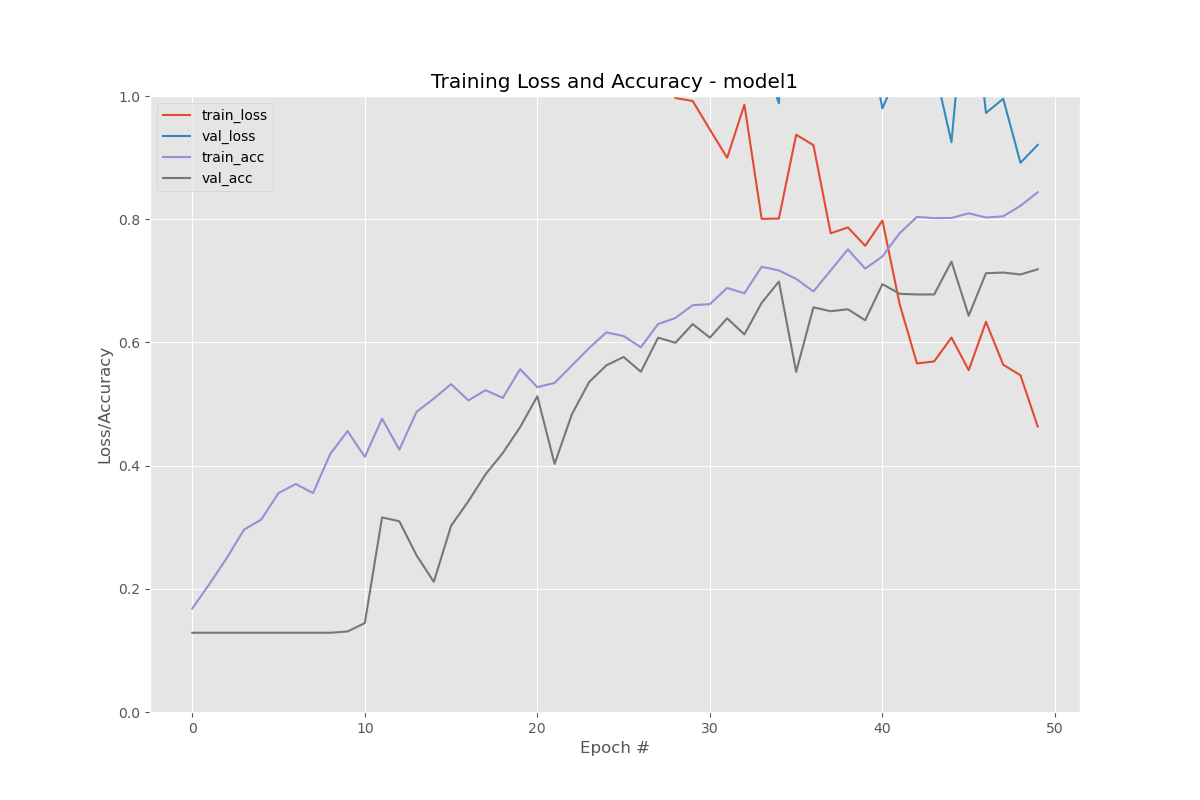

### Model1 No Batch Normalization:
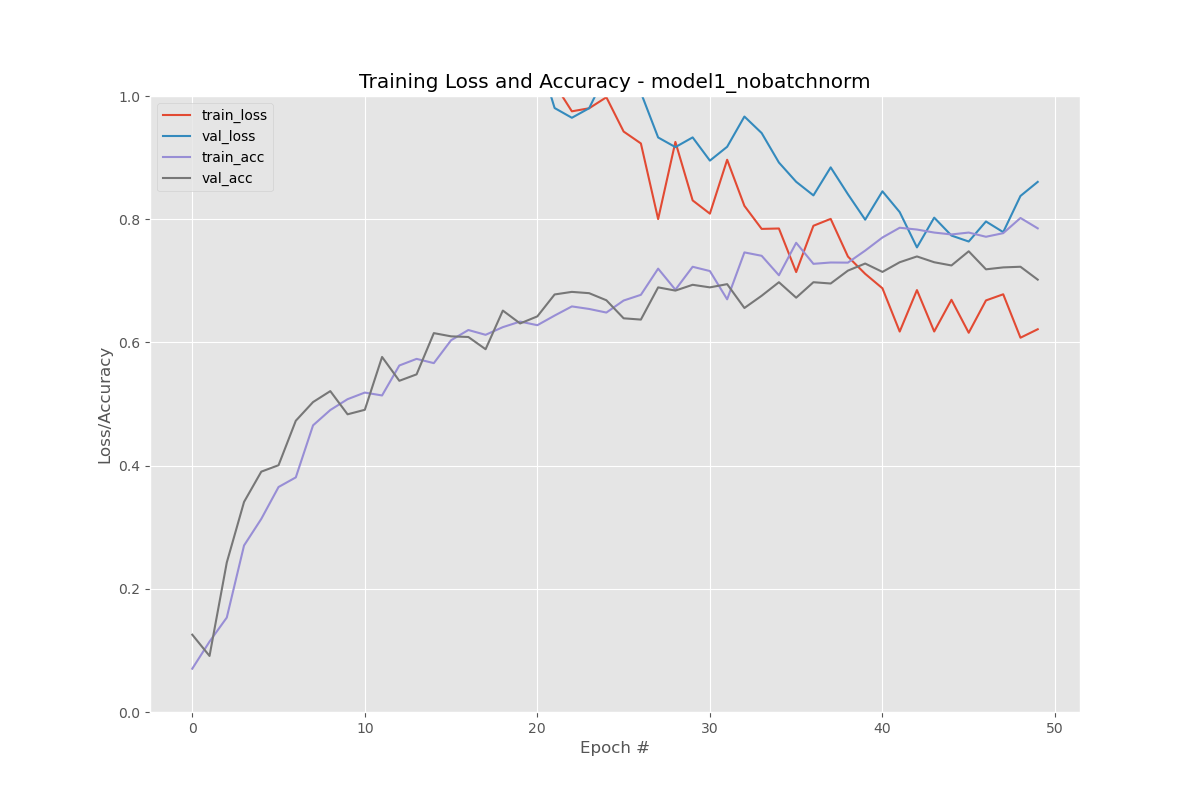

### Model2:
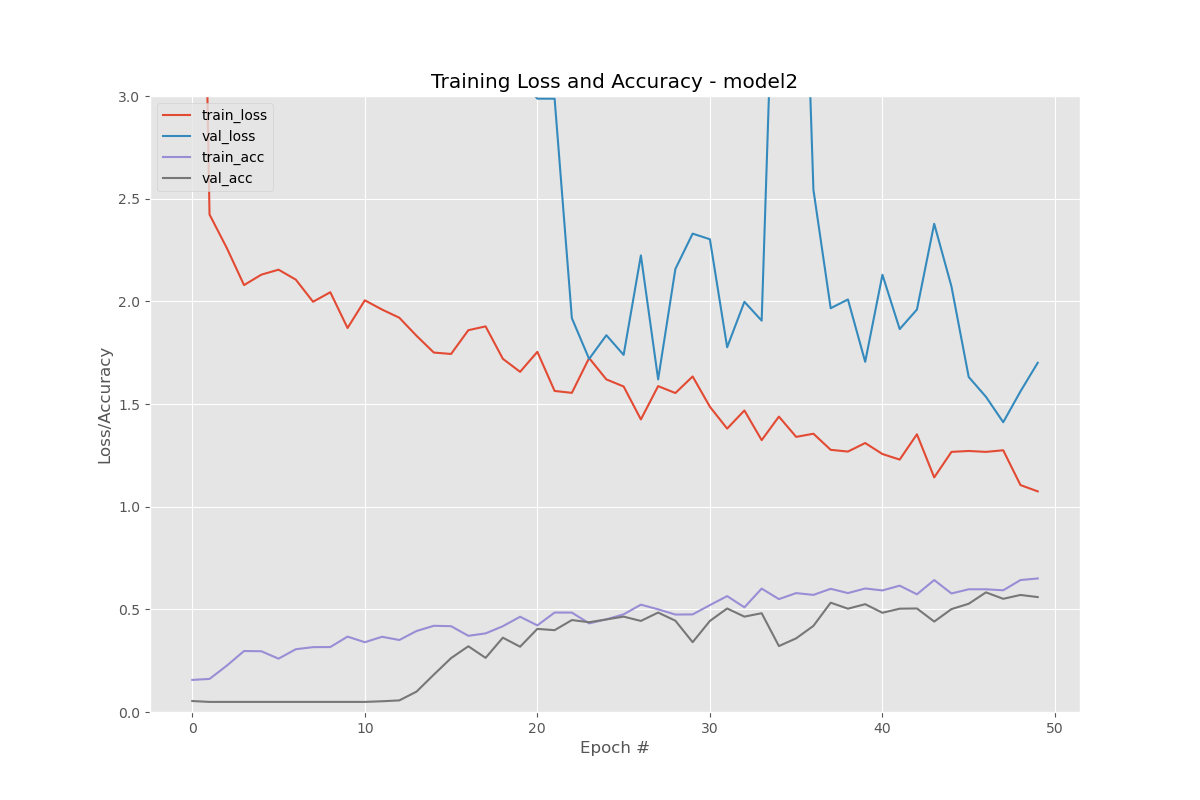

### Model2 No Batch Normalization:
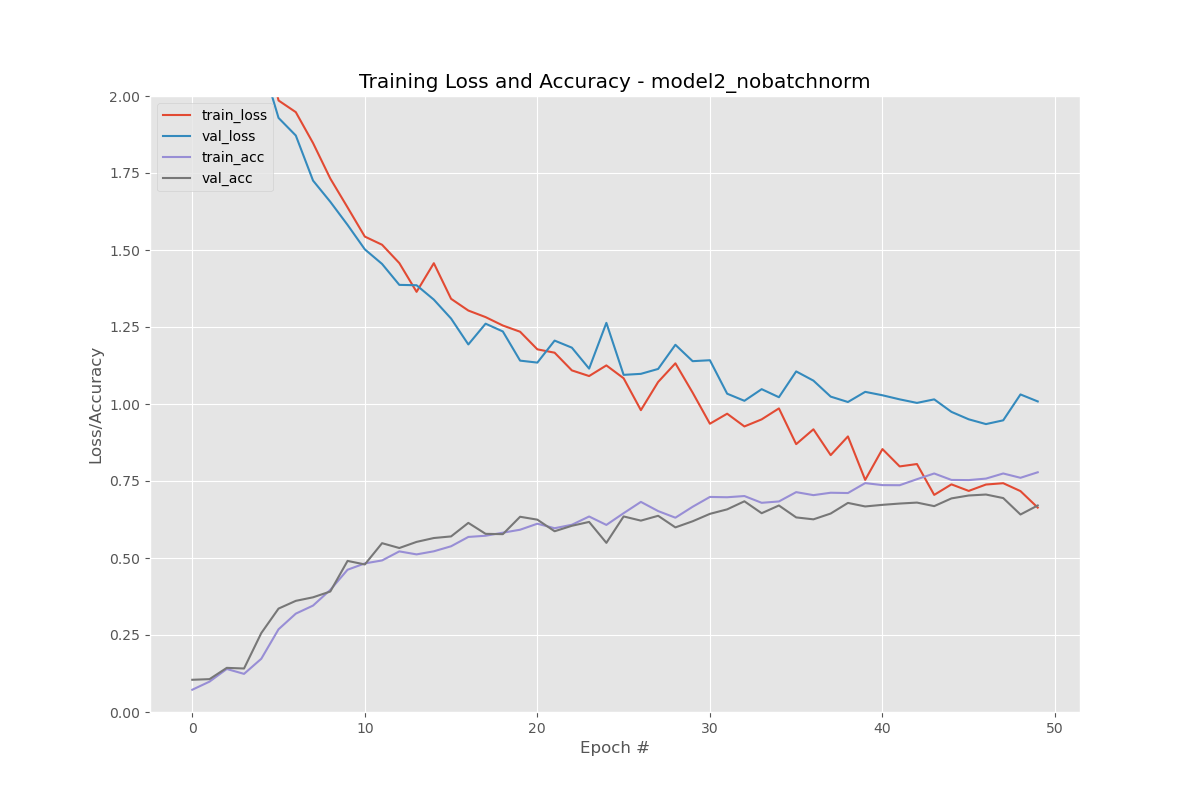

### Model3:
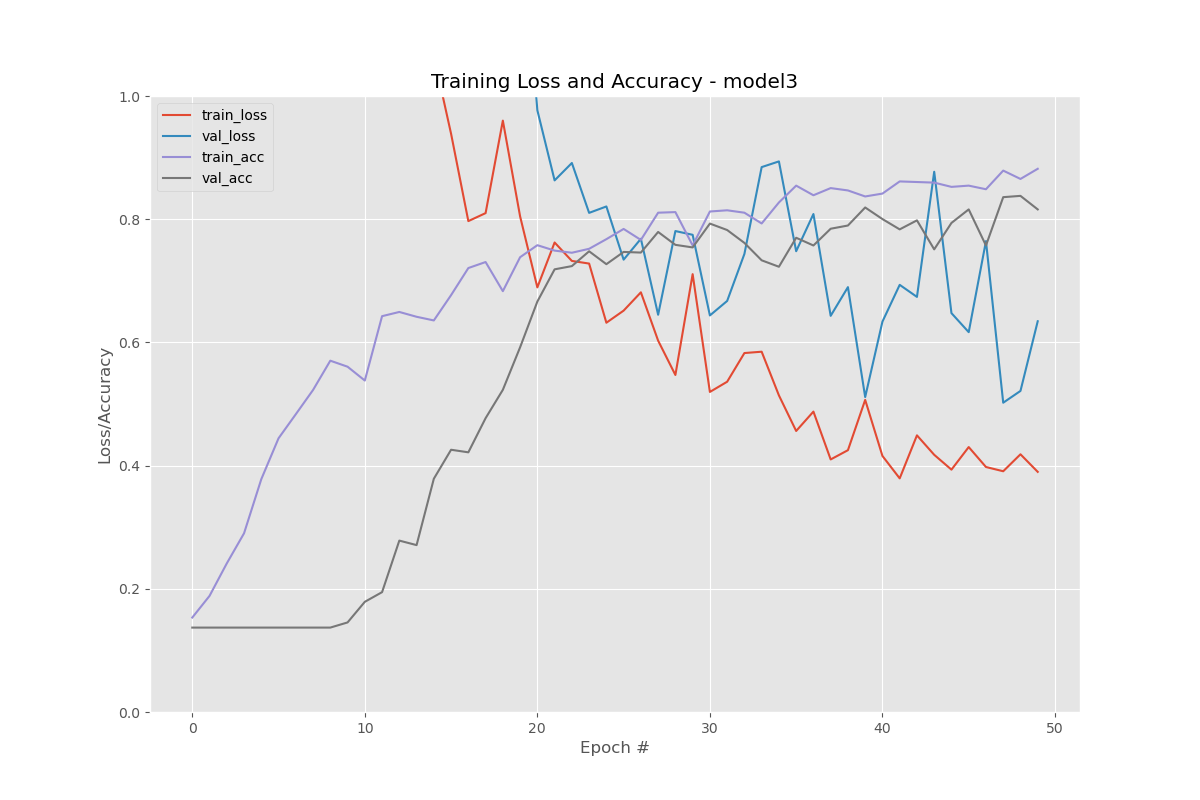

### Model3 No Batch Normalization:
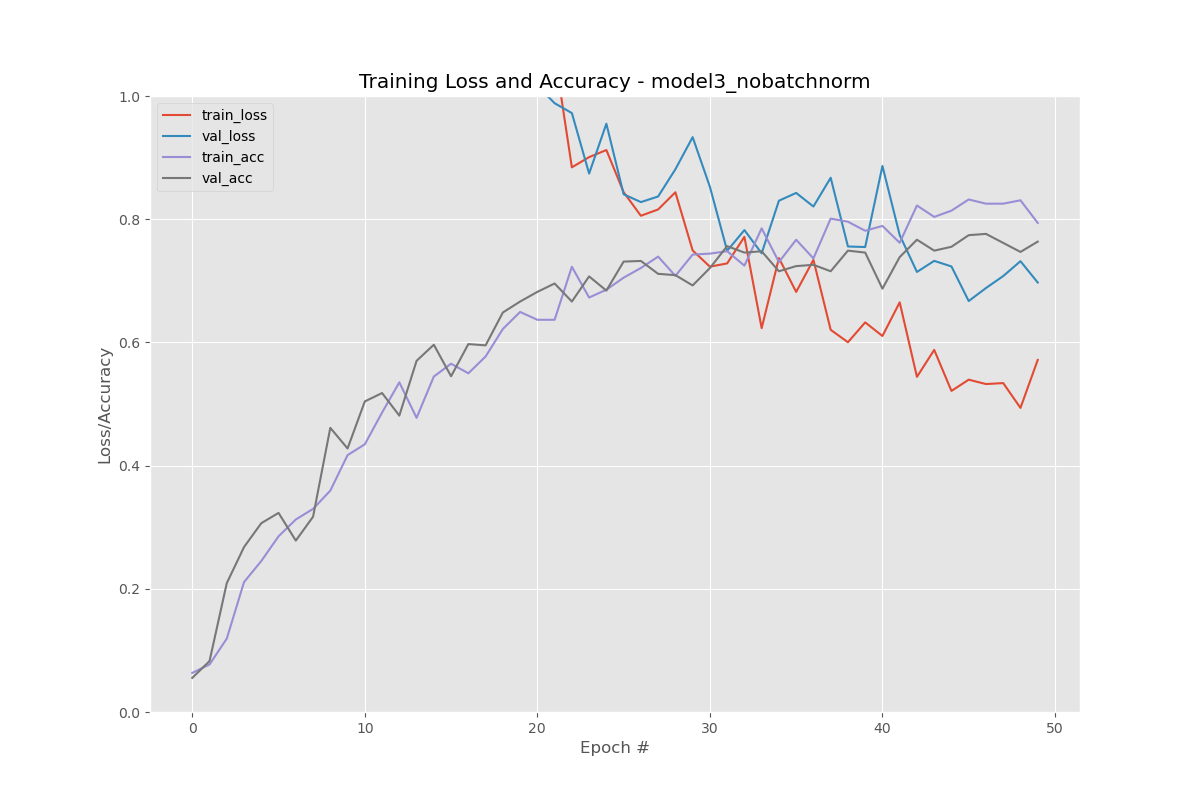

# **6.2 Evaluación del modelo predictivo y planteamiento de la siguiente prueba experimental (pre-entrenada)**


Para realizar una comparación de los modelos vamos a observar las curvas de la función de pérdida y la precisión.

### DenseNet121:
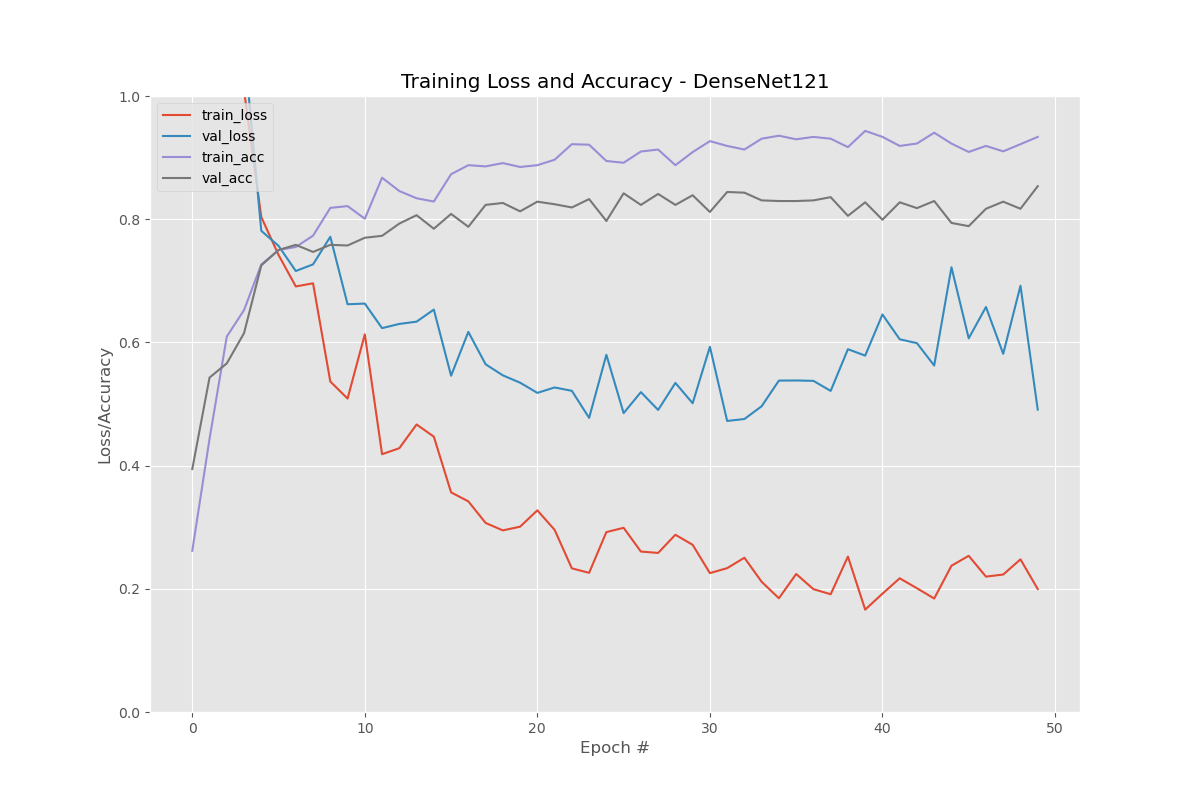

### VGG16:
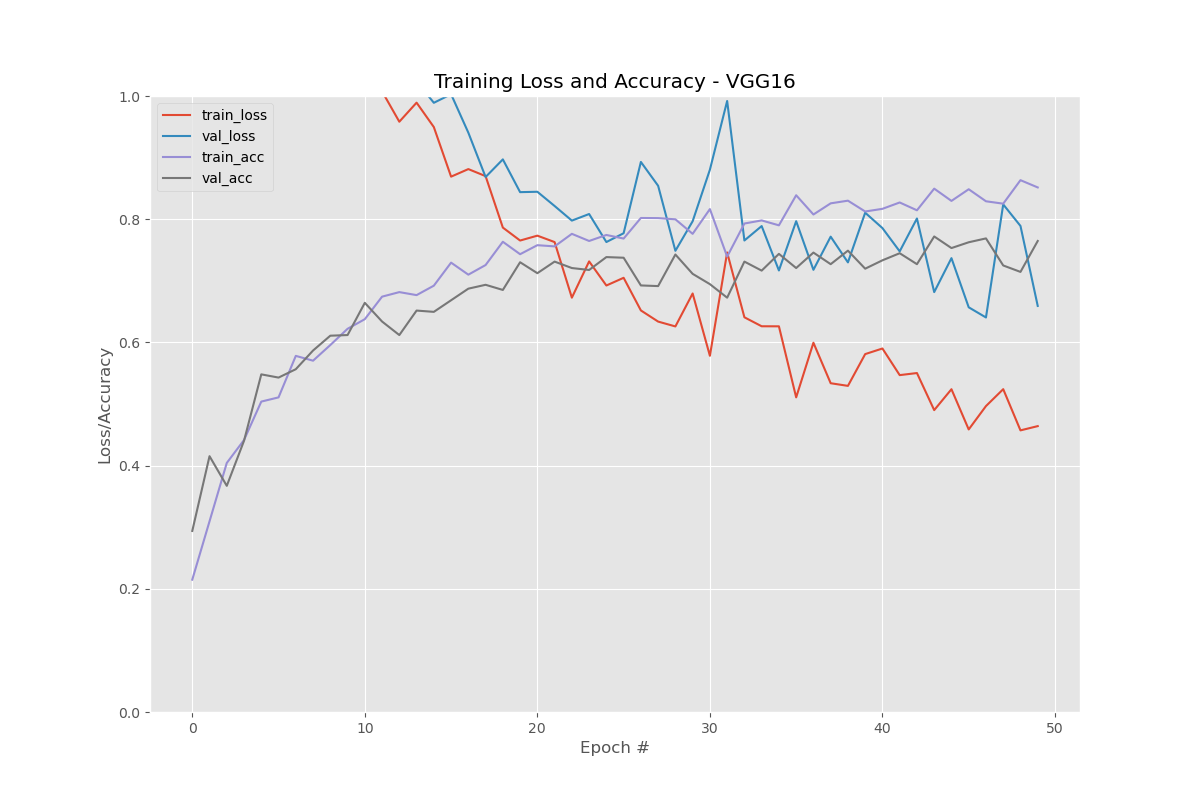

### EfficientNetV2 B0:
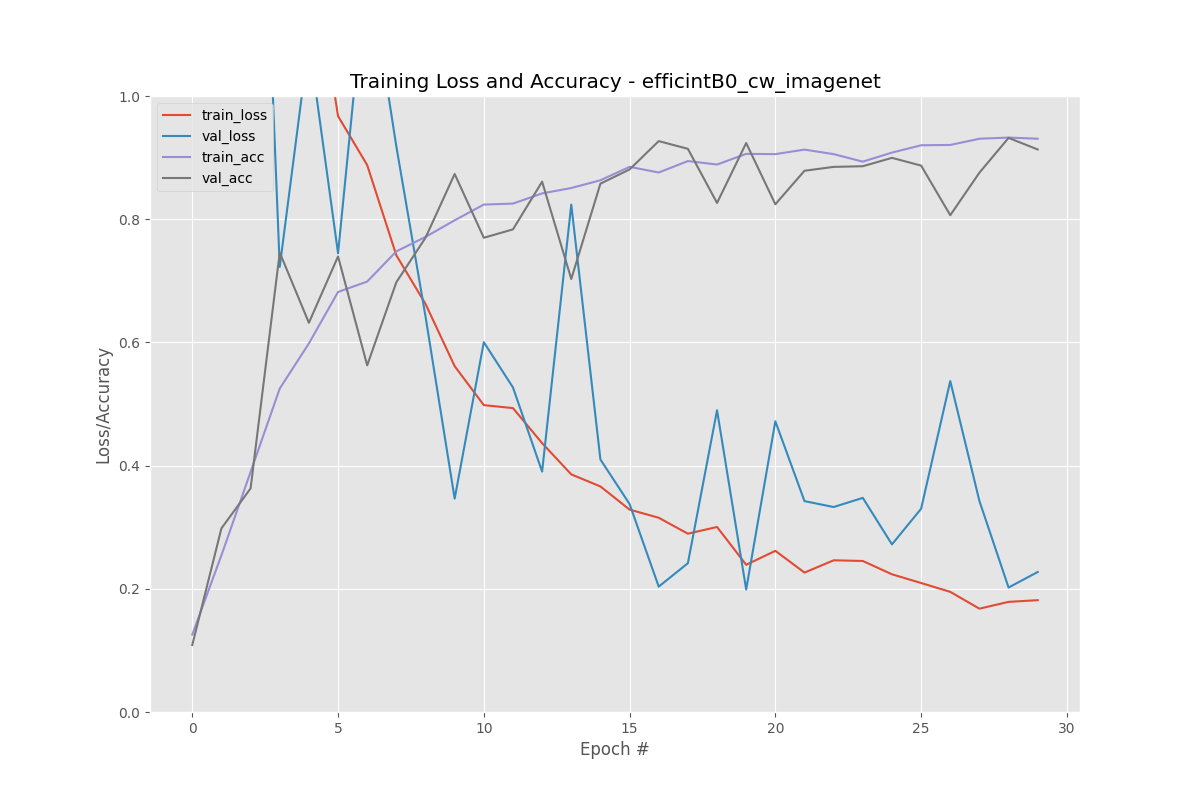


La razón por la cual EfficientNetV2 ha dado los mejores resultados puede estar relacionada con varias razones:
- Mayor capacidad representativa: EfficientNetV2 puede capturar patrones más complejos y representaciones semánticas más profundas en comparación con arquitecturas más simples como VGG16. La arquitectura presenta capas de skip-connections mientras que la VGG16 no. Esto es especialmente beneficioso para tareas de clasificación en conjuntos de datos complejos.

- Arquitectura eficiente: EfficientNetV2 se diseñó específicamente para ser eficiente en términos de recursos computacionales y parámetros, manteniendo un buen rendimiento. Puede lograr una mayor eficiencia con respecto al uso de recursos como memoria y potencia de cálculo en comparación con arquitecturas más antiguas o menos eficientes. El resto de arquitecturas están sobredimensionadas para el problema propuesto

A pesar de que la EfficientNet ha dado los mejores resultados para resolver este problema, cabe destacar que los entrenamientos son muy erráticos y las curvas de entrenamiento son muy oscilatorias. No es el enfoque óptimo para resolver el problema, pero pensamos que una buena optimización de las redes pre-entrenadas podría darnos mejores resultados.